<div id="container" style="position:relative;">
<div style="float:left"><h1> Developing a Prediction NBA Model using Machine Learning (Part 2) </h1></div>
<div style="position:relative; float:right"><img style="height:100px" src ="https://andscape.com/wp-content/uploads/2017/06/nbalogo.jpg?w=700" />
</div>
</div>

Part 2 of this notebook will focus on Feature Extraction & building machine learning models, using the data cleaned on Part 1 of the notebook, for NBA MVP Prediction.

### Notebook Preparation

In [1]:
## Import Packages ##

# Python libaries
import pandas as pd
import numpy as np

#For Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce

# Sklearn Packages
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import r2_score

# XGBooks Packages
from xgboost import XGBRegressor
from xgboost import XGBClassifier

# Neural Networks
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from keras.wrappers.scikit_learn import KerasRegressor

# Import shap for feature importance
import shap

# Save Models
import joblib

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Extract notebook from Part 1
df_model = pd.read_csv('data/df_model2.csv')

In [3]:
# Model constants

# Random State
random_state_val = 123

# Set the `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(random_state_val)

### **Table of Contents** <a id="1.1"></a>
* [1. Feature Engineering](#1)
   * [1.1 Independent Variable (Numerical)](#1.1)
   * [1.2 Independent Variable (Categorical) ](#1.2)
   * [1.3 Dependent Variable ](#1.3)

* [2. Modeling](#2)
   * [2.1 XGBoost / Random Forest Pipeline Regressors](#2.1)
   * [2.2 XGBoost / Random Forest Pipeline Classifiers](#2.2)
      * [2.2.1 Classification Model (Original Dataset)](#2.2.1)   
      * [2.2.2 Classification Model (Upsampled Dataset)](#2.2.2)   
   * [2.3 Keras Regressor](#2.3)
   * [2.4 Keras Classifier](#2.4)
      
* [3. Scikit Learn / Neural Network Model Results & Summary](#3)
   * [3.1 Regression Models Predictions](#3.1)   
   * [3.2 Classification Models Predictions](#3.2)   

* [4. Feature Importance](#4)

* [5. Conclusion](#5)

## Feature Engineering <a id="1"></a>

We have a lot of features and columns to process in this project. There are several numerical columns that are correlated based where they provide similar information i.e FG (field goals) FG% (field goal percentage). Therefore, we would only explore the percentage columns as it provides a normalized value. <br>

But first, lets re-check if there are any nulls and duplicated rows.

In [4]:
# Let us re-check if there are any nulls present
df_model.isnull().sum().any()

False

In [5]:
# Re-checking for Duplicates
# Columns
print(f'Duplicated columns: {df_model.T.duplicated().any()}')
# Rows
print(f'Duplicated rows: {df_model.duplicated().any()}')

Duplicated columns: False
Duplicated rows: False


### Independent Variables (Numerical) <a id="1.1"></a>

In [6]:
# Select numeric variables 
df_numeric = df_model.select_dtypes(['float64','int64'])

# Filter out target variable and correlated variables
df_numeric.drop(columns=['Year', 'Rank', 'First', 'Pts Won', 'Pts Max','Share'], inplace=True)

In [7]:
# summary statistics
df_numeric.describe()

Age             G            MP           PER           TS%  \
count  18243.000000  18243.000000  18243.000000  18243.000000  18243.000000   
mean      26.629228     53.733980   1266.924848     12.784805      0.512726   
std        4.083790     25.309209    916.648357      6.113283      0.091148   
min       18.000000      1.000000      0.000000    -90.600000      0.000000   
25%       23.000000     35.000000    414.000000      9.900000      0.481000   
50%       26.000000     61.000000   1188.000000     12.900000      0.523000   
75%       29.000000     76.000000   2012.500000     15.900000      0.558000   
max       44.000000     85.000000   3533.000000    133.800000      1.500000   

               3PAr           FTr          ORB%          DRB%          TRB%  \
count  18243.000000  18243.000000  18243.000000  18243.000000  18243.000000   
mean       0.188682      0.309661      6.031382     14.038935     10.036244   
std        0.206789      0.214138      4.845100      6.519863      4.964947   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.007000      0.193000      2.500000      9.200000      6.100000   
50%        0.102000      0.279000      5.000000     13.100000      9.200000   
75%        0.338000      0.385000      8.800000     18.200000     13.400000   
max        1.000000      6.000000    100.000000    100.000000     86.400000   

       ...             W             L            PW            PL  \
count  ...  18243.000000  18243.000000  18243.000000  18243.000000   
mean   ...     39.793839     40.390670     39.876117     40.308392   
std    ...     12.775424     12.748206     12.297963     12.289292   
min    ...      7.000000      9.000000      7.000000     11.000000   
25%    ...     30.000000     31.000000     31.000000     31.000000   
50%    ...     41.000000     40.000000     40.000000     40.000000   
75%    ...     50.000000     50.000000     49.000000     49.000000   
max    ...     73.000000     72.000000     70.000000     72.000000   

                MOV           SOS           SRS          ORtg          DRtg  \
count  18243.000000  18243.000000  18243.000000  18243.000000  18243.000000   
mean      -0.122249      0.005656     -0.116557    106.925341    107.039577   
std        4.679379      0.394753      4.518789      4.068726      3.777568   
min      -15.200000     -1.030000    -14.680000     92.200000     94.100000   
25%       -3.390000     -0.280000     -3.260000    104.200000    104.500000   
50%        0.160000      0.000000      0.070000    106.700000    107.200000   
75%        3.350000      0.300000      3.140000    109.700000    109.700000   
max       12.240000      1.170000     11.800000    118.300000    117.600000   

               NRtg  
count  18243.000000  
mean      -0.114236  
std        4.886269  
min      -15.200000  
25%       -3.500000  
50%        0.200000  
75%        3.500000  
max       13.400000  

[8 rows x 33 columns]

We have 33 features to explore which is quite sizeable. Let us inspect correlation between the variables and potentially eliminate variables that are correlated. 

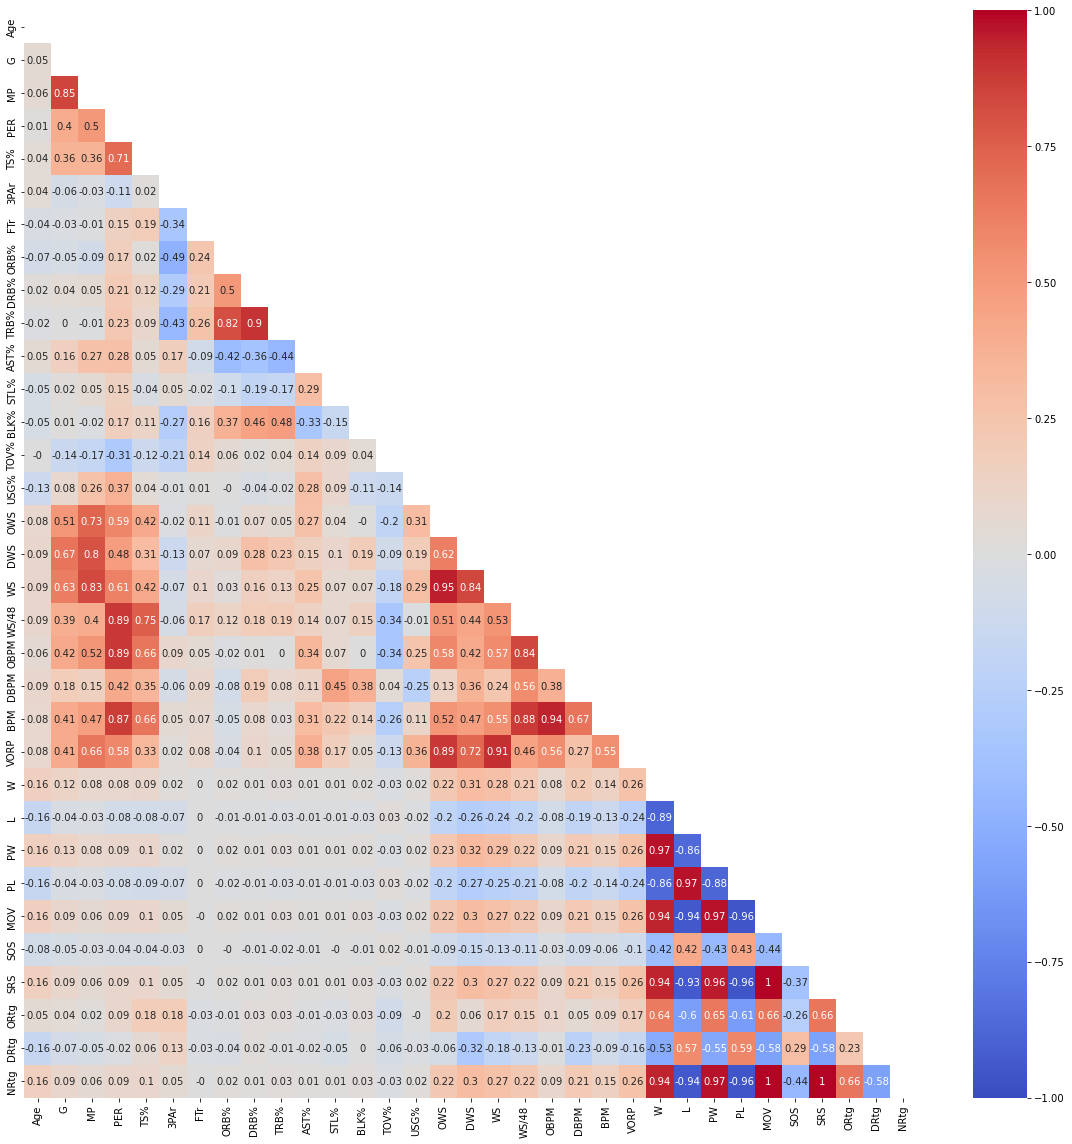

In [8]:
# Calculate all the correlations between each independent variable
corr_df = df_numeric.corr()

# Mask for upper-triangular
mask = np.triu(corr_df)

# Visualize with seaborn
plt.figure(figsize=(20, 20))
sns.heatmap(corr_df.round(2), annot=True, vmax=1, vmin=-1, center=0, cmap='coolwarm', mask=mask)
plt.show()

There are several features that are correlated. Additionally, some of the variables are redundant and provided similar information i.e 3P and 3P%. For our model, it would be beneficial to use scaled data so we will drop columns that are not scaled i.e 3P, 3PA.
- Drop G, but keep MP
- Drop TRB, but keep ORB and DRB
- Drop PW, PL, L, W but keep MOV
- Drop NRtg, but keep ORTg and DRTg 
- Drop SRS, but keep SOS

In [9]:
df_numeric.drop(columns=['G','TRB%','W','PW','PL','L','NRtg', 'SRS'],inplace=True)

We still have correlation between several features, so a linear regression model will not be ideal for this project as we would need to eliminate so many variables which will likely result in a low model accuracy. <br>

Given we have 24 features left, it still quite a number of variables to explore relationships further. Lets create plots to evaluate relationships/trends between the 9 key individual player statistics. 

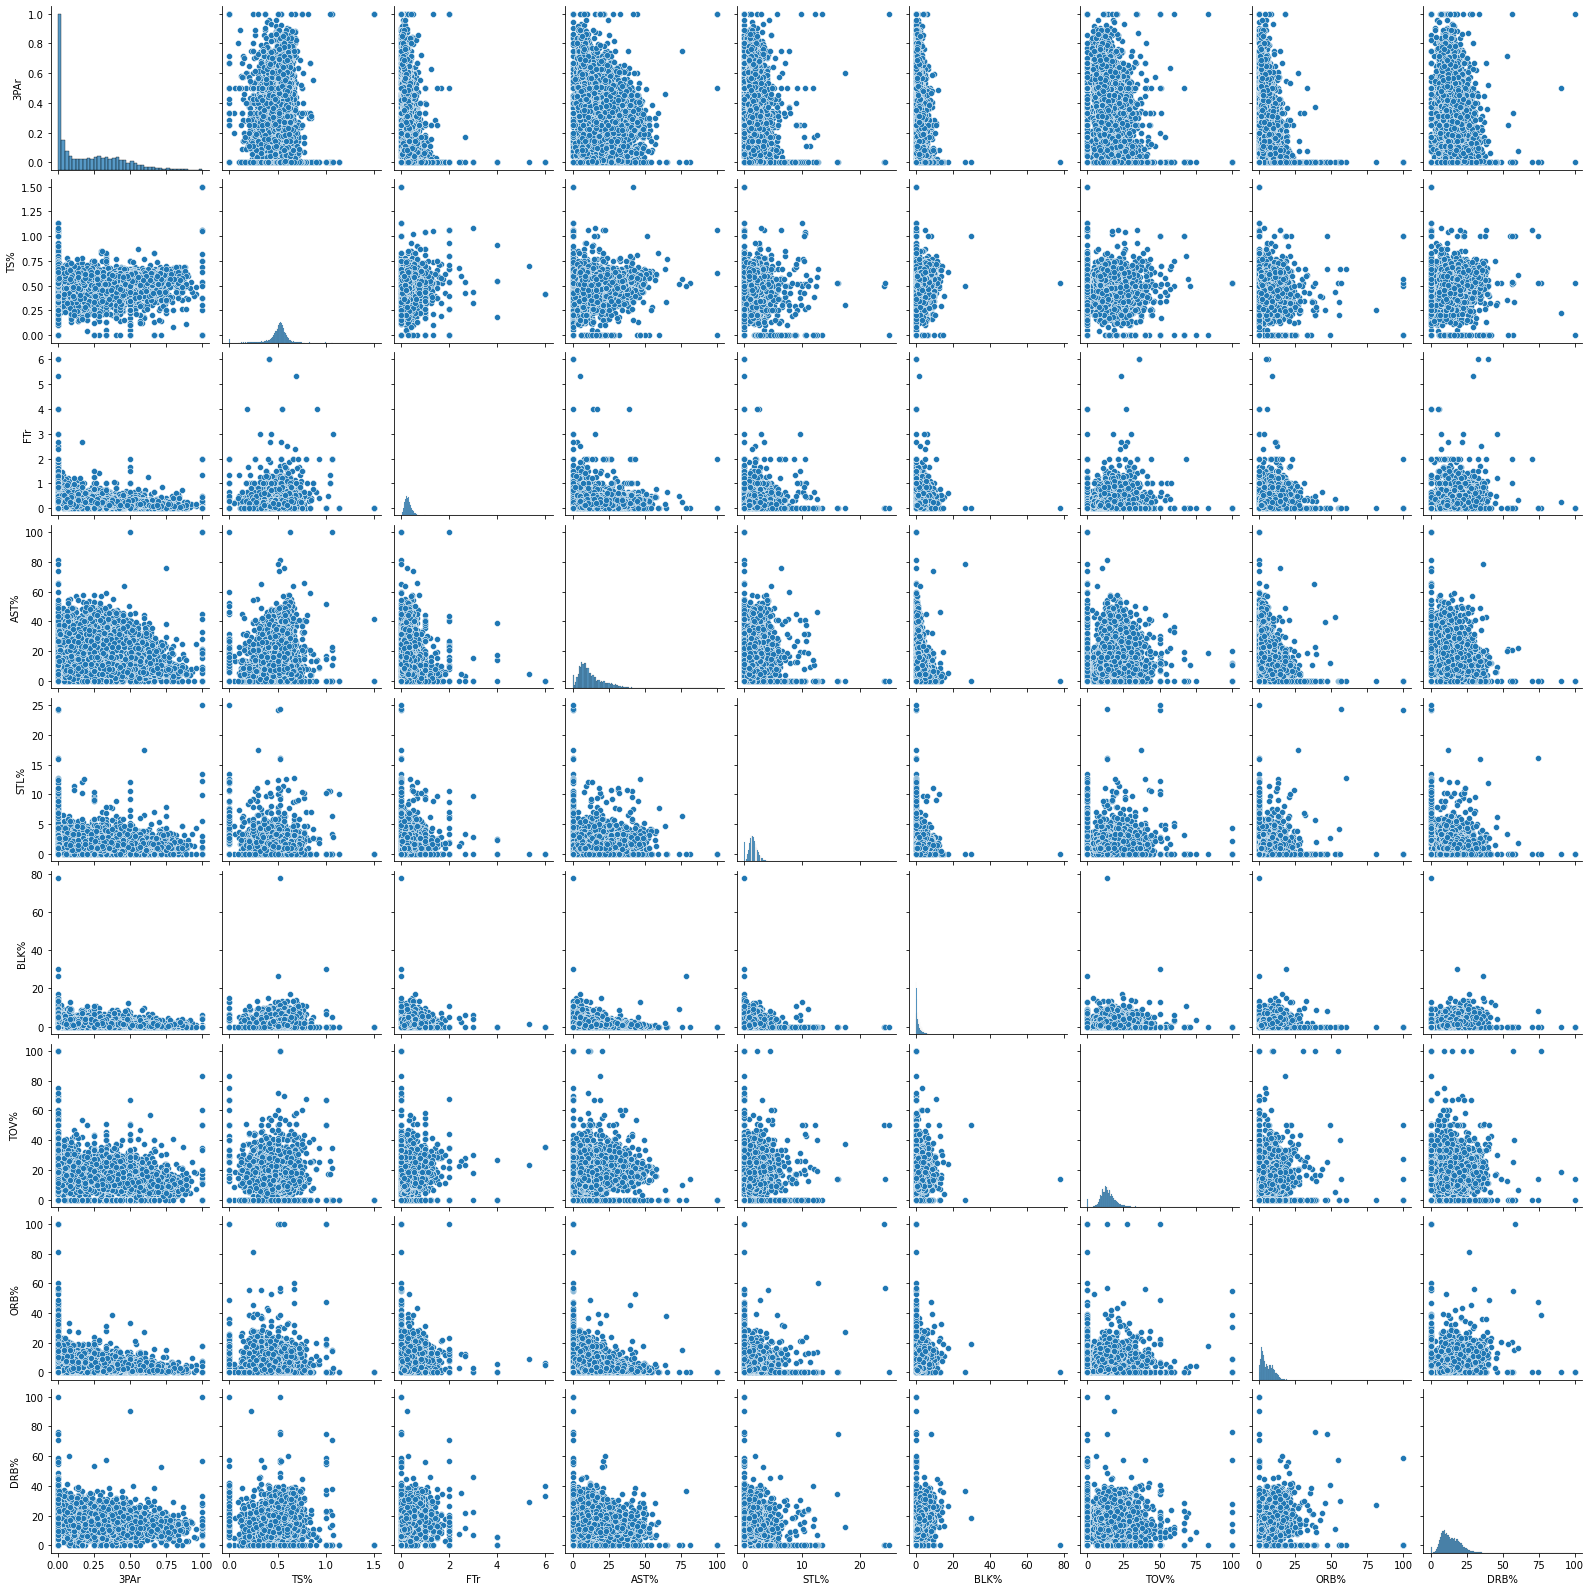

In [10]:
# seaborn pair plot
sns.pairplot(df_numeric[['3PAr','TS%','FTr','AST%','STL%','BLK%','TOV%','ORB%','DRB%']])

There are interesting trends when we evaluate columns extracted from the 3 dataframes:
- Efficiency columns - 3P%, FG%, FT% - all appear normally distributed as well, which makes sense given these columns have been normalized. 
- Remaining columns are left skewed.
- Linear Relationships exist between the several variables to name a few:
    - DRB and ORB
    - PTS and AST
    - PTS and STL
    - TOV and PTS
    - TOV and AST

### Independent Variables (Categorical) <a id="1.2"></a>

Now that we have explored the numerical independent variables, lets convert the categorical columns to numerical values. 

In [11]:
df_categ = df_model.select_dtypes(['object'])
df_categ.head()

Player             Team Pos_new  Era
0          Bob Lanier  Milwaukee Bucks     Big  80s
1     Marques Johnson  Milwaukee Bucks    Wing  80s
2       Brian Winters  Milwaukee Bucks   Guard  80s
3        Pat Cummings  Milwaukee Bucks     Big  80s
4  Richard Washington  Milwaukee Bucks     Big  80s

The above columns *nominal* rather than *ordinal* so we will use the `OneHotEncoder()` so features can be expressed across binary columns. 

In [12]:
# Convert Team column to Binary

# instantiate encoder
ohe = OneHotEncoder()

# 2D array required so store as dataframe
Team = pd.DataFrame(df_model['Team'])

# fit and transform data
encoded_Team = ohe.fit_transform(Team)

# convert from sparse to dense
dense_array_Team = encoded_Team.toarray()

# Put into a dataframe to get column names
Team_df = pd.DataFrame(dense_array_Team, columns=ohe.categories_[0], dtype=float)

# Preview
Team_df.head()

Atlanta Hawks  Boston Celtics  Brooklyn Nets  Charlotte Hornets  \
0            0.0             0.0            0.0                0.0   
1            0.0             0.0            0.0                0.0   
2            0.0             0.0            0.0                0.0   
3            0.0             0.0            0.0                0.0   
4            0.0             0.0            0.0                0.0   

   Chicago Bulls  Cleveland Cavaliers  Dallas Mavericks  Denver Nuggets  \
0            0.0                  0.0               0.0             0.0   
1            0.0                  0.0               0.0             0.0   
2            0.0                  0.0               0.0             0.0   
3            0.0                  0.0               0.0             0.0   
4            0.0                  0.0               0.0             0.0   

   Detroit Pistons  Golden State Warriors  ...  Oklahoma City Thunder  \
0              0.0                    0.0  ...                    0.0   
1              0.0                    0.0  ...                    0.0   
2              0.0                    0.0  ...                    0.0   
3              0.0                    0.0  ...                    0.0   
4              0.0                    0.0  ...                    0.0   

   Orlando Magic  Philadelphia 76ers  Phoenix Suns  Portland Trail Blazers  \
0            0.0                 0.0           0.0                     0.0   
1            0.0                 0.0           0.0                     0.0   
2            0.0                 0.0           0.0                     0.0   
3            0.0                 0.0           0.0                     0.0   
4            0.0                 0.0           0.0                     0.0   

   Sacramento Kings  San Antonio Spurs  Toronto Raptors  Utah Jazz  \
0               0.0                0.0              0.0        0.0   
1               0.0                0.0              0.0        0.0   
2               0.0                0.0              0.0        0.0   
3               0.0                0.0              0.0        0.0   
4               0.0                0.0              0.0        0.0   

   Washington Wizards  
0                 0.0  
1                 0.0  
2                 0.0  
3                 0.0  
4                 0.0  

[5 rows x 30 columns]

In [13]:
# Convert Pos_new column to binary

ohe = OneHotEncoder()
Pos_new = pd.DataFrame(df_model['Pos_new'])
encoded_Pos_new = ohe.fit_transform(Pos_new)
dense_array_Pos_new = encoded_Pos_new.toarray()
Pos_df = pd.DataFrame(dense_array_Pos_new, columns=ohe.categories_[0], dtype=int)
Pos_df.head()

Big  Guard  Wing
0    1      0     0
1    0      0     1
2    0      1     0
3    1      0     0
4    1      0     0

In [14]:
# Convert Era column to binary

ohe = OneHotEncoder()
Era = pd.DataFrame(df_model['Era'])
encoded_Era = ohe.fit_transform(Era)
dense_array_Era = encoded_Era.toarray()
Era_df = pd.DataFrame(dense_array_Era, columns=ohe.categories_[0], dtype=float)
Era_df.head()

2000s  2010s  2020s  80s  90s
0    0.0    0.0    0.0  1.0  0.0
1    0.0    0.0    0.0  1.0  0.0
2    0.0    0.0    0.0  1.0  0.0
3    0.0    0.0    0.0  1.0  0.0
4    0.0    0.0    0.0  1.0  0.0

In [15]:
# Merge categorical one hot encoded arrays to 1 dataframe
df_categ = pd.concat([Era_df, Pos_df, Team_df], axis=1)

### Dependent Variable<a id="1.3"></a>

We have the luxury of performing either a classification model or a regression model to predict the 2022 NBA MVP winner given we have the MVP votes `Share` column and MVP `Rank`column that both could be target variables. We will be exploring both regression and classification models for this project. 

In [16]:
# Let us first analyze the distribution of MVP winners in the dataset.
df_model['Rank'] = np.where(df_model['Rank'] == 1, 1, 0)

df_model['Rank'].value_counts()

0    18200
1       43
Name: Rank, dtype: int64

We certainly have an imbalanced dataset! Therefore, we would need to consider `Precision` and `Recall` scores  instead of the accuracy metric to evaluate performance for the classification models. 

In [17]:
# Join categorical and numerical dataframes to form final model.
df_model_new = pd.concat([df_model[['Player','Year','Rank','Share']],df_numeric, Team_df, Pos_df, Era_df], axis=1)

# Inspect df_model_new
df_model_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18243 entries, 0 to 18242
Data columns (total 67 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Player                  18243 non-null  object 
 1   Year                    18243 non-null  int64  
 2   Rank                    18243 non-null  int64  
 3   Share                   18243 non-null  float64
 4   Age                     18243 non-null  float64
 5   MP                      18243 non-null  float64
 6   PER                     18243 non-null  float64
 7   TS%                     18243 non-null  float64
 8   3PAr                    18243 non-null  float64
 9   FTr                     18243 non-null  float64
 10  ORB%                    18243 non-null  float64
 11  DRB%                    18243 non-null  float64
 12  AST%                    18243 non-null  float64
 13  STL%                    18243 non-null  float64
 14  BLK%                    18243 non-null

## Modeling <a id="2"></a>

Now that we have a final dataframe that can be used for modeling, we can now split our dataframe into training and test sets. 

In [18]:
# Split Train and Test Sets
df_train = df_model_new[df_model_new['Year'] < 2010]
df_test = df_model_new[df_model_new['Year'] > 2010]

# Evaluate proportion of Train and Test Sets
print(f"Proportion of Training data on whole dataset: {df_train.shape[0]/(df_train.shape[0]+df_test.shape[0])*100}")
print(f"Proportion of Test data on whole dataset: {df_test.shape[0]/(df_train.shape[0]+df_test.shape[0])*100}")

Proportion of Training data on whole dataset: 65.87270378068648
Proportion of Test data on whole dataset: 34.12729621931352


In [19]:
# Split data into X and y variables
X_train = df_train.drop(columns=['Rank','Share','Player','Year'])
y_train_num = np.log1p(df_train['Share'])
y_train_class = df_train['Rank']
                         
X_test = df_test.drop(columns=['Rank','Share','Player','Year'])
y_test_num = np.log1p(df_test['Share'])
y_test_class = df_test['Rank'] 

We will first proceed with a Linear Regression model for the analysis, then perform a classification model for comparison.

### XGBoost / Random Forest Pipeline Regressors <a id="2.1"></a>

I will be using the following ensemble ML algorithms for my model: XGBoost Regressor and Random Forest Regressors. The goal of using Ensemble methods for this analysis is to use a collection of machine learning algorithms to increase predictive power and enhance model performance.

We will be passing in the following hyperparameters in a pipeline and tuning them to enhance model performance:
- **Max Depth Range** (to control overfitting): (2,10)
- **N_Estimators** (# of runs XGBoost will try to learn): (10, 50, 100)
- **Learning Rate** (learning speed): (0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7)

In [20]:
# Build ML Pipeline to pass in Regressors

#we give our estimators as a list of tuples: name:function.
estimators = [('normalise', StandardScaler()),
              ('model', XGBRegressor())]

# Develop Pipeline
pipe = Pipeline(estimators)
               
# Building model options
param_grid = [
            {'normalise': [StandardScaler()],
             'model': [XGBRegressor()],
             'model__max_depth': np.arange(2,10),
             'model__learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7],
             'model__n_estimators': [10,50,100], 'model__random_state' : [random_state_val]
            },
            {'normalise': [StandardScaler()],
             'model': [RandomForestRegressor()],
             'model__max_depth': np.arange(2,10),
             'model__n_estimators': [10,50,100], 'model__random_state' : [random_state_val]
            },
]

In [21]:
#GridSearch 
grid_reg = GridSearchCV(pipe, param_grid, verbose=5, n_jobs=-1, cv=3)

In [22]:
#Fit the model 
fittedgrid_reg = grid_reg.fit(X_train, y_train_num)

Fitting 3 folds for each of 192 candidates, totalling 576 fits
[CV 1/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.0001, model__max_depth=2, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=-105.535 total time=   3.0s
[CV 2/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_

             validate_parameters=None, verbosity=None), model__learning_rate=0.0001, model__max_depth=6, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=-116.314 total time=   1.2s[CV 1/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.0001, model__max_depth=2, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=-106.389

             validate_parameters=None, verbosity=None), model__learning_rate=0.0001, model__max_depth=6, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=-127.455 total time=   6.6s[CV 3/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.0001, model__max_depth=2, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=-128.477

             validate_parameters=None, verbosity=None), model__learning_rate=0.0001, model__max_depth=6, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=-104.476 total time=  10.1s[CV 2/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.0001, model__max_depth=2, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=-116.31

             validate_parameters=None, verbosity=None), model__learning_rate=0.0001, model__max_depth=8, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=-127.456 total time=   4.9s
[CV 1/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.0001, model__max_depth=7, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=-106.38

             validate_parameters=None, verbosity=None), model__learning_rate=0.001, model__max_depth=3, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=-114.228 total time=   0.9s
[CV 2/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.0001, model__max_depth=7, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=-115.382

             validate_parameters=None, verbosity=None), model__learning_rate=0.001, model__max_depth=3, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=-116.473 total time=   3.6s
[CV 3/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.0001, model__max_depth=6, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=-128.478

             validate_parameters=None, verbosity=None), model__learning_rate=0.0001, model__max_depth=9, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=-126.189 total time=  10.3s
[CV 1/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.0001, model__max_depth=9, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=-106.3

             validate_parameters=None, verbosity=None), model__learning_rate=0.001, model__max_depth=5, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=-114.226 total time=   1.0s
[CV 1/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.001, model__max_depth=4, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=-104.476 

             validate_parameters=None, verbosity=None), model__learning_rate=0.001, model__max_depth=8, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=-114.227 total time=   1.1s
[CV 3/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.001, model__max_depth=3, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=-126.185 

             validate_parameters=None, verbosity=None), model__learning_rate=0.001, model__max_depth=7, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=-105.395 total time=   5.0s
[CV 3/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.001, model__max_depth=2, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=-105.351

             validate_parameters=None, verbosity=None), model__learning_rate=0.001, model__max_depth=9, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=-114.227 total time=   1.2s
[CV 3/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.001, model__max_depth=7, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=-105.412

             validate_parameters=None, verbosity=None), model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=-15.089 total time=   7.2s
[CV 3/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.001, model__max_depth=8, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=-126.188 t

             validate_parameters=None, verbosity=None), model__learning_rate=0.01, model__max_depth=4, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=-95.208 total time=   0.8s
[CV 3/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.001, model__max_depth=5, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=-126.186 to

             validate_parameters=None, verbosity=None), model__learning_rate=0.001, model__max_depth=8, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=-105.419 total time=  12.1s
[CV 2/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.001, model__max_depth=9, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=-95.306

             validate_parameters=None, verbosity=None), model__learning_rate=0.01, model__max_depth=8, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=-15.087 total time=  11.6s
[CV 3/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.001, model__max_depth=9, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=-126.188 t

             validate_parameters=None, verbosity=None), model__learning_rate=0.01, model__max_depth=6, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=-17.100 total time=  10.8s
[CV 3/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.01, model__max_depth=4, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=-105.282 to

             validate_parameters=None, verbosity=None), model__learning_rate=0.01, model__max_depth=8, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=-87.044 total time=   1.3s
[CV 3/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.01, model__max_depth=4, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=-47.021 tota

             validate_parameters=None, verbosity=None), model__learning_rate=0.01, model__max_depth=7, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=-38.537 total time=   5.5s
[CV 3/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.01, model__max_depth=9, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=-47.130 tota

             validate_parameters=None, verbosity=None), model__learning_rate=0.1, model__max_depth=4, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=-13.576 total time=   1.1s
[CV 2/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.01, model__max_depth=8, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=-95.219 total

             validate_parameters=None, verbosity=None), model__learning_rate=0.1, model__max_depth=4, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.419 total time=   5.0s
[CV 2/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.01, model__max_depth=7, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=-15.091 total 

             validate_parameters=None, verbosity=None), model__learning_rate=0.1, model__max_depth=6, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.558 total time=  13.4s
[CV 1/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.1, model__max_depth=5, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=-12.333 total t

             validate_parameters=None, verbosity=None), model__learning_rate=0.1, model__max_depth=7, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.638 total time=  15.5s
[CV 1/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.01, model__max_depth=7, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=-13.665 total

             validate_parameters=None, verbosity=None), model__learning_rate=0.1, model__max_depth=4, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.690 total time=   5.1s
[CV 3/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.1, model__max_depth=4, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=-15.429 total ti

             validate_parameters=None, verbosity=None), model__learning_rate=0.1, model__max_depth=8, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=-12.338 total time=   1.3s
[CV 2/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.1, model__max_depth=7, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.635 total ti

             validate_parameters=None, verbosity=None), model__learning_rate=0.3, model__max_depth=2, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.662 total time=   5.3s
[CV 3/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.1, model__max_depth=8, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.374 total tim

             validate_parameters=None, verbosity=None), model__learning_rate=0.3, model__max_depth=4, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.535 total time=   1.1s
[CV 3/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.1, model__max_depth=4, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.438 total tim

             validate_parameters=None, verbosity=None), model__learning_rate=0.3, model__max_depth=4, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.641 total time=   4.9s
[CV 2/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.1, model__max_depth=8, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=-13.656 total ti

             validate_parameters=None, verbosity=None), model__learning_rate=0.3, model__max_depth=5, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.365 total time=  11.8s
[CV 2/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.3, model__max_depth=3, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.559 total tim

             validate_parameters=None, verbosity=None), model__learning_rate=0.3, model__max_depth=7, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.480 total time=   1.3s
[CV 3/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.3, model__max_depth=4, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.360 total tim

             validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=2, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.441 total time=   0.6s
[CV 2/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.3, model__max_depth=4, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.567 total time

             validate_parameters=None, verbosity=None), model__learning_rate=0.3, model__max_depth=7, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.327 total time=   7.3s
[CV 1/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.3, model__max_depth=6, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.523 total tim

             validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=4, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.626 total time=   1.4s
[CV 1/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=2, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.603 total time

             validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=5, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.229 total time=   1.3s
[CV 2/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.3, model__max_depth=7, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.507 total time

             validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=3, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.528 total time=   7.5s
[CV 1/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.3, model__max_depth=8, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.479 total tim

             validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=4, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.588 total time=   9.0s
[CV 3/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=4, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.307 total tim

             validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=8, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.212 total time=   1.6s
[CV 1/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=5, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.523 total time

             validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=9, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.571 total time=   4.7s
[CV 2/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=4, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.606 total time

             validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=9, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.176 total time=   5.3s
[CV 2/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=8, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.588 total time

             validate_parameters=None, verbosity=None), model__learning_rate=0.7, model__max_depth=4, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.577 total time=   4.6s
[CV 2/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=5, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.603 total time

             validate_parameters=None, verbosity=None), model__learning_rate=0.7, model__max_depth=2, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.447 total time=   5.4s
[CV 2/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=9, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.575 total ti

             validate_parameters=None, verbosity=None), model__learning_rate=0.7, model__max_depth=5, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.180 total time=   1.2s
[CV 1/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.7, model__max_depth=2, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.615 total time

In [23]:
print(f" Regression model Test Score: {fittedgrid_reg.score(X_test,y_test_num)}")
print(f" Regression model Train Score: {fittedgrid_reg.score(X_train,y_train_num)}")                                       

 Regression model Test Score: 0.671924473298036
 Regression model Train Score: 0.9431301071644058


In [24]:
# Best estimator in pipeline
fittedgrid_reg.best_estimator_

Pipeline(steps=[('normalise', StandardScaler()),
                ('model',
                 RandomForestRegressor(max_depth=9, n_estimators=50,
                                       random_state=123))])

Our best model is a **Random Forest Regressor** with a **max_depth** 9 and **n_estimators** 50. The model performed poorly with significant overfitting given the huge difference between test and training scores. Let us now evaluate model predictions

In [25]:
# Get prediction values
predictions_reg = fittedgrid_reg.predict(X_test)

# Build a df
predictions_reg = pd.DataFrame(predictions_reg, columns=["Predicted MVP Votes"], index=df_test.index)

# Add player and year columns
reg_results_df = pd.concat([df_test[['Year','Player']], predictions_reg], axis=1)

# Create a filter to extract the maximum share of MVP votes in each calendar year
filter1 = reg_results_df['Predicted MVP Votes'].isin(reg_results_df.groupby('Year').max()['Predicted MVP Votes'])

# Apply filter
reg_results_df = reg_results_df[filter1]
reg_results_df

Year                 Player  Predicted MVP Votes
12502  2011           LeBron James             0.396176
12863  2012           LeBron James             0.399963
13552  2013           LeBron James             0.601065
13640  2014           Kevin Durant             0.489394
14474  2015          Stephen Curry             0.534790
14958  2016          Stephen Curry             0.559282
15072  2017           James Harden             0.377935
15707  2018           James Harden             0.435852
16225  2019  Giannis Antetokounmpo             0.371776
16673  2020           James Harden             0.299349
17327  2021           Nikola Jokić             0.378259
17740  2022  Giannis Antetokounmpo             0.330834

If we extract players with the highest MVP votes per calendar year, we have a 67% accuracy on predicting the correct MVP Winner - which is great! However, given our model significantly overfitted, we will need to explore other models to find the best model with optimum performance. 

### XGBoost / Random Forest Pipeline Classifiers <a id="2.2"></a>

#### Classification Model (Original Dataset) <a id="2.2.1"></a>

For classification, we will also be using the ensemble methods - XGB Classifier & RandomForest Classifer - for modeling.

Similar to the Regression pipeline, we will be passing in the following hyperparameters in the classification pipeline:
- **Max Depth Range** (to control overfitting): (2,10)
- **N_Estimators** (# of runs XGBoost will try to learn): (10, 50, 100)
- **Learning Rate** (learning speed): (0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7)

In [26]:
# Build ML Pipeline to pass in Classifiers

#we give our estimators as a list of tuples: name:function.
estimators = [('normalise', StandardScaler()),
              ('model', XGBClassifier())]

# Develop Pipeline
pipe = Pipeline(estimators)
               
# Building model options
param_grid = [
            {'normalise': [StandardScaler()],
             'model': [XGBClassifier()],
             'model__max_depth': np.arange(2,10), 
             'model__learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7],
             'model__n_estimators': [10,50,100], 'model__random_state' : [random_state_val]
            },
            {'normalise': [StandardScaler()],
             'model': [RandomForestClassifier()],
             'model__max_depth': np.arange(2,10), 
             'model__n_estimators': [10,50,100], 'model__random_state' : [random_state_val]
            },
]

In [27]:
#GridSearch 
grid_class = GridSearchCV(pipe, param_grid, verbose=5, n_jobs=-1, cv=3)

In [28]:
#Fit the model 
fittedgrid_class = grid_class.fit(X_train, y_train_class)

Fitting 3 folds for each of 192 candidates, totalling 576 fits

[CV 2/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.7, model__max_depth=4, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.511 total time=   9.7s
[CV 3/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytr

             validate_parameters=None, verbosity=None), model__learning_rate=0.7, model__max_depth=8, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.562 total time=   5.5s
[CV 1/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.7, model__max_depth=3, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.629 total ti

             validate_parameters=None, verbosity=None), model__learning_rate=0.7, model__max_depth=8, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.024 total time=   5.6s
[CV 2/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.7, model__max_depth=5, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.515 total tim

[CV 2/3] END model=RandomForestRegressor(), model__max_depth=2, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.595 total time=   0.6s
[CV 3/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.7, model__max_depth=7, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.045 total time=   1.6s
[CV 2/3] END model=XGBRegress

[CV 2/3] END model=RandomForestRegressor(), model__max_depth=8, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.653 total time=   1.5s
[CV 3/3] END model=RandomForestRegressor(), model__max_depth=2, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.420 total time=   0.5s
[CV 1/3] END model=RandomForestRegressor(), model__max_depth=2, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.628 total time=   2.5s
[CV 3/3] END model=RandomForestRegressor(), model__max_depth=2, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.459 total time=   2.5s
[CV 1/3] END model=RandomForestRegressor(), model__max_depth=3, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.607 total time=   0.9s
[CV 2/3] END model=RandomForestRegressor(), model__max_depth=3, model__n_estimators=10, model__random_state=123, normalise=StandardScal

              validate_parameters=None, verbosity=None), model__learning_rate=0.0001, model__max_depth=4, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.997 total time=   3.8s
[CV 2/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.7, model__max_depth=9, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.572 total 

              validate_parameters=None, verbosity=None), model__learning_rate=0.0001, model__max_depth=4, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.997 total time=   0.8s
[CV 1/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.7, model__max_depth=9, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.578 total

              validate_parameters=None, verbosity=None), model__learning_rate=0.0001, model__max_depth=3, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.997 total time=   7.0s
[CV 3/3] END model=RandomForestRegressor(), model__max_depth=8, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.412 total time=   1.9s
[CV 1/3] END model=RandomForestRegressor(), model__max_depth=8, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.659 total time=   8.5s
[CV 2/3] END model=RandomForestRegressor(), model__max_depth=8, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.686 total time=  17.0s
[CV 3/3] END model=RandomForestRegressor(), model__max_depth=9, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.462 total time=   9.6s
[CV 1/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
   

              validate_parameters=None, verbosity=None), model__learning_rate=0.0001, model__max_depth=6, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.997 total time=   0.8s
[CV 1/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.0001, model__max_depth=5, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=

              validate_parameters=None, verbosity=None), model__learning_rate=0.0001, model__max_depth=7, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.997 total time=   7.0s
[CV 1/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.0001, model__max_depth=4, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score

              validate_parameters=None, verbosity=None), model__learning_rate=0.0001, model__max_depth=9, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.997 total time=   3.7s
[CV 1/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.0001, model__max_depth=4, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score

              validate_parameters=None, verbosity=None), model__learning_rate=0.0001, model__max_depth=9, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.997 total time=   4.5s
[CV 1/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.0001, model__max_depth=6, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=

              validate_parameters=None, verbosity=None), model__learning_rate=0.001, model__max_depth=2, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.997 total time=   2.7s
[CV 2/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.0001, model__max_depth=8, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0

              validate_parameters=None, verbosity=None), model__learning_rate=0.001, model__max_depth=5, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.997 total time=   3.8s
[CV 3/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.0001, model__max_depth=9, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=

              validate_parameters=None, verbosity=None), model__learning_rate=0.001, model__max_depth=6, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.997 total time=   8.1s
[CV 1/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.001, model__max_depth=3, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0

              validate_parameters=None, verbosity=None), model__learning_rate=0.001, model__max_depth=8, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.997 total time=   0.8s
[CV 1/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.0001, model__max_depth=9, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=

              validate_parameters=None, verbosity=None), model__learning_rate=0.001, model__max_depth=6, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.997 total time=   4.4s
[CV 2/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.001, model__max_depth=5, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0

              validate_parameters=None, verbosity=None), model__learning_rate=0.01, model__max_depth=2, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.998 total time=   3.3s
[CV 2/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.001, model__max_depth=6, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.

              validate_parameters=None, verbosity=None), model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.997 total time=   6.8s
[CV 2/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.001, model__max_depth=8, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.

              validate_parameters=None, verbosity=None), model__learning_rate=0.01, model__max_depth=4, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.996 total time=   0.8s
[CV 2/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.001, model__max_depth=7, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.9

              validate_parameters=None, verbosity=None), model__learning_rate=0.01, model__max_depth=3, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.997 total time=   1.0s
[CV 1/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.01, model__max_depth=4, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.99

              validate_parameters=None, verbosity=None), model__learning_rate=0.01, model__max_depth=8, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.997 total time=   3.7s
[CV 3/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.01, model__max_depth=4, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.99

              validate_parameters=None, verbosity=None), model__learning_rate=0.01, model__max_depth=8, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.996 total time=   0.7s
[CV 3/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.01, model__max_depth=2, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.9

              validate_parameters=None, verbosity=None), model__learning_rate=0.01, model__max_depth=7, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.997 total time=   3.9s
[CV 3/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.01, model__max_depth=3, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.99

              validate_parameters=None, verbosity=None), model__learning_rate=0.01, model__max_depth=9, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.997 total time=   9.4s
[CV 1/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.01, model__max_depth=9, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.9

              validate_parameters=None, verbosity=None), model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.997 total time=   6.4s
[CV 3/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.01, model__max_depth=7, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.9

              validate_parameters=None, verbosity=None), model__learning_rate=0.1, model__max_depth=4, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.998 total time=   6.9s
[CV 1/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.01, model__max_depth=8, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.99

              validate_parameters=None, verbosity=None), model__learning_rate=0.1, model__max_depth=4, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.998 total time=   4.3s
[CV 1/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.1, model__max_depth=2, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.997

              validate_parameters=None, verbosity=None), model__learning_rate=0.1, model__max_depth=7, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.998 total time=   4.1s
[CV 1/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.1, model__max_depth=4, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.998

              validate_parameters=None, verbosity=None), model__learning_rate=0.1, model__max_depth=9, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.997 total time=   1.0s
[CV 1/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.998

              validate_parameters=None, verbosity=None), model__learning_rate=0.3, model__max_depth=2, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.997 total time=   0.6s
[CV 2/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.1, model__max_depth=9, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.998 

              validate_parameters=None, verbosity=None), model__learning_rate=0.3, model__max_depth=4, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.998 total time=   6.2s
[CV 3/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.1, model__max_depth=4, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.99

              validate_parameters=None, verbosity=None), model__learning_rate=0.1, model__max_depth=9, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.998 total time=   7.3s
[CV 3/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.1, model__max_depth=7, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.99

              validate_parameters=None, verbosity=None), model__learning_rate=0.3, model__max_depth=5, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.998 total time=   1.0s
[CV 2/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.3, model__max_depth=2, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.998 

              validate_parameters=None, verbosity=None), model__learning_rate=0.3, model__max_depth=5, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.998 total time=   3.7s
[CV 2/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.3, model__max_depth=2, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.998 

              validate_parameters=None, verbosity=None), model__learning_rate=0.3, model__max_depth=8, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.998 total time=   6.0s
[CV 2/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.3, model__max_depth=5, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.99

              validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=2, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.997 total time=   4.9s
[CV 3/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.3, model__max_depth=5, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.998

              validate_parameters=None, verbosity=None), model__learning_rate=0.3, model__max_depth=8, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.997 total time=   3.6s
[CV 2/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.3, model__max_depth=5, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.997 

              validate_parameters=None, verbosity=None), model__learning_rate=0.3, model__max_depth=9, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.998 total time=   6.1s
[CV 3/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.3, model__max_depth=9, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.998

              validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=3, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.997 total time=   5.8s
[CV 1/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=4, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.99

              validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=9, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.998 total time=   1.0s
[CV 2/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=3, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.997 

              validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=6, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.998 total time=   3.4s
[CV 3/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.3, model__max_depth=8, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.998

              validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=7, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.998 total time=   3.2s
[CV 2/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=9, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.998 

              validate_parameters=None, verbosity=None), model__learning_rate=0.7, model__max_depth=3, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.997 total time=   0.7s
[CV 3/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=6, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.997

              validate_parameters=None, verbosity=None), model__learning_rate=0.7, model__max_depth=5, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.997 total time=   0.9s
[CV 2/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=7, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.998

              validate_parameters=None, verbosity=None), model__learning_rate=0.7, model__max_depth=4, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.998 total time=   4.9s
[CV 1/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=8, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.998

In [29]:
print(f" Classification model Test Score: {fittedgrid_class.score(X_test,y_test_class)}")
print(f" Classification model Train Score: {fittedgrid_class.score(X_train,y_train_class)}")                                       

 Classification model Test Score: 0.9981893004115227
 Classification model Train Score: 0.9988060719768037


In [30]:
# Evaluate best estimator in pipeline
fittedgrid_class.best_estimator_

Pipeline(steps=[('normalise', StandardScaler()),
                ('model',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=2,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=50,
                               n_jobs=0, num_parallel_tree=1, random_state=123,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

Our best classifier is the XGBClassifier with a **max_depth** of 2, **learning rate** of 0.1 and **n_estimators** of 50. We have noticed a sizeable increase on model accuracy from the previous regression model; however, due to the vast majority of the data points being in class 0 (see below), the model has a high probabiltiy of predicting class 0 vs class 1. As such, we will likely have very a low recall, but a high precision. Let us evaluate predictions using the model probabilities

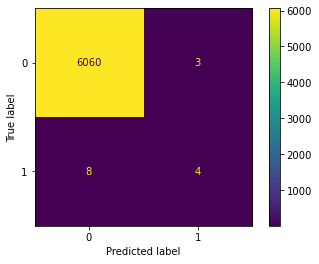

In [31]:
plot_confusion_matrix(fittedgrid_class, X_test, y_test_class);

As you can see above, we have a significant class imbalance! Therefore, using accuracy to evaluate model performance is misleading and we will need to consider other metrics to for model evaluation. First, lets explore our model predictions from the above ML pipeline created.

In [32]:
# Get prediction values
proba_class = fittedgrid_class.predict_proba(X_test)[:,1]
prediction_class = fittedgrid_class.predict(X_test)

# Display Classification Report
class_report = classification_report(y_test_class, prediction_class)
print(class_report)

# Build a df
proba_class_df = pd.DataFrame(proba_class, columns=["Probability of MVP"], index=df_test.index)

# Add player and year columns
results_df_class = pd.concat([df_test[['Year','Player']], proba_class_df], axis=1)

# Create a filter to extract the maximum share of MVP votes in each calendar year
max_proba_per_year = results_df_class.groupby('Year')["Probability of MVP"].idxmax()

# Apply filter
results_df_class = results_df_class.loc[max_proba_per_year]
results_df_class

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6063
           1       0.57      0.33      0.42        12

    accuracy                           1.00      6075
   macro avg       0.79      0.67      0.71      6075
weighted avg       1.00      1.00      1.00      6075



Year                 Player  Probability of MVP
12502  2011           LeBron James            0.305949
12863  2012           LeBron James            0.568132
13552  2013           LeBron James            0.653872
13640  2014           Kevin Durant            0.446960
14474  2015          Stephen Curry            0.863149
14958  2016          Stephen Curry            0.653872
15017  2017          Kawhi Leonard            0.305949
15707  2018           James Harden            0.288460
16225  2019  Giannis Antetokounmpo            0.288460
16590  2020           LeBron James            0.055287
17327  2021           Nikola Jokić            0.088853
17965  2022           Nikola Jokić            0.063036

The default threshold on the classification model is 0.5 and, as expected, we have a lower recall and high precision for the class 1 predictions (**precision = 0.57, recall = 0.33**). Despite this, we were able to correctly predict the the 2022 NBA MVP winner - Nikola Jokic. However, in addition to predicting the 2022 NBA MVP,  the objective is for the model to identify players that would be of deserving of the award from previous years. <br>
Looking at the above probabilities, the lowest probability in each NBA season is in 2020, where Lebron James had the highest probability (0.055287) on becoming the NBA MVP. Therefore, to ensure we classify at least 1 MVP candidate from 2010, we will set our threshold at 0.055287 to capture NBA MVP predictions for the last 12 seasons. With this low threshold, we will reduce precision and increase recall as these 2 metrics are usually a trade-off with one another. <br>

Firstly, let us proceed with plotting the precision and recall scores at various threshold amounts. 

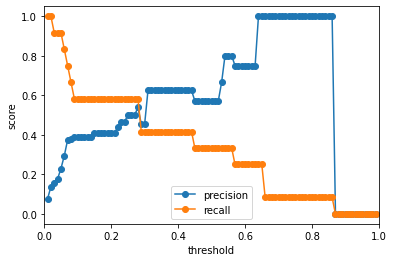

In [33]:
# Vary thresholds by 0.05 from 0.05 to 0.95
thresholds = np.arange(0.01, 1, 0.01)

precisions = list()
recalls = list()

for threshold in thresholds:

    # Apply threshold
    y_threshold = np.where(proba_class > threshold, 1, 0)
    
    # Calculate precision and recall
    precision = precision_score(y_test_class, y_threshold)
    recall = recall_score(y_test_class, y_threshold)
    
    # Append to list
    precisions.append(precision)
    recalls.append(recall)

# Visualize the result
plt.figure()
plt.plot(thresholds, precisions, label='precision', marker='o')
plt.plot(thresholds, recalls, label='recall', marker='o')
plt.xlim(0, 1)
plt.xlabel('threshold')
plt.ylabel('score')
plt.legend()
plt.show()

To optimize for recall and precision, we would need to target ~ 0.23 threshold. However, the goal here is to predict the NBA MVP Winner and also identify other suitable candidates from previous years. Therefore, we would need to lower our threshold to 0.055287 to ensure our model can predict at least 1 MVP winner from each season

In [34]:
# Create new threshold
threshold = 0.055287 - 0.000001 

# If the probability that a data point belongs to the positive class is greater than 0.01328, 
# it gets classified as 1; otherwise, it gets classified as 0
y_pred = np.where(proba_class >= threshold, 1, 0)

class_df_threshold = classification_report(y_test_class, y_pred)
print(f"Classification report for a threshold of {threshold} \n")
print(class_df_threshold)

# Build a df
prob_class_thresh = pd.DataFrame(y_pred, columns=["MVP Prediction"], index=df_test.index)

# Add player and year columns
prob_class_thresh = pd.concat([df_test[['Year','Player']], prob_class_thresh], axis=1)

# Filter out MVPs
prob_class_thresh = prob_class_thresh[prob_class_thresh["MVP Prediction"] == 1]

# Add probabilities from model
prob_class_thresh['Probability of MVP'] = proba_class_df.loc[prob_class_thresh.index]

# Sort the dataframe based on Year and Probability
prob_class_thresh.sort_values(["Year", "Probability of MVP"], axis = 0, ascending = True,
               inplace = True, na_position = "first")

# Preview df
prob_class_thresh

Classification report for a threshold of 0.055286 

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      6063
           1       0.23      0.83      0.36        12

    accuracy                           0.99      6075
   macro avg       0.62      0.91      0.68      6075
weighted avg       1.00      0.99      1.00      6075



Year                 Player  MVP Prediction  Probability of MVP
12373  2011              Pau Gasol               1            0.066606
12504  2011            Dwyane Wade               1            0.066703
12442  2011           Derrick Rose               1            0.073457
12365  2011          Dwight Howard               1            0.142902
12502  2011           LeBron James               1            0.305949
12958  2012           Kevin Durant               1            0.066703
12862  2012            Dwyane Wade               1            0.078801
12863  2012           LeBron James               1            0.568132
13171  2013             Chris Paul               1            0.214390
13192  2013           Kevin Durant               1            0.634682
13552  2013           LeBron James               1            0.653872
13671  2014             Kevin Love               1            0.063036
13751  2014             Chris Paul               1            0.066703
14014  2014           LeBron James               1            0.089251
13640  2014           Kevin Durant               1            0.446960
14313  2015           James Harden               1            0.058537
14360  2015             Chris Paul               1            0.527390
14474  2015          Stephen Curry               1            0.863149
14544  2016           LeBron James               1            0.241998
14901  2016      Russell Westbrook               1            0.273679
14889  2016           Kevin Durant               1            0.305949
14582  2016          Kawhi Leonard               1            0.530857
14958  2016          Stephen Curry               1            0.653872
15137  2017           Jimmy Butler               1            0.056649
15179  2017          Stephen Curry               1            0.066703
15183  2017           Kevin Durant               1            0.066703
15072  2017           James Harden               1            0.226969
15017  2017          Kawhi Leonard               1            0.305949
15716  2018             Chris Paul               1            0.055287
15962  2018           Kevin Durant               1            0.055287
15969  2018          Stephen Curry               1            0.055287
15524  2018           LeBron James               1            0.063036
15707  2018           James Harden               1            0.288460
16050  2019          Stephen Curry               1            0.055287
16043  2019           Kevin Durant               1            0.066703
16172  2019            Rudy Gobert               1            0.070389
16314  2019           James Harden               1            0.088853
16225  2019  Giannis Antetokounmpo               1            0.288460
16590  2020           LeBron James               1            0.055287
17412  2021  Giannis Antetokounmpo               1            0.055287
17474  2021          Kawhi Leonard               1            0.055287
17327  2021           Nikola Jokić               1            0.088853
17965  2022           Nikola Jokić               1            0.063036

With a 0.055287 threshold, our model is able to predict NBA MVPs from each calendar year and we have correctly predicted Nikola Jokic as the 2022 NBA MVP Winner! However, with the low threshold, we have introduced more false positives i.e Kawhi Leonard and Giannis Antetokounmpo in 2021, to capture MVP prediction. Given that the goal of this project is to predict the 2022 NBA MVP Winner and evaluate other candidates deserving of the award, we are tolerant of introducing false positives in our model predictions. To truly understand our model performance, lets evaluate our AUC score on this model. 

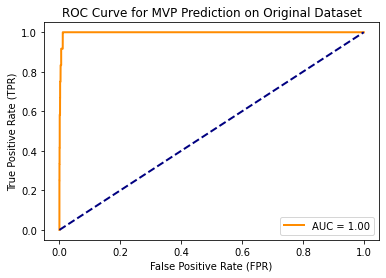

Area under curve (AUC):0.9977046566606191



In [35]:
## Plot AUC Curve ##

# Assign False positive rates, True positive rates and threholds from the ROC Curves
fprs, tprs, thresholds = roc_curve(y_test_class, proba_class)

# Determine AUC Score
roc_auc = roc_auc_score(y_test_class, proba_class)

# Plot Curve
plt.figure()
plt.plot(fprs, tprs, color='darkorange',
         lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for MVP Prediction on Original Dataset')
plt.legend(loc="best")
plt.show()

print(f'Area under curve (AUC):{roc_auc}')
print()

We have a really high AUC score! This is great! This means at very low thresholds, our classifier is significantly better at distinguishing between the true positives and true negatives. However, as we saw earlier with the low threshold, we introduced far more false positives than we would like. To potentially improve our model, we can "upsample" the minority class. This entails us resampling the observations that belong to "class 1" so that our training data has a relatively equal distribution between the 2 classes.

#### Classification Model (Upsampled Dataset) <a id="2.2.2"></a>

In [36]:
# Upsample our Training data

X_class_upsampled, y_class_upsampled = resample(X_train[y_train_class == 1], 
                                    y_train_class[y_train_class == 1], 
                                    replace=True, 
                                    n_samples=X_train[y_train_class == 0].shape[0], # the number majority-class rows
                                    random_state=random_state_val)

print('Number of class 1 examples before:', X_train[y_train_class == 1].shape[0])
print('Number of class 1 examples after:', X_class_upsampled.shape[0])
print('Number of class 0 examples:', X_train[y_train_class == 0].shape[0])

Number of class 1 examples before: 30
Number of class 1 examples after: 11696
Number of class 0 examples: 11696


In [37]:
# Combine upsample with original data
X_train_bal = np.vstack((X_train[y_train_class == 0], X_class_upsampled))
y_train_bal = np.hstack((y_train_class[y_train_class == 0], y_class_upsampled))

In [38]:
#GridSearch 
grid_up_class = GridSearchCV(pipe, param_grid, verbose=5, n_jobs=-1, cv=3)

#Fit the model 
fittedgrid_up_class = grid_up_class.fit(X_train_bal, y_train_bal)

Fitting 3 folds for each of 192 candidates, totalling 576 fits

[CV 1/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.7, model__max_depth=3, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.997 total time=   2.8s
[CV 2/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, cols

              validate_parameters=None, verbosity=None), model__learning_rate=0.7, model__max_depth=9, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.997 total time=   1.0s
[CV 2/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.7, model__max_depth=5, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.998 

              validate_parameters=None, verbosity=None), model__learning_rate=0.7, model__max_depth=8, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.997 total time=   5.4s
[CV 3/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.7, model__max_depth=5, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.998

[CV 1/3] END model=RandomForestClassifier(), model__max_depth=2, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.997 total time=   0.2s
[CV 1/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.7, model__max_depth=5, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.997 total time=   5.3s
[CV 1/3] END model

[CV 1/3] END model=RandomForestClassifier(), model__max_depth=2, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.997 total time=   1.5s
[CV 1/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.7, model__max_depth=9, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.997 total time=   3.1s
[CV 2/3] END model

              validate_parameters=None, verbosity=None), model__learning_rate=0.0001, model__max_depth=4, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.995 total time=   2.0s
[CV 2/3] END model=RandomForestClassifier(), model__max_depth=2, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.997 total time=   0.2s
[CV 3/3] END model=RandomForestClassifier(), model__max_depth=2, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.997 total time=   0.2s
[CV 1/3] END model=RandomForestClassifier(), model__max_depth=2, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.997 total time=   0.9s
[CV 2/3] END model=RandomForestClassifier(), model__max_depth=2, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.997 total time=   0.7s
[CV 3/3] END model=RandomForestClassifier(), model__max_depth=2, model__n_estimators=50, 

              validate_parameters=None, verbosity=None), model__learning_rate=0.0001, model__max_depth=5, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.993 total time=   2.2s
[CV 3/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.0001, model__max_depth=4, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.993 

              validate_parameters=None, verbosity=None), model__learning_rate=0.0001, model__max_depth=8, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.995 total time=   2.8s
[CV 3/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.7, model__max_depth=9, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.9

              validate_parameters=None, verbosity=None), model__learning_rate=0.0001, model__max_depth=2, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.989 total time=  10.1s
[CV 3/3] END model=RandomForestClassifier(), model__max_depth=2, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.997 total time=   1.6s
[CV 1/3] END model=RandomForestClassifier(), model__max_depth=3, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.997 total time=   1.6s
[CV 2/3] END model=RandomForestClassifier(), model__max_depth=4, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.998 total time=   1.0s
[CV 3/3] END model=RandomForestClassifier(), model__max_depth=4, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.998 total time=   1.8s
[CV 1/3] END model=RandomForestClassifier(), model__max_depth=5, model__n_estimators=

              validate_parameters=None, verbosity=None), model__learning_rate=0.0001, model__max_depth=4, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.993 total time=  15.8s
[CV 2/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.0001, model__max_depth=5, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.995

              validate_parameters=None, verbosity=None), model__learning_rate=0.0001, model__max_depth=8, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.995 total time=  12.5s
[CV 2/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.0001, model__max_depth=5, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.995 

              validate_parameters=None, verbosity=None), model__learning_rate=0.001, model__max_depth=3, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.990 total time=   1.4s
[CV 1/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.0001, model__max_depth=9, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.995 t

              validate_parameters=None, verbosity=None), model__learning_rate=0.001, model__max_depth=5, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.995 total time=   2.1s
[CV 1/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.0001, model__max_depth=3, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.992 

              validate_parameters=None, verbosity=None), model__learning_rate=0.001, model__max_depth=2, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.988 total time=  10.4s
[CV 2/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.0001, model__max_depth=8, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.996 

              validate_parameters=None, verbosity=None), model__learning_rate=0.001, model__max_depth=2, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.989 total time=   5.2s
[CV 3/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.001, model__max_depth=3, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.990 to

              validate_parameters=None, verbosity=None), model__learning_rate=0.001, model__max_depth=6, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.993 total time=  10.1s
[CV 2/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.001, model__max_depth=3, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.994 to

              validate_parameters=None, verbosity=None), model__learning_rate=0.01, model__max_depth=2, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.990 total time=   1.3s
[CV 3/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.001, model__max_depth=5, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.993 tot

              validate_parameters=None, verbosity=None), model__learning_rate=0.001, model__max_depth=9, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.995 total time=   3.0s
[CV 2/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.001, model__max_depth=9, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.996 to

              validate_parameters=None, verbosity=None), model__learning_rate=0.01, model__max_depth=4, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.995 total time=  15.2s
[CV 2/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.01, model__max_depth=2, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.988 tot

              validate_parameters=None, verbosity=None), model__learning_rate=0.01, model__max_depth=5, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.995 total time=   2.0s
[CV 3/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.001, model__max_depth=2, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.989 to

              validate_parameters=None, verbosity=None), model__learning_rate=0.001, model__max_depth=9, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.995 total time=  28.4s
[CV 2/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.001, model__max_depth=6, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.995 

              validate_parameters=None, verbosity=None), model__learning_rate=0.01, model__max_depth=3, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.990 total time=   1.6s
[CV 1/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.01, model__max_depth=2, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.990 tot

              validate_parameters=None, verbosity=None), model__learning_rate=0.01, model__max_depth=8, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.996 total time=  25.7s
[CV 3/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.01, model__max_depth=5, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.995 tot

              validate_parameters=None, verbosity=None), model__learning_rate=0.01, model__max_depth=8, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.995 total time=  11.5s
[CV 1/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.993 tot

              validate_parameters=None, verbosity=None), model__learning_rate=0.1, model__max_depth=2, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.995 total time=  10.1s
[CV 3/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.01, model__max_depth=5, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.993 tota

              validate_parameters=None, verbosity=None), model__learning_rate=0.01, model__max_depth=9, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.995 total time=   3.4s
[CV 3/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.01, model__max_depth=9, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.995 tota

              validate_parameters=None, verbosity=None), model__learning_rate=0.1, model__max_depth=4, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.997 total time=  16.5s
[CV 1/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.01, model__max_depth=8, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.995 tot

              validate_parameters=None, verbosity=None), model__learning_rate=0.1, model__max_depth=4, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.999 total time=  16.7s
[CV 2/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.1, model__max_depth=3, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.995 total

              validate_parameters=None, verbosity=None), model__learning_rate=0.1, model__max_depth=7, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.995 total time=   2.7s
[CV 2/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.1, model__max_depth=5, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.998 total 

              validate_parameters=None, verbosity=None), model__learning_rate=0.3, model__max_depth=2, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.993 total time=   1.2s
[CV 2/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.1, model__max_depth=7, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.996 total 

              validate_parameters=None, verbosity=None), model__learning_rate=0.3, model__max_depth=2, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.998 total time=   9.8s
[CV 2/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.01, model__max_depth=9, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.996 tota

              validate_parameters=None, verbosity=None), model__learning_rate=0.1, model__max_depth=6, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.998 total time=  20.6s
[CV 3/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.1, model__max_depth=5, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.997 total

              validate_parameters=None, verbosity=None), model__learning_rate=0.1, model__max_depth=9, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.998 total time=  22.6s
[CV 1/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.1, model__max_depth=7, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.996 tota

              validate_parameters=None, verbosity=None), model__learning_rate=0.3, model__max_depth=6, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.999 total time=   9.4s
[CV 3/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.3, model__max_depth=3, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.998 total 

              validate_parameters=None, verbosity=None), model__learning_rate=0.3, model__max_depth=6, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.997 total time=   9.2s
[CV 2/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.3, model__max_depth=2, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.994 total 

              validate_parameters=None, verbosity=None), model__learning_rate=0.3, model__max_depth=5, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.997 total time=  13.7s
[CV 1/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.3, model__max_depth=3, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.996 total

              validate_parameters=None, verbosity=None), model__learning_rate=0.3, model__max_depth=6, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.998 total time=  10.2s
[CV 3/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.3, model__max_depth=6, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.998 total

              validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=3, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.996 total time=   1.8s
[CV 2/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.3, model__max_depth=6, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.999 total

              validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=3, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.997 total time=   6.4s
[CV 1/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.3, model__max_depth=6, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.997 total

              validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=3, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.997 total time=  10.7s
[CV 1/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.3, model__max_depth=7, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.996 total

              validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=3, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.998 total time=  11.4s
[CV 1/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=4, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.998 total

              validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=8, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.999 total time=  13.2s
[CV 2/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=3, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.997 total

              validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=6, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.998 total time=   7.9s
[CV 1/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=4, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.997 total 

              validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=8, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.998 total time=   2.4s
[CV 1/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=4, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.998 total

              validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=9, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.999 total time=   8.0s
[CV 3/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=9, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.997 total 

              validate_parameters=None, verbosity=None), model__learning_rate=0.7, model__max_depth=3, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.998 total time=  11.2s
[CV 1/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=7, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.998 total

              validate_parameters=None, verbosity=None), model__learning_rate=0.7, model__max_depth=3, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.997 total time=  11.4s
[CV 3/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=8, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.997 total

In [39]:
print(f" XGB model Test Score: {fittedgrid_up_class.score(X_test,y_test_class)}")
print(f" XGB model Train Score: {fittedgrid_up_class.score(X_train_bal,y_train_bal)}")                                       

 XGB model Test Score: 0.9978600823045267
 XGB model Train Score: 1.0


In [40]:
fittedgrid_up_class.best_estimator_

Pipeline(steps=[('normalise', StandardScaler()),
                ('model',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.7,
                               max_delta_step=0, max_depth=7,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=50,
                               n_jobs=0, num_parallel_tree=1, random_state=123,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

Our best classifier is the XGBClassifier with a **max_depth** of 7, **learning rate** of 0.7 and **n_estimators** of 50. In terms of training and test scores, we have similar model results in comparison with the imbalanced dataset. Lets display the confusion matrix to evaluate false positives and false negatives on the imbalanced and upsampled datasets. 

Text(0.5, 1.0, 'Upsampled Confusion Matrix')

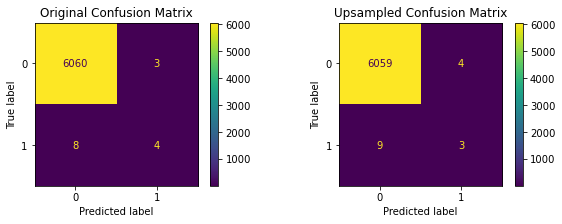

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

plot_confusion_matrix(fittedgrid_class, X_test, y_test_class, ax=axes[0])
axes[0].set_title('Original Confusion Matrix')

plot_confusion_matrix(fittedgrid_up_class, X_test, y_test_class, ax = axes[1])
axes[1].set_title('Upsampled Confusion Matrix')

The upsampled dataset hasnt really addressed the class imbalanced when analyzing the confusion matrix. We still have quite an imbalanced dataset with a significant share of the votes in the 0 class. Regardless, lets proceed to analyze model predictions with the new dataset.

In [42]:
# Get prediction values
proba_up_class = fittedgrid_up_class.predict_proba(X_test)[:,1]
prediction_up_class = fittedgrid_up_class.predict(X_test)

# Display Classification Report
up_class_report = classification_report(y_test_class, prediction_up_class)
print(up_class_report)

# Build a df
proba_up_class_df = pd.DataFrame(proba_up_class, columns=["Probability of MVP"], index=df_test.index)

# Add player and year columns
results_df_up_class = pd.concat([df_test[['Year','Player']], proba_up_class_df], axis=1)

# Create a filter to extract the maximum share of MVP votes in each calendar year
max_up_proba_per_year = results_df_up_class.groupby('Year')["Probability of MVP"].idxmax()

# Apply filter
results_df_up_class = results_df_up_class.loc[max_up_proba_per_year]
results_df_up_class

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6063
           1       0.43      0.25      0.32        12

    accuracy                           1.00      6075
   macro avg       0.71      0.62      0.66      6075
weighted avg       1.00      1.00      1.00      6075



Year                 Player  Probability of MVP
12502  2011           LeBron James            0.999291
12863  2012           LeBron James            0.033179
13552  2013           LeBron James            0.998391
13640  2014           Kevin Durant            0.969600
14360  2015             Chris Paul            0.944528
14901  2016      Russell Westbrook            0.064082
15183  2017           Kevin Durant            0.025868
15707  2018           James Harden            0.001813
16225  2019  Giannis Antetokounmpo            0.606698
17091  2020  Giannis Antetokounmpo            0.011228
17117  2021         Damian Lillard            0.000404
18007  2022             Chris Paul            0.024627

With a 0.5 threshold on the upsampled dataset, our model predictions have a lower recall, precision and F1-score for the positive class vs imbalanced dataset - therefore, no improvement with respect to scoring metrics on the the upsampled dataset. 

To predict MVP winners and suitable candidates from each season, we will again explore lowering the threhold to cast a wider net and capture more predictions; as such, we will set our threshold at 0.000404 - the lowest probability of a winning MVP from among the past 12 seasons (Damian Lillard in 2021)

In [43]:
# Set Threshold
threshold = 0.000404 - 0.000001

# If the probability that a data point belongs to the positive class is greater than 0.007531, 
# it gets classified as 1; otherwise, it gets classified as 0
y_pred_up = np.where(proba_up_class > threshold, 1, 0)

up_threshold_class_report = classification_report(y_test_class, y_pred_up)
print(f"Classification report for a threshold of {threshold} \n")
print(up_threshold_class_report)

# Build a df
prob_up_class = pd.DataFrame(y_pred_up, columns=["MVP Prediction"], index=df_test.index)

# Add player and year columns
results_up_class = pd.concat([df_test[['Year','Player']], prob_up_class], axis=1)

# Filter out MVPs
results_up_class = results_up_class[results_up_class["MVP Prediction"] == 1]

# Add probabilities from model
results_up_class['Probability of MVP'] = proba_up_class_df.loc[results_up_class.index]

# Sort the dataframe based on Year and Probability
results_up_class.sort_values(["Year", "Probability of MVP"], axis = 0, ascending = True,
               inplace = True, na_position = "first")

# Preview df
results_up_class

Classification report for a threshold of 0.000403 

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      6063
           1       0.21      0.83      0.34        12

    accuracy                           0.99      6075
   macro avg       0.61      0.91      0.67      6075
weighted avg       1.00      0.99      1.00      6075



Year                 Player  MVP Prediction  Probability of MVP
12365  2011          Dwight Howard               1            0.002597
12346  2011             Chris Paul               1            0.008898
12373  2011              Pau Gasol               1            0.010394
12442  2011           Derrick Rose               1            0.278381
12504  2011            Dwyane Wade               1            0.995540
12502  2011           LeBron James               1            0.999291
12645  2012            Rajon Rondo               1            0.001076
12720  2012             Steve Nash               1            0.002173
12863  2012           LeBron James               1            0.033179
13280  2013            Tony Parker               1            0.001266
13171  2013             Chris Paul               1            0.010777
13194  2013      Russell Westbrook               1            0.172980
13192  2013           Kevin Durant               1            0.974496
13552  2013           LeBron James               1            0.998391
13879  2014            Joakim Noah               1            0.000451
13751  2014             Chris Paul               1            0.042257
14014  2014           LeBron James               1            0.052803
13758  2014          Blake Griffin               1            0.229067
13640  2014           Kevin Durant               1            0.969600
14474  2015          Stephen Curry               1            0.003587
14431  2015           LeBron James               1            0.007266
14360  2015             Chris Paul               1            0.944528
14889  2016           Kevin Durant               1            0.002489
14958  2016          Stephen Curry               1            0.005734
14954  2016         Draymond Green               1            0.006386
14544  2016           LeBron James               1            0.006798
14582  2016          Kawhi Leonard               1            0.010522
14901  2016      Russell Westbrook               1            0.064082
15034  2017       Boban Marjanović               1            0.000457
15457  2017             Kyle Lowry               1            0.000616
15240  2017            Rudy Gobert               1            0.001385
15107  2017      Russell Westbrook               1            0.001969
15189  2017         Draymond Green               1            0.003529
15017  2017          Kawhi Leonard               1            0.004452
15072  2017           James Harden               1            0.004969
15183  2017           Kevin Durant               1            0.025868
15734  2018           Kyrie Irving               1            0.000445
16038  2018          Anthony Davis               1            0.000589
15716  2018             Chris Paul               1            0.000686
15707  2018           James Harden               1            0.001813
16564  2019          Anthony Davis               1            0.000626
16217  2019           Trevon Duval               1            0.000934
16225  2019  Giannis Antetokounmpo               1            0.606698
16590  2020           LeBron James               1            0.000995
17091  2020  Giannis Antetokounmpo               1            0.011228
17117  2021         Damian Lillard               1            0.000404
18007  2022             Chris Paul               1            0.024627

Again, with the 0.000404 threshold, we were able to substantially increase recall from **0.25** to **0.83** on the upsampled dataset - rhis is the same recall score as the XGB Regressor model on the original dataset run with a 0.055287 threshold! On this model as well, we have introduced a significant number of false positives, which is acceptable as we can now view potential MVP candidates from each season.  

Let us evaluate another metric - AUC - for further model evaluation.

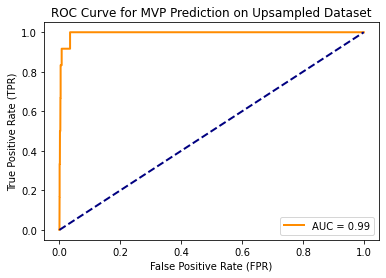

Area under curve (AUC):0.9948457859145637



In [44]:
## Plot AUC Curve ##

# Assign False positive rates, True positive rates and threholds from the ROC Curves
up_fprs, up_tprs, up_thresholds = roc_curve(y_test_class, proba_up_class)

# Determine AUC Score
up_roc_auc = roc_auc_score(y_test_class, proba_up_class)

plt.figure()
plt.plot(up_fprs, up_tprs, color='darkorange',
         lw=2, label='AUC = %0.2f' % up_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for MVP Prediction on Upsampled Dataset')
plt.legend(loc="best")
plt.show()

print(f'Area under curve (AUC):{up_roc_auc}')
print()

AUC score on the XGB Regressor on the upsampled dataset is slightly lower than on the XGB classifier on the original dataset model. At lower threshold, the Upsampled Model will classify positive classes over negative classes at a lower percentage relative to the Original Dataset Model. 

We will compare the upsampled and imabalanced further on this notebook; in the meantime, let's explore further regression and classification models using deep neural networks and see if we can generate better model performance. 

### Keras Regressor <a id="2.3"></a>

Similar to the bagging / boosting models, we will proceed with a neural network regressor and evaluate our model performance & predictions.

We will first create a function that develops a model (required for KerasRegressor) and a Machine learning pipeline to tune the following hyperparamters:
- **Units**: (10, 50, 100)
- **Learning Rate**: (0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7)
- **Dropout**: (0.1, 0.2, 0.5, 0.8)

In [45]:
# Create function
def create_model(unit, learning_rate, drop_out):
    model = keras.Sequential()
    model.add(layers.Dense(unit, activation="relu"))
    model.add(layers.Dropout(drop_out))
    model.add(layers.BatchNormalization()) 
    
    model.add(layers.Dense(unit, activation="relu"))
    model.add(layers.Dropout(drop_out))
    model.add(layers.BatchNormalization()) 
    
    model.add(layers.Dense(unit, activation="relu"))
    model.add(layers.Dropout(drop_out))
    model.add(layers.BatchNormalization()) 

    # Declare the output layer
    model.add(layers.Dense(1))
    
    # compile model
    model.compile(loss = 'MeanSquaredError',
                  optimizer = keras.optimizers.Adam(learning_rate = learning_rate),
                  metrics = ['accuracy'])

    return model

In [46]:
# Create regressor model
keras_regressor = KerasRegressor(build_fn=create_model, verbose=1)

# Specify estimators
estimators = [('normalise', StandardScaler()),
              ('model', keras_regressor)]

# Develop hyperparameter grid
param_grid = {'normalise': [StandardScaler()],
              'model__unit': [100],              
              'model__epochs': [10,50,100],
              'model__learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7],
              'model__drop_out': [0.1, 0.2, 0.5, 0.8],
              'model__callbacks' : [EarlyStopping(monitor='loss', patience=5)]
             
             }

# Develop Pipeline
pipe = Pipeline(estimators)

# Develop GridSearch
DNN_grid = GridSearchCV(estimator=pipe, param_grid=param_grid, cv = 3,
                    return_train_score = True, n_jobs=-1, verbose=1)

# Fit the model
DNN_grid_result = DNN_grid.fit(X_train, y_train_num)

Fitting 3 folds for each of 84 candidates, totalling 252 fits

[CV 3/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=9, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.997 total time=  12.9s
[CV 3/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_

245/245 [==============================] - 10s 12ms/step - loss: 0.9041 - accuracy: 0.6719
Epoch 2/10
245/245 [==============================] - 3s 11ms/step - loss: 0.5986 - accuracy: 0.7205loss: 0.7693 - accuracy: 0.67245 [===========>..................] - ETA: 1s - loss: 0.6101 - accuracy: 0. 0s - loss: 0.6134 - accuracy: 0.7145 [======================>.......] - ETA: 0s - loss: 0.1180 - accuracy: 0.
Epoch 3/10
245/245 [==============================] - 3s 11ms/step - loss: 0.5653 - accuracy: 0.7166
Epoch 3/10
245/245 [=====>........................] - ETA: 2s - loss: 0.4798 - accuracy: 0.75378 - accuracy: 0.70 [==============================] - 3s 11ms/step - loss: 0.6383 - accuracy: 0.7055
Epoch 3/10
245/245 [==============================] - 3s 12ms/step - loss: 0.4446 - accuracy: 0.7446
Epoch 4/10
245/245 [==============================] - 3s 12ms/step - loss: 0.4954 - accuracy: 0.7297........] - ETA: 2s - loss: 0.3754 - accuracy: 0.74
Epoch 4/10
245/245 [=======================

245/245 [==============================] - 2s 10ms/step - loss: 0.0028 - accuracy: 0.9621
Epoch 4/10
245/245 [==============================] - 3s 11ms/step - loss: 0.0125 - accuracy: 0.9539
Epoch 5/10
245/245 [==============================] - 3s 12ms/step - loss: 0.0095 - accuracy: 0.9500
Epoch 5/10
245/245 [==============================] - 3s 12ms/step - loss: 0.0027 - accuracy: 0.9621
Epoch 5/10
245/245 [==============================] - 3s 12ms/step - loss: 0.0045 - accuracy: 0.9541
Epoch 6/10
245/245 [==============================] - 3s 13ms/step - loss: 0.0036 - accuracy: 0.9500
Epoch 6/10
245/245 [==============================] - 3s 11ms/step - loss: 0.0022 - accuracy: 0.9500
Epoch 7/10
245/245 [==============================] - 3s 11ms/step - loss: 0.0028 - accuracy: 0.9621
Epoch 7/10
245/245 [==============================] - 3s 11ms/step - loss: 0.0019 - accuracy: 0.9541
Epoch 8/10
245/245 [==============================] - 3s 11ms/step - loss: 0.0019 - accuracy: 0.9500
E

245/245 [==============================] - 18s 10ms/step - loss: 2.1085 - accuracy: 0.8822
Epoch 2/10
245/245 [==============================] - 2s 9ms/step - loss: 0.0018 - accuracy: 0.9500
Epoch 8/10
245/245 [==============================] - 2s 9ms/step - loss: 0.0033 - accuracy: 0.9621
Epoch 3/10
245/245 [==============================] - 2s 9ms/step - loss: 0.0019 - accuracy: 0.9500
Epoch 9/10
245/245 [==============================] - 2s 9ms/step - loss: 0.0053 - accuracy: 0.9620
Epoch 4/10
245/245 [==============================] - 2s 9ms/step - loss: 0.0019 - accuracy: 0.9500
Epoch 10/10
245/245 [==============================] - 2s 9ms/step - loss: 0.0031 - accuracy: 0.9621
Epoch 5/10
245/245 [==============================] - 2s 7ms/step - loss: 0.0032 - accuracy: 0.9621
Epoch 6/10
245/245 [==============================] - 2s 7ms/step - loss: 0.0026 - accuracy: 0.9621
Epoch 7/10
245/245 [==============================] - 2s 8ms/step - loss: 0.0032 - accuracy: 0.9621
Epoch 8/

245/245 [==============================] - 2s 9ms/step - loss: 0.0032 - accuracy: 0.9500
Epoch 8/10
245/245 [==============================] - 3s 11ms/step - loss: 0.2847 - accuracy: 0.9056
Epoch 9/10
245/245 [==============================] - 3s 12ms/step - loss: 0.0237 - accuracy: 0.9614
Epoch 8/10
245/245 [==============================] - 16s 12ms/step - loss: 17.3600 - accuracy: 0.8157
Epoch 2/10
245/245 [==============================] - 3s 12ms/step - loss: 0.0242 - accuracy: 0.9609
Epoch 9/10
245/245 [==============================] - 3s 12ms/step - loss: 0.0027 - accuracy: 0.9541
Epoch 3/10
245/245 [==============================] - 17s 11ms/step - loss: 9.3158 - accuracy: 0.8236
Epoch 2/10
245/245 [==============================] - 3s 11ms/step - loss: 0.0290 - accuracy: 0.9600
Epoch 10/10
245/245 [==============================] - 3s 11ms/step - loss: 0.0033 - accuracy: 0.9538
Epoch 4/10
245/245 [==============================] - 3s 11ms/step - loss: 259.5731 - accuracy: 0.5

245/245 [==============================] - 3s 13ms/step - loss: 0.2494 - accuracy: 0.8078
Epoch 9/50
245/245 [==============================] - 3s 12ms/step - loss: 0.0023 - accuracy: 0.9621
Epoch 7/50
245/245 [==============================] - 3s 13ms/step - loss: 0.1509 - accuracy: 0.8634
Epoch 15/50
245/245 [==============================] - 3s 13ms/step - loss: 0.0988 - accuracy: 0.9106
Epoch 17/50
245/245 [==============================] - 3s 14ms/step - loss: 0.0018 - accuracy: 0.9621
Epoch 8/50
245/245 [==============================] - 3s 13ms/step - loss: 0.1348 - accuracy: 0.8804
Epoch 16/50
245/245 [==============================] - 3s 13ms/step - loss: 0.1962 - accuracy: 0.8347
Epoch 11/50
245/245 [==============================] - 3s 13ms/step - loss: 0.0841 - accuracy: 0.9236
Epoch 18/50
245/245 [==============================] - 3s 11ms/step - loss: 0.0018 - accuracy: 0.9621
Epoch 9/50
245/245 [==============================] - 3s 11ms/step - loss: 0.1151 - accuracy: 0.8

245/245 [==============================] - 3s 12ms/step - loss: 0.0053 - accuracy: 0.9621
Epoch 33/50
245/245 [==============================] - 3s 12ms/step - loss: 0.0184 - accuracy: 0.9497
Epoch 26/50
245/245 [==============================] - 3s 12ms/step - loss: 0.0017 - accuracy: 0.9621
Epoch 23/50
245/245 [==============================] - 3s 12ms/step - loss: 0.0093 - accuracy: 0.9541
Epoch 32/50
245/245 [==============================] - 3s 13ms/step - loss: 0.0147 - accuracy: 0.9496
Epoch 27/50
245/245 [==============================] - 3s 12ms/step - loss: 0.0017 - accuracy: 0.9621
Epoch 24/50
245/245 [==============================] - 3s 12ms/step - loss: 0.0072 - accuracy: 0.9541
Epoch 33/50
245/245 [==============================] - 3s 12ms/step - loss: 0.0119 - accuracy: 0.9500
Epoch 28/50
245/245 [==============================] - 3s 13ms/step - loss: 0.0016 - accuracy: 0.9621
Epoch 25/50
245/245 [==============================] - 3s 12ms/step - loss: 0.0028 - accuracy:

245/245 [==============================] - 3s 13ms/step - loss: 0.0017 - accuracy: 0.9500
Epoch 42/50
245/245 [==============================] - 3s 12ms/step - loss: 0.0016 - accuracy: 0.9541
Epoch 48/50
245/245 [==============================] - 3s 12ms/step - loss: 0.0016 - accuracy: 0.9621
Epoch 50/50
245/245 [==============================] - 3s 13ms/step - loss: 0.0013 - accuracy: 0.9621
Epoch 40/50
245/245 [==============================] - 3s 11ms/step - loss: 0.0016 - accuracy: 0.9500
Epoch 44/50
245/245 [==============================] - 3s 12ms/step - loss: 0.0013 - accuracy: 0.9621
Epoch 41/50
245/245 [==============================] - 2s 9ms/step - loss: 0.0016 - accuracy: 0.9541
Epoch 50/50
245/245 [==============================] - 2s 9ms/step - loss: 0.0016 - accuracy: 0.9500
Epoch 45/50
245/245 [==============================] - 2s 9ms/step - loss: 0.0016 - accuracy: 0.9500
Epoch 46/50
245/245 [==============================] - 2s 9ms/step - loss: 0.0011 - accuracy: 0.9

245/245 [==============================] - 3s 11ms/step - loss: 0.0033 - accuracy: 0.9621
Epoch 6/50
245/245 [==============================] - 3s 11ms/step - loss: 0.0026 - accuracy: 0.9541
Epoch 5/50
245/245 [==============================] - 3s 11ms/step - loss: 0.0017 - accuracy: 0.9500
Epoch 18/50
245/245 [==============================] - 3s 11ms/step - loss: 0.0030 - accuracy: 0.9621
Epoch 7/50
245/245 [==============================] - 3s 11ms/step - loss: 0.0027 - accuracy: 0.9541
Epoch 6/50
245/245 [==============================] - 3s 11ms/step - loss: 0.0017 - accuracy: 0.9500
Epoch 19/50
245/245 [==============================] - 3s 11ms/step - loss: 0.0028 - accuracy: 0.9621
Epoch 8/50
245/245 [==============================] - 3s 10ms/step - loss: 0.0028 - accuracy: 0.9541
Epoch 7/50
245/245 [==============================] - 3s 11ms/step - loss: 0.0016 - accuracy: 0.9500
Epoch 20/50
245/245 [==============================] - 3s 10ms/step - loss: 0.0028 - accuracy: 0.962

245/245 [==============================] - 3s 14ms/step - loss: 0.0012 - accuracy: 0.9500
Epoch 39/50
245/245 [==============================] - 3s 14ms/step - loss: 0.0026 - accuracy: 0.9541
Epoch 3/50
245/245 [==============================] - 3s 14ms/step - loss: 0.0012 - accuracy: 0.9621
Epoch 28/50
245/245 [==============================] - 3s 14ms/step - loss: 0.0020 - accuracy: 0.9621
Epoch 10/50
245/245 [==============================] - 3s 14ms/step - loss: 0.0012 - accuracy: 0.9500
Epoch 40/50
245/245 [==============================] - 3s 14ms/step - loss: 0.0025 - accuracy: 0.9541
Epoch 4/50
245/245 [==============================] - 3s 14ms/step - loss: 0.0019 - accuracy: 0.9621
Epoch 11/50
245/245 [==============================] - 3s 14ms/step - loss: 0.0010 - accuracy: 0.9500
Epoch 41/50
245/245 [==============================] - 3s 13ms/step - loss: 0.0026 - accuracy: 0.9541
Epoch 5/50
245/245 [==============================] - 3s 14ms/step - loss: 0.0019 - accuracy: 0.

245/245 [==============================] - 2s 7ms/step - loss: 22962.5000 - accuracy: 0.9616
Epoch 1/50
245/245 [==============================] - 11s 7ms/step - loss: 1.4940 - accuracy: 0.8731
Epoch 2/50
245/245 [==============================] - 2s 7ms/step - loss: 0.0039 - accuracy: 0.9541
Epoch 3/50
245/245 [==============================] - 2s 8ms/step - loss: 0.0037 - accuracy: 0.9541
Epoch 4/50
245/245 [==============================] - 2s 8ms/step - loss: 0.0047 - accuracy: 0.9541
Epoch 5/50
245/245 [==============================] - 2s 8ms/step - loss: 0.0063 - accuracy: 0.9541
Epoch 6/50
245/245 [==============================] - 12s 9ms/step - loss: 2.7321 - accuracy: 0.8534
Epoch 2/50
245/245 [==============================] - 2s 8ms/step - loss: 0.0054 - accuracy: 0.9541
Epoch 7/50
245/245 [==============================] - 2s 8ms/step - loss: 0.0106 - accuracy: 0.9477
Epoch 3/50
245/245 [==============================] - 2s 8ms/step - loss: 0.0047 - accuracy: 0.9541
Epoch

245/245 [==============================] - 3s 12ms/step - loss: 346.6339 - accuracy: 0.9499
Epoch 22/50
245/245 [==============================] - 3s 11ms/step - loss: 0.0142 - accuracy: 0.9621
Epoch 7/50
245/245 [==============================] - 3s 11ms/step - loss: 1012.2585 - accuracy: 0.6932
Epoch 23/50
245/245 [==============================] - 3s 11ms/step - loss: 0.0400 - accuracy: 0.9360
Epoch 11/50
245/245 [==============================] - 3s 11ms/step - loss: 863.8275 - accuracy: 0.9447
Epoch 8/50
245/245 [==============================] - 3s 11ms/step - loss: 0.6533 - accuracy: 0.8935
Epoch 12/50
245/245 [==============================] - 2s 8ms/step - loss: 0.0062 - accuracy: 0.9491+
Epoch 13/50
245/245 [==============================] - 2s 6ms/step - loss: 577337288556544.0000 - accuracy: 7.6756e-04
Epoch 1/50
245/245 [==============================] - 15s 7ms/step - loss: 18.8477 - accuracy: 0.7642
Epoch 2/50
245/245 [==============================] - 2s 8ms/step - loss

245/245 [==============================] - 2s 9ms/step - loss: 0.1727 - accuracy: 0.8575
Epoch 12/100
245/245 [==============================] - 3s 10ms/step - loss: 0.4789 - accuracy: 0.7320
Epoch 5/100
245/245 [==============================] - 3s 10ms/step - loss: 0.0790 - accuracy: 0.9314
Epoch 18/100
245/245 [==============================] - 3s 11ms/step - loss: 0.1502 - accuracy: 0.8711
Epoch 13/100
245/245 [==============================] - 2s 9ms/step - loss: 0.0031 - accuracy: 0.9541
Epoch 4/100
245/245 [==============================] - 2s 9ms/step - loss: 0.0026 - accuracy: 0.9541
Epoch 5/100
245/245 [==============================] - 15s 9ms/step - loss: 0.1888 - accuracy: 0.9280
Epoch 2/100
245/245 [==============================] - 2s 9ms/step - loss: 0.0033 - accuracy: 0.9500
Epoch 3/100
245/245 [==============================] - 2s 9ms/step - loss: 0.0030 - accuracy: 0.9500
Epoch 4/100
245/245 [==============================] - 3s 11ms/step - loss: 0.0025 - accuracy: 0

245/245 [==============================] - 2s 7ms/step - loss: 0.0025 - accuracy: 0.9621
Epoch 17/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0021 - accuracy: 0.9621
Epoch 18/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0022 - accuracy: 0.9621
Epoch 19/100
245/245 [==============================] - 10s 8ms/step - loss: 3.4492 - accuracy: 0.8647
Epoch 2/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0022 - accuracy: 0.9621
Epoch 20/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0040 - accuracy: 0.9499
Epoch 3/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0020 - accuracy: 0.9621
Epoch 21/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0032 - accuracy: 0.9500
Epoch 4/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0020 - accuracy: 0.9621
Epoch 22/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0032 - accuracy: 0.

245/245 [==============================] - 3s 12ms/step - loss: 0.0114 - accuracy: 0.9537: 0.95
Epoch 4/100
245/245 [==============================] - 3s 11ms/step - loss: 6219.8765 - accuracy: 0.6346936
Epoch 14/100
245/245 [==============================] - 3s 11ms/step - loss: 35.0140 - accuracy: 0.83830.941
Epoch 5/100
245/245 [==============================] - 3s 11ms/step - loss: 3.6272 - accuracy: 0.8626
Epoch 15/100
245/245 [==============================] - 3s 10ms/step - loss: 1764.8794 - accuracy: 0.6490
Epoch 6/100
245/245 [==============================] - 2s 10ms/step - loss: 0.3127 - accuracy: 0.9373
Epoch 16/100
245/245 [==============================] - 2s 10ms/step - loss: 0.0215 - accuracy: 0.9534
Epoch 7/100
245/245 [==============================] - 2s 9ms/step - loss: 0.2295 - accuracy: 0.9364
Epoch 8/100
245/245 [==============================] - 17s 8ms/step - loss: 15.6227 - accuracy: 0.6685: 0.953
Epoch 2/100
245/245 [==============================] - 2s 9ms/s

245/245 [==============================] - 2s 8ms/step - loss: 0.0294 - accuracy: 0.9497
Epoch 4/10
245/245 [==============================] - 2s 6ms/step - loss: 0.0069 - accuracy: 0.9541
Epoch 5/10
245/245 [==============================] - 2s 8ms/step - loss: 0.0024 - accuracy: 0.9541
Epoch 6/10
245/245 [==============================] - 2s 9ms/step - loss: 0.0020 - accuracy: 0.9541
Epoch 7/10
245/245 [==============================] - 2s 10ms/step - loss: 0.1284 - accuracy: 0.8795
Epoch 3/10
245/245 [==============================] - 3s 11ms/step - loss: 0.0020 - accuracy: 0.9541
Epoch 8/10
245/245 [==============================] - 3s 10ms/step - loss: 0.0292 - accuracy: 0.9459
Epoch 4/10
245/245 [==============================] - 2s 10ms/step - loss: 0.0019 - accuracy: 0.9541
Epoch 9/10
245/245 [==============================] - 2s 9ms/step - loss: 0.0065 - accuracy: 0.9500
Epoch 5/10
245/245 [==============================] - 2s 8ms/step - loss: 0.0020 - accuracy: 0.9541
Epoch 1

245/245 [==============================] - 2s 9ms/step - loss: 0.0020 - accuracy: 0.9541
Epoch 8/10
245/245 [==============================] - 2s 8ms/step - loss: 0.0024 - accuracy: 0.9500
Epoch 4/10
245/245 [==============================] - 2s 9ms/step - loss: 0.0020 - accuracy: 0.9541
Epoch 9/10
245/245 [==============================] - 2s 9ms/step - loss: 0.0023 - accuracy: 0.9500
Epoch 5/10
245/245 [==============================] - 2s 9ms/step - loss: 0.0021 - accuracy: 0.9541
Epoch 10/10
245/245 [==============================] - 2s 9ms/step - loss: 0.0021 - accuracy: 0.9500
Epoch 6/10
245/245 [==============================] - 2s 8ms/step - loss: 0.0021 - accuracy: 0.9500
Epoch 7/10
245/245 [==============================] - 2s 8ms/step - loss: 0.0019 - accuracy: 0.9500
Epoch 8/10
245/245 [==============================] - 2s 8ms/step - loss: 0.0020 - accuracy: 0.9500
Epoch 10/10
245/245 [==============================] - 12s 7ms/step - loss: 2.4481 - accuracy: 0.8730
Epoch 2/

245/245 [==============================] - 2s 9ms/step - loss: 0.0063 - accuracy: 0.9500
Epoch 7/10
245/245 [==============================] - 2s 7ms/step - loss: 0.0044 - accuracy: 0.9500
Epoch 8/10
245/245 [==============================] - 2s 7ms/step - loss: 0.0053 - accuracy: 0.9500
Epoch 9/10
245/245 [==============================] - 2s 7ms/step - loss: 0.0051 - accuracy: 0.9500
Epoch 10/10
245/245 [==============================] - 10s 7ms/step - loss: 27.5211 - accuracy: 0.7827
Epoch 2/10
245/245 [==============================] - 1s 6ms/step - loss: 10.1078 - accuracy: 0.7248
Epoch 3/10
245/245 [==============================] - 1s 6ms/step - loss: 5.5061 - accuracy: 0.8342
Epoch 4/10
245/245 [==============================] - 1s 6ms/step - loss: 0.0189 - accuracy: 0.9610
Epoch 5/10
245/245 [==============================] - 1s 6ms/step - loss: 0.1205 - accuracy: 0.8947
Epoch 6/10
245/245 [==============================] - 1s 6ms/step - loss: 0.1328 - accuracy: 0.9074
Epoch 7

245/245 [==============================] - 2s 10ms/step - loss: 0.1461 - accuracy: 0.8639
Epoch 13/50
245/245 [==============================] - 3s 12ms/step - loss: 0.0600 - accuracy: 0.9417
Epoch 18/50
245/245 [==============================] - 3s 12ms/step - loss: 0.1250 - accuracy: 0.8836
Epoch 14/50
245/245 [==============================] - 16s 12ms/step - loss: 1.2383 - accuracy: 0.6450
Epoch 2/50
245/245 [==============================] - 3s 12ms/step - loss: 0.0502 - accuracy: 0.9477
Epoch 19/50
245/245 [==============================] - 3s 12ms/step - loss: 0.8126 - accuracy: 0.6754
Epoch 3/50
245/245 [==============================] - 3s 11ms/step - loss: 0.0859 - accuracy: 0.9162
Epoch 16/50
245/245 [==============================] - 3s 11ms/step - loss: 0.6702 - accuracy: 0.7008
Epoch 4/50
245/245 [==============================] - 3s 11ms/step - loss: 0.0316 - accuracy: 0.9580
Epoch 21/50
245/245 [==============================] - 3s 11ms/step - loss: 0.0704 - accuracy: 0

245/245 [==============================] - 3s 12ms/step - loss: 0.0019 - accuracy: 0.9541
Epoch 34/50
245/245 [==============================] - 3s 11ms/step - loss: 0.0218 - accuracy: 0.9490
Epoch 23/50
245/245 [==============================] - 3s 12ms/step - loss: 0.0018 - accuracy: 0.9621
Epoch 40/50
245/245 [==============================] - 3s 12ms/step - loss: 0.0018 - accuracy: 0.9541
Epoch 36/50
245/245 [==============================] - 3s 12ms/step - loss: 0.0167 - accuracy: 0.9495
Epoch 24/50
245/245 [==============================] - 3s 12ms/step - loss: 0.0255 - accuracy: 0.9515
Epoch 4/50
245/245 [==============================] - 3s 12ms/step - loss: 0.0017 - accuracy: 0.9541
Epoch 47/50
245/245 [==============================] - 18s 13ms/step - loss: 0.6184 - accuracy: 0.7242
Epoch 2/50
245/245 [==============================] - 3s 13ms/step - loss: 0.0058 - accuracy: 0.9541
Epoch 5/50
245/245 [==============================] - 3s 14ms/step - loss: 0.1393 - accuracy: 0

245/245 [==============================] - 2s 9ms/step - loss: 0.0027 - accuracy: 0.9621
Epoch 3/50
245/245 [==============================] - 2s 8ms/step - loss: 0.0034 - accuracy: 0.9621
Epoch 4/50
245/245 [==============================] - 2s 9ms/step - loss: 0.0034 - accuracy: 0.9621
Epoch 5/50
245/245 [==============================] - 2s 8ms/step - loss: 0.0035 - accuracy: 0.9621
Epoch 6/50
245/245 [==============================] - 14s 11ms/step - loss: 0.0795 - accuracy: 0.9289
Epoch 2/50
245/245 [==============================] - 3s 12ms/step - loss: 0.0033 - accuracy: 0.9621
Epoch 7/50
245/245 [==============================] - 2s 10ms/step - loss: 0.0029 - accuracy: 0.9541
Epoch 3/50
245/245 [==============================] - 2s 7ms/step - loss: 0.0037 - accuracy: 0.9541
Epoch 4/50
245/245 [==============================] - 2s 6ms/step - loss: 0.0034 - accuracy: 0.9541
Epoch 5/50
245/245 [==============================] - 2s 7ms/step - loss: 0.0034 - accuracy: 0.9541
Epoch 6

245/245 [==============================] - 2s 10ms/step - loss: 0.0022 - accuracy: 0.9500
Epoch 12/50
245/245 [==============================] - 2s 10ms/step - loss: 0.0054 - accuracy: 0.9539
Epoch 3/50
245/245 [==============================] - 2s 10ms/step - loss: 0.0068 - accuracy: 0.9621
Epoch 7/50
245/245 [==============================] - 2s 9ms/step - loss: 0.0023 - accuracy: 0.9500
Epoch 13/50
245/245 [==============================] - 2s 10ms/step - loss: 0.0051 - accuracy: 0.9541
Epoch 4/50
245/245 [==============================] - 2s 9ms/step - loss: 0.0051 - accuracy: 0.9621
Epoch 8/50
245/245 [==============================] - 3s 10ms/step - loss: 0.0066 - accuracy: 0.9621
Epoch 9/50
245/245 [==============================] - 2s 9ms/step - loss: 0.0032 - accuracy: 0.9621
Epoch 10/50
245/245 [==============================] - 2s 8ms/step - loss: 0.0064 - accuracy: 0.9541
Epoch 7/50
245/245 [==============================] - 2s 9ms/step - loss: 0.0029 - accuracy: 0.9621
Epo

245/245 [==============================] - 3s 13ms/step - loss: 0.1284 - accuracy: 0.9339
Epoch 16/50
245/245 [==============================] - 3s 12ms/step - loss: 0.0339 - accuracy: 0.9397
Epoch 6/50
245/245 [==============================] - 2s 10ms/step - loss: 0.0209 - accuracy: 0.9541
Epoch 7/50
245/245 [==============================] - 2s 9ms/step - loss: 0.0029 - accuracy: 0.9621
Epoch 13/50
245/245 [==============================] - 2s 9ms/step - loss: 0.0170 - accuracy: 0.9536y: 0.96
Epoch 8/50
245/245 [==============================] - 2s 9ms/step - loss: 0.0030 - accuracy: 0.9621y: 0.96
Epoch 14/50
245/245 [==============================] - 2s 9ms/step - loss: 0.0134 - accuracy: 0.9541: 0.94
Epoch 9/50
245/245 [==============================] - 2s 8ms/step - loss: 0.0095 - accuracy: 0.9539
Epoch 10/50
245/245 [==============================] - 2s 8ms/step - loss: 0.0101 - accuracy: 0.9539
Epoch 11/50
245/245 [==============================] - 2s 8ms/step - loss: 0.0065 - 

245/245 [==============================] - 2s 8ms/step - loss: 0.0141 - accuracy: 0.9499
Epoch 1/50
Epoch 1/100
245/245 [==============================] - 1s 5ms/step - loss: 810728160231424.0000 - accuracy: 0.9476
Epoch 1/100
245/245 [==============================] - 8s 8ms/step - loss: 29.6829 - accuracy: 0.6924
Epoch 2/50
245/245 [==============================] - 9s 10ms/step - loss: 1.0671 - accuracy: 0.6655
Epoch 2/100
245/245 [==============================] - 2s 10ms/step - loss: 16.8094 - accuracy: 0.7229
Epoch 3/50
245/245 [==============================] - 2s 9ms/step - loss: 0.7038 - accuracy: 0.7018
Epoch 3/100
245/245 [==============================] - 3s 10ms/step - loss: 71.0297 - accuracy: 0.7760
Epoch 5/50
245/245 [==============================] - 13s 12ms/step - loss: 1.3065 - accuracy: 0.6463
Epoch 2/100
245/245 [==============================] - 3s 12ms/step - loss: 59.4539 - accuracy: 0.7786
Epoch 6/50
245/245 [==============================] - 3s 12ms/step - lo

245/245 [==============================] - 3s 11ms/step - loss: 0.0438 - accuracy: 0.9437
Epoch 19/100
245/245 [==============================] - 3s 12ms/step - loss: 0.0358 - accuracy: 0.9496
Epoch 20/100
245/245 [==============================] - 3s 11ms/step - loss: 0.1388 - accuracy: 0.8726
Epoch 15/100
245/245 [==============================] - 3s 11ms/step - loss: 0.0270 - accuracy: 0.9528
Epoch 21/100
245/245 [==============================] - 3s 12ms/step - loss: 0.0083 - accuracy: 0.9621
Epoch 25/100
245/245 [==============================] - 3s 12ms/step - loss: 0.1174 - accuracy: 0.8818
Epoch 16/100
245/245 [==============================] - 3s 13ms/step - loss: 0.0207 - accuracy: 0.9537
Epoch 22/100
245/245 [==============================] - 20s 13ms/step - loss: 0.5044 - accuracy: 0.7566
Epoch 2/100
245/245 [==============================] - 3s 13ms/step - loss: 0.0952 - accuracy: 0.9007
Epoch 17/100
245/245 [==============================] - 3s 14ms/step - loss: 0.0161 - 

245/245 [==============================] - 3s 12ms/step - loss: 0.0019 - accuracy: 0.9541
Epoch 36/100
245/245 [==============================] - 2s 10ms/step - loss: 0.0030 - accuracy: 0.9500
Epoch 31/100
245/245 [==============================] - 3s 10ms/step - loss: 0.0018 - accuracy: 0.9621
Epoch 40/100
245/245 [==============================] - 2s 10ms/step - loss: 0.0018 - accuracy: 0.9541
Epoch 37/100
245/245 [==============================] - 3s 10ms/step - loss: 0.0024 - accuracy: 0.9500
Epoch 32/100
245/245 [==============================] - 3s 10ms/step - loss: 0.0018 - accuracy: 0.9621
Epoch 41/100
245/245 [==============================] - 3s 11ms/step - loss: 0.0018 - accuracy: 0.9541
Epoch 38/100
245/245 [==============================] - 2s 10ms/step - loss: 0.0022 - accuracy: 0.9500
Epoch 33/100
245/245 [==============================] - 3s 10ms/step - loss: 0.0019 - accuracy: 0.9541
Epoch 39/100
245/245 [==============================] - 3s 10ms/step - loss: 0.0019 - 

245/245 [==============================] - 3s 11ms/step - loss: 0.0020 - accuracy: 0.9541
Epoch 9/100
245/245 [==============================] - 3s 11ms/step - loss: 0.1338 - accuracy: 0.8745
Epoch 3/100
245/245 [==============================] - 3s 11ms/step - loss: 0.0015 - accuracy: 0.9621
Epoch 65/100
245/245 [==============================] - 3s 11ms/step - loss: 0.0020 - accuracy: 0.9541
Epoch 10/100
245/245 [==============================] - 2s 10ms/step - loss: 0.0333 - accuracy: 0.9451
Epoch 4/100
245/245 [==============================] - 3s 10ms/step - loss: 0.0015 - accuracy: 0.9621
Epoch 66/100
245/245 [==============================] - 3s 11ms/step - loss: 0.0020 - accuracy: 0.9541
Epoch 11/100
245/245 [==============================] - 3s 12ms/step - loss: 0.0076 - accuracy: 0.9500
Epoch 5/100
245/245 [==============================] - 3s 12ms/step - loss: 0.0015 - accuracy: 0.9621
Epoch 67/100
245/245 [==============================] - 3s 11ms/step - loss: 0.0020 - accu

245/245 [==============================] - 2s 7ms/step - loss: 0.0019 - accuracy: 0.9621
Epoch 8/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0011 - accuracy: 0.9621
Epoch 91/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0020 - accuracy: 0.9621
Epoch 9/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0021 - accuracy: 0.9621
Epoch 10/100
245/245 [==============================] - 2s 6ms/step - loss: 0.0011 - accuracy: 0.9621
Epoch 93/100
245/245 [==============================] - 1s 5ms/step - loss: 0.0011 - accuracy: 0.9621
Epoch 94/100
245/245 [==============================] - 1s 6ms/step - loss: 0.0021 - accuracy: 0.9621
Epoch 12/100
245/245 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.9621
Epoch 95/100
245/245 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.9621
Epoch 96/100
245/245 [==============================] - 1s 5ms/step - loss: 0.0012 - accuracy: 0.

245/245 [==============================] - 2s 6ms/step - loss: 0.0325 - accuracy: 0.9461
Epoch 12/100
245/245 [==============================] - 8s 6ms/step - loss: 2.8261 - accuracy: 0.8704
Epoch 2/100
245/245 [==============================] - 2s 6ms/step - loss: 0.0100 - accuracy: 0.9541
Epoch 5/100
245/245 [==============================] - 2s 6ms/step - loss: 0.0023 - accuracy: 0.9621
Epoch 13/100
245/245 [==============================] - 2s 6ms/step - loss: 0.0035 - accuracy: 0.9492
Epoch 3/100
245/245 [==============================] - 2s 6ms/step - loss: 0.0041 - accuracy: 0.9541
Epoch 6/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0023 - accuracy: 0.9621
Epoch 14/100
245/245 [==============================] - 2s 6ms/step - loss: 0.0031 - accuracy: 0.9499
Epoch 4/100
245/245 [==============================] - 2s 6ms/step - loss: 0.0038 - accuracy: 0.9541
Epoch 7/100
245/245 [==============================] - 2s 6ms/step - loss: 0.0023 - accuracy: 0.9620

245/245 [==============================] - 8s 6ms/step - loss: 27.1843 - accuracy: 0.7429
Epoch 2/100
245/245 [==============================] - 1s 6ms/step - loss: 0.0064 - accuracy: 0.9500
Epoch 5/100
245/245 [==============================] - 1s 6ms/step - loss: 0.0096 - accuracy: 0.9603
Epoch 3/100
245/245 [==============================] - 1s 6ms/step - loss: 0.0072 - accuracy: 0.9500
Epoch 6/100
245/245 [==============================] - 1s 6ms/step - loss: 0.0066 - accuracy: 0.9616
Epoch 4/100
245/245 [==============================] - 1s 6ms/step - loss: 0.0094 - accuracy: 0.9499
Epoch 7/100
245/245 [==============================] - 9s 7ms/step - loss: 50.3695 - accuracy: 0.7756
Epoch 2/100
245/245 [==============================] - 2s 6ms/step - loss: 0.0455 - accuracy: 0.9449
Epoch 6/100
245/245 [==============================] - 2s 6ms/step - loss: 0.1652 - accuracy: 0.9264
Epoch 3/100
245/245 [==============================] - 2s 6ms/step - loss: 0.0613 - accuracy: 0.9403


245/245 [==============================] - 2s 7ms/step - loss: 0.3650 - accuracy: 0.7660
Epoch 10/10
245/245 [==============================] - 2s 8ms/step - loss: 0.0020 - accuracy: 0.9621
Epoch 7/10
245/245 [==============================] - 2s 8ms/step - loss: 0.2687 - accuracy: 0.7970
Epoch 10/10
245/245 [==============================] - 2s 6ms/step - loss: 0.0020 - accuracy: 0.9621
Epoch 8/10
245/245 [==============================] - 1s 6ms/step - loss: 0.0020 - accuracy: 0.9621
Epoch 9/10
245/245 [==============================] - 2s 6ms/step - loss: 0.0020 - accuracy: 0.9621
Epoch 10/10
245/245 [==============================] - 12s 6ms/step - loss: 0.8763 - accuracy: 0.6934
Epoch 2/10
245/245 [==============================] - 1s 6ms/step - loss: 0.1500 - accuracy: 0.8682
Epoch 3/10
245/245 [==============================] - 1s 6ms/step - loss: 0.0215 - accuracy: 0.9527
Epoch 4/10
245/245 [==============================] - 1s 6ms/step - loss: 0.0038 - accuracy: 0.9541
Epoch 5

245/245 [==============================] - 1s 6ms/step - loss: 0.0029 - accuracy: 0.9541
Epoch 3/10
245/245 [==============================] - 1s 6ms/step - loss: 0.0025 - accuracy: 0.9541
Epoch 4/10
245/245 [==============================] - 9s 6ms/step - loss: 0.0966 - accuracy: 0.9272
Epoch 2/10
245/245 [==============================] - 1s 6ms/step - loss: 0.0023 - accuracy: 0.9541
Epoch 5/10
245/245 [==============================] - 2s 8ms/step - loss: 0.0032 - accuracy: 0.9500
Epoch 3/10
245/245 [==============================] - 2s 8ms/step - loss: 0.0022 - accuracy: 0.9541
Epoch 6/10
245/245 [==============================] - 2s 7ms/step - loss: 0.0024 - accuracy: 0.9500
Epoch 4/10
245/245 [==============================] - 2s 7ms/step - loss: 0.0022 - accuracy: 0.9541
Epoch 7/10
245/245 [==============================] - 2s 8ms/step - loss: 0.0037 - accuracy: 0.9620
Epoch 3/10
245/245 [==============================] - 2s 7ms/step - loss: 0.0023 - accuracy: 0.9500
Epoch 5/10


245/245 [==============================] - 1s 6ms/step - loss: 0.0042 - accuracy: 0.9497
Epoch 4/10
245/245 [==============================] - 1s 6ms/step - loss: 6.4527 - accuracy: 0.8433
Epoch 8/10
245/245 [==============================] - 2s 6ms/step - loss: 3.0929 - accuracy: 0.8639
Epoch 5/10
245/245 [==============================] - 9s 7ms/step - loss: 16.2717 - accuracy: 0.7645
Epoch 2/10
245/245 [==============================] - 2s 6ms/step - loss: 0.0080 - accuracy: 0.9499
Epoch 6/10
245/245 [==============================] - 1s 6ms/step - loss: 1.3856 - accuracy: 0.8526
Epoch 3/10
245/245 [==============================] - 1s 6ms/step - loss: 61.1100 - accuracy: 0.6939
Epoch 4/10
245/245 [==============================] - 1s 6ms/step - loss: 0.0034 - accuracy: 0.9500
Epoch 8/10
245/245 [==============================] - 1s 6ms/step - loss: 1113.5898 - accuracy: 0.6891
Epoch 5/10
245/245 [==============================] - 1s 6ms/step - loss: 930.2491 - accuracy: 0.6155
Epoc

245/245 [==============================] - 2s 7ms/step - loss: 0.7901 - accuracy: 0.6896
Epoch 6/50
245/245 [==============================] - 2s 7ms/step - loss: 0.5167 - accuracy: 0.7305
Epoch 8/50
245/245 [==============================] - 2s 7ms/step - loss: 0.0728 - accuracy: 0.9298
Epoch 16/50
245/245 [==============================] - 2s 6ms/step - loss: 0.6491 - accuracy: 0.7079
Epoch 7/50
245/245 [==============================] - 2s 7ms/step - loss: 0.4457 - accuracy: 0.7436
Epoch 9/50
245/245 [==============================] - 2s 7ms/step - loss: 0.0537 - accuracy: 0.9463
Epoch 17/50
245/245 [==============================] - 2s 7ms/step - loss: 0.5523 - accuracy: 0.7186
Epoch 8/50
245/245 [==============================] - 2s 7ms/step - loss: 0.3653 - accuracy: 0.7631
Epoch 10/50
245/245 [==============================] - 2s 8ms/step - loss: 0.0388 - accuracy: 0.9556
Epoch 18/50
245/245 [==============================] - 2s 8ms/step - loss: 0.4594 - accuracy: 0.7386
Epoch 9

245/245 [==============================] - 2s 7ms/step - loss: 0.0052 - accuracy: 0.9500
Epoch 25/50
245/245 [==============================] - 2s 7ms/step - loss: 0.0027 - accuracy: 0.9541
Epoch 27/50
245/245 [==============================] - 2s 7ms/step - loss: 0.0020 - accuracy: 0.9621
Epoch 35/50
245/245 [==============================] - 2s 7ms/step - loss: 0.0040 - accuracy: 0.9500
Epoch 26/50
245/245 [==============================] - 2s 7ms/step - loss: 0.0023 - accuracy: 0.9541
Epoch 28/50
245/245 [==============================] - 2s 6ms/step - loss: 0.0031 - accuracy: 0.9500
Epoch 27/50
245/245 [==============================] - 1s 6ms/step - loss: 0.0022 - accuracy: 0.9541
Epoch 29/50
245/245 [==============================] - 1s 5ms/step - loss: 0.0025 - accuracy: 0.9500
Epoch 28/50
245/245 [==============================] - 1s 5ms/step - loss: 0.0021 - accuracy: 0.9541
Epoch 30/50
245/245 [==============================] - 1s 6ms/step - loss: 0.0023 - accuracy: 0.9500
Ep

245/245 [==============================] - 1s 3ms/step - loss: 0.0020 - accuracy: 0.9500
Epoch 1/50
245/245 [==============================] - 4s 5ms/step - loss: 0.0925 - accuracy: 0.9210
Epoch 2/50
245/245 [==============================] - 1s 4ms/step - loss: 0.0033 - accuracy: 0.9500
Epoch 3/50
245/245 [==============================] - 4s 5ms/step - loss: 0.1205 - accuracy: 0.9360
Epoch 2/50
245/245 [==============================] - 1s 5ms/step - loss: 0.0038 - accuracy: 0.9500
Epoch 4/50
245/245 [==============================] - 1s 5ms/step - loss: 0.0028 - accuracy: 0.9621
Epoch 3/50
245/245 [==============================] - 1s 5ms/step - loss: 0.0041 - accuracy: 0.9500
Epoch 5/50
245/245 [==============================] - 1s 5ms/step - loss: 0.0026 - accuracy: 0.9621
Epoch 4/50
245/245 [==============================] - 1s 6ms/step - loss: 0.0042 - accuracy: 0.9500
Epoch 6/50
245/245 [==============================] - 1s 6ms/step - loss: 0.0024 - accuracy: 0.9621
Epoch 5/50


245/245 [==============================] - 1s 5ms/step - loss: 0.0028 - accuracy: 0.9621
Epoch 17/50
245/245 [==============================] - 1s 5ms/step - loss: 0.0038 - accuracy: 0.9539
Epoch 9/50
245/245 [==============================] - 1s 5ms/step - loss: 0.0024 - accuracy: 0.9621
Epoch 18/50
245/245 [==============================] - 1s 5ms/step - loss: 0.0047 - accuracy: 0.9538
Epoch 10/50
245/245 [==============================] - 1s 5ms/step - loss: 0.0024 - accuracy: 0.9620
Epoch 19/50
245/245 [==============================] - 1s 5ms/step - loss: 158.7516 - accuracy: 0.7899
Epoch 11/50
245/245 [==============================] - 1s 5ms/step - loss: 0.0022 - accuracy: 0.9621
Epoch 20/50
245/245 [==============================] - 1s 5ms/step - loss: 0.5926 - accuracy: 0.9358
Epoch 12/50
245/245 [==============================] - 1s 5ms/step - loss: 0.0026 - accuracy: 0.9620
Epoch 21/50
245/245 [==============================] - 1s 4ms/step - loss: 392.6166 - accuracy: 0.7479

245/245 [==============================] - 1s 5ms/step - loss: 94.7122 - accuracy: 0.9229
Epoch 19/50
245/245 [==============================] - 1s 6ms/step - loss: 148.1018 - accuracy: 0.5792
Epoch 20/50
245/245 [==============================] - 1s 6ms/step - loss: 24.8613 - accuracy: 0.8688
Epoch 21/50
245/245 [==============================] - 1s 5ms/step - loss: 0.1151 - accuracy: 0.9266
Epoch 22/50
245/245 [==============================] - 8s 6ms/step - loss: 12.1572 - accuracy: 0.8195
Epoch 2/50
245/245 [==============================] - 8s 7ms/step - loss: 20.2918 - accuracy: 0.7134
Epoch 2/50
245/245 [==============================] - 2s 7ms/step - loss: 0.3933 - accuracy: 0.9019.935
Epoch 3/50
245/245 [==============================] - 2s 8ms/step - loss: 1.1243 - accuracy: 0.8428
Epoch 3/50
245/245 [==============================] - 2s 8ms/step - loss: 0.0048 - accuracy: 0.9621
Epoch 4/50
245/245 [==============================] - 2s 8ms/step - loss: 39.7932 - accuracy: 0.6

245/245 [==============================] - 2s 8ms/step - loss: 0.0256 - accuracy: 0.9602
Epoch 20/100
245/245 [==============================] - 2s 8ms/step - loss: 0.5040 - accuracy: 0.7269
Epoch 8/100
245/245 [==============================] - 2s 8ms/step - loss: 0.4768 - accuracy: 0.7339
Epoch 8/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0020 - accuracy: 0.9621
Epoch 7/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0119 - accuracy: 0.9621
Epoch 22/100
245/245 [==============================] - 2s 8ms/step - loss: 0.3387 - accuracy: 0.7693
Epoch 10/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0020 - accuracy: 0.9621
Epoch 8/100
245/245 [==============================] - 2s 8ms/step - loss: 0.3210 - accuracy: 0.7817
Epoch 10/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0082 - accuracy: 0.9621
Epoch 23/100
245/245 [==============================] - 2s 8ms/step - loss: 0.2739 - accuracy: 0.80

245/245 [==============================] - 1s 6ms/step - loss: 0.0022 - accuracy: 0.9500
Epoch 29/100
245/245 [==============================] - 1s 5ms/step - loss: 0.0021 - accuracy: 0.9541
Epoch 30/100
245/245 [==============================] - 1s 5ms/step - loss: 0.0022 - accuracy: 0.9500
Epoch 30/100
245/245 [==============================] - 1s 6ms/step - loss: 0.0021 - accuracy: 0.9541
Epoch 31/100
245/245 [==============================] - 1s 6ms/step - loss: 0.0022 - accuracy: 0.9500
Epoch 31/100
245/245 [==============================] - 1s 5ms/step - loss: 0.0021 - accuracy: 0.9541
Epoch 32/100
245/245 [==============================] - 1s 6ms/step - loss: 0.0021 - accuracy: 0.9541
Epoch 33/100
245/245 [==============================] - 1s 6ms/step - loss: 0.0022 - accuracy: 0.9500
Epoch 33/100
245/245 [==============================] - 1s 6ms/step - loss: 0.0021 - accuracy: 0.9541
Epoch 34/100
245/245 [==============================] - 1s 6ms/step - loss: 0.0021 - accuracy: 

245/245 [==============================] - 2s 7ms/step - loss: 0.0042 - accuracy: 0.9500
Epoch 6/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0040 - accuracy: 0.9541
Epoch 7/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0022 - accuracy: 0.9621
Epoch 5/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0042 - accuracy: 0.9500
Epoch 7/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0022 - accuracy: 0.9621
Epoch 6/100
245/245 [==============================] - 1s 5ms/step - loss: 0.0021 - accuracy: 0.9621
Epoch 7/100
245/245 [==============================] - 1s 6ms/step - loss: 0.0022 - accuracy: 0.9621
Epoch 8/100
245/245 [==============================] - 2s 6ms/step - loss: 0.0021 - accuracy: 0.9621
Epoch 9/100
245/245 [==============================] - 1s 6ms/step - loss: 0.0031 - accuracy: 0.9541
Epoch 3/100
245/245 [==============================] - 1s 6ms/step - loss: 0.0022 - accuracy: 0.9621
Ep

245/245 [==============================] - 2s 6ms/step - loss: 0.0067 - accuracy: 0.9499
Epoch 7/100
245/245 [==============================] - 2s 6ms/step - loss: 0.0025 - accuracy: 0.9541
Epoch 13/100
245/245 [==============================] - 2s 6ms/step - loss: 0.0064 - accuracy: 0.9500
Epoch 8/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0040 - accuracy: 0.9500
Epoch 9/100
245/245 [==============================] - 11s 7ms/step - loss: 6.0511 - accuracy: 0.8554
Epoch 2/100
245/245 [==============================] - 2s 6ms/step - loss: 0.0037 - accuracy: 0.9500
Epoch 11/100
245/245 [==============================] - 2s 6ms/step - loss: 0.0072 - accuracy: 0.9618
Epoch 3/100
245/245 [==============================] - 2s 8ms/step - loss: 98.8893 - accuracy: 0.7350.94
Epoch 12/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0456 - accuracy: 0.93850.94
Epoch 4/100
245/245 [==============================] - 11s 8ms/step - loss: 3.8902 - accura

245/245 [==============================] - 2s 6ms/step - loss: 0.3722 - accuracy: 0.9134
Epoch 6/100
245/245 [==============================] - 1s 6ms/step - loss: 0.0042 - accuracy: 0.9541
Epoch 8/100
245/245 [==============================] - 1s 6ms/step - loss: 0.0039 - accuracy: 0.9500
Epoch 7/100
245/245 [==============================] - 1s 6ms/step - loss: 2166.1489 - accuracy: 0.6531
Epoch 9/100
245/245 [==============================] - 1s 6ms/step - loss: 0.0038 - accuracy: 0.9500
Epoch 8/100
245/245 [==============================] - 1s 6ms/step - loss: 0.0068 - accuracy: 0.9497
Epoch 9/100
245/245 [==============================] - 10s 6ms/step - loss: 1.9736 - accuracy: 0.6221+
Epoch 2/10
245/245 [==============================] - 2s 6ms/step - loss: 0.0058 - accuracy: 0.9500
Epoch 10/100
245/245 [==============================] - 2s 7ms/step - loss: 1.6115 - accuracy: 0.6382 3.0637e-
Epoch 3/10
245/245 [==============================] - 1s 6ms/step - loss: 0.0096 - accura

245/245 [==============================] - 2s 6ms/step - loss: 0.0025 - accuracy: 0.9500
Epoch 5/10
245/245 [==============================] - 1s 6ms/step - loss: 0.0022 - accuracy: 0.9541
Epoch 9/10
245/245 [==============================] - 2s 7ms/step - loss: 0.0022 - accuracy: 0.9541
Epoch 10/10
245/245 [==============================] - 11s 7ms/step - loss: 0.1177 - accuracy: 0.9291
Epoch 2/10
245/245 [==============================] - 2s 7ms/step - loss: 0.0022 - accuracy: 0.9500
Epoch 7/10
245/245 [==============================] - 2s 6ms/step - loss: 0.0027 - accuracy: 0.9621
Epoch 3/10
245/245 [==============================] - 2s 6ms/step - loss: 0.0023 - accuracy: 0.9500
Epoch 8/10
245/245 [==============================] - 1s 6ms/step - loss: 0.0032 - accuracy: 0.9621
Epoch 4/10
245/245 [==============================] - 1s 6ms/step - loss: 0.0023 - accuracy: 0.9500
Epoch 9/10
245/245 [==============================] - 1s 6ms/step - loss: 0.0033 - accuracy: 0.9621
Epoch 5/1

245/245 [==============================] - 2s 8ms/step - loss: 0.0024 - accuracy: 0.9500
Epoch 9/10
245/245 [==============================] - 2s 7ms/step - loss: 0.0022 - accuracy: 0.9621
Epoch 7/10
245/245 [==============================] - 2s 7ms/step - loss: 0.0022 - accuracy: 0.9541
Epoch 10/10
245/245 [==============================] - 2s 7ms/step - loss: 0.0022 - accuracy: 0.9621
Epoch 8/10
245/245 [==============================] - 2s 6ms/step - loss: 0.4281 - accuracy: 0.9167
Epoch 9/10
245/245 [==============================] - 1s 5ms/step - loss: 0.0035 - accuracy: 0.9621
Epoch 10/10
245/245 [==============================] - 6s 4ms/step - loss: 1.7681 - accuracy: 0.8795
Epoch 2/10
245/245 [==============================] - 1s 6ms/step - loss: 0.0030 - accuracy: 0.9539
Epoch 4/10
245/245 [==============================] - 1s 5ms/step - loss: 0.0026 - accuracy: 0.9541
Epoch 5/10
245/245 [==============================] - 1s 5ms/step - loss: 0.0026 - accuracy: 0.9541
Epoch 6/1

245/245 [==============================] - 2s 7ms/step - loss: 0.0113 - accuracy: 0.9500
Epoch 10/10
245/245 [==============================] - 2s 6ms/step - loss: 1.8120 - accuracy: 0.8409
Epoch 4/10
245/245 [==============================] - 9s 6ms/step - loss: 25.6691 - accuracy: 0.7743
Epoch 2/10
245/245 [==============================] - 2s 6ms/step - loss: 35.8990 - accuracy: 0.6983
Epoch 5/10
245/245 [==============================] - 2s 6ms/step - loss: 0.3246 - accuracy: 0.8583
Epoch 3/10
245/245 [==============================] - 2s 6ms/step - loss: 699.7579 - accuracy: 0.5329
Epoch 6/10
245/245 [==============================] - 2s 6ms/step - loss: 3.0949 - accuracy: 0.7907
Epoch 4/10
245/245 [==============================] - 2s 6ms/step - loss: 152.9603 - accuracy: 0.6494
Epoch 7/10
245/245 [==============================] - 1s 6ms/step - loss: 166.5103 - accuracy: 0.7450
Epoch 5/10
245/245 [==============================] - 1s 6ms/step - loss: 208.8810 - accuracy: 0.6827


245/245 [==============================] - 2s 8ms/step - loss: 0.0023 - accuracy: 0.9621
Epoch 5/50
245/245 [==============================] - 2s 8ms/step - loss: 0.7282 - accuracy: 0.6934
Epoch 15/50
Epoch 7/50
245/245 [==============================] - 2s 8ms/step - loss: 0.0020 - accuracy: 0.9621
Epoch 6/50
245/245 [==============================] - 2s 8ms/step - loss: 0.5741 - accuracy: 0.7132
Epoch 8/50
245/245 [==============================] - 2s 8ms/step - loss: 0.0161 - accuracy: 0.9621
Epoch 21/50
245/245 [==============================] - 2s 8ms/step - loss: 0.0021 - accuracy: 0.9621
Epoch 7/50
245/245 [==============================] - 2s 8ms/step - loss: 0.0482 - accuracy: 0.9432
Epoch 17/50
245/245 [==============================] - 2s 8ms/step - loss: 0.4722 - accuracy: 0.7352
Epoch 9/50
245/245 [==============================] - 2s 8ms/step - loss: 0.0111 - accuracy: 0.9621
Epoch 22/50
245/245 [==============================] - 2s 9ms/step - loss: 0.0348 - accuracy: 0.9

245/245 [==============================] - 2s 6ms/step - loss: 0.0021 - accuracy: 0.9541
Epoch 6/50
245/245 [==============================] - 1s 6ms/step - loss: 0.0021 - accuracy: 0.9541
Epoch 36/50
245/245 [==============================] - 2s 6ms/step - loss: 0.0023 - accuracy: 0.9500
Epoch 28/50
245/245 [==============================] - 2s 6ms/step - loss: 0.0021 - accuracy: 0.9541
Epoch 7/50
245/245 [==============================] - 1s 6ms/step - loss: 0.0022 - accuracy: 0.9541
Epoch 8/50
245/245 [==============================] - 1s 6ms/step - loss: 0.0022 - accuracy: 0.9500
Epoch 30/50
245/245 [==============================] - 1s 6ms/step - loss: 0.0022 - accuracy: 0.9541
Epoch 9/50
245/245 [==============================] - 1s 6ms/step - loss: 0.0022 - accuracy: 0.9500
Epoch 31/50
245/245 [==============================] - 1s 6ms/step - loss: 0.0022 - accuracy: 0.9541
Epoch 10/50
245/245 [==============================] - 1s 6ms/step - loss: 0.0022 - accuracy: 0.9500
Epoch 

245/245 [==============================] - 2s 6ms/step - loss: 0.0022 - accuracy: 0.9621
Epoch 10/50
245/245 [==============================] - 2s 6ms/step - loss: 0.0033 - accuracy: 0.9541
Epoch 3/50
245/245 [==============================] - 2s 6ms/step - loss: 0.0022 - accuracy: 0.9621
Epoch 11/50
245/245 [==============================] - 1s 6ms/step - loss: 0.0027 - accuracy: 0.9541
Epoch 4/50
245/245 [==============================] - 2s 7ms/step - loss: 0.0177 - accuracy: 0.9612
Epoch 12/50
245/245 [==============================] - 2s 7ms/step - loss: 0.0026 - accuracy: 0.9541
Epoch 5/50
245/245 [==============================] - 2s 8ms/step - loss: 0.0024 - accuracy: 0.9541
Epoch 6/50
245/245 [==============================] - 10s 7ms/step - loss: 0.0968 - accuracy: 0.9259
Epoch 2/50
245/245 [==============================] - 1s 6ms/step - loss: 0.0023 - accuracy: 0.9541
Epoch 7/50
245/245 [==============================] - 1s 6ms/step - loss: 0.0031 - accuracy: 0.9500
Epoch 3

245/245 [==============================] - 1s 6ms/step - loss: 0.0022 - accuracy: 0.9541
Epoch 14/50
245/245 [==============================] - 1s 6ms/step - loss: 0.0036 - accuracy: 0.9499
Epoch 10/50
245/245 [==============================] - 1s 6ms/step - loss: 0.0029 - accuracy: 0.9500
Epoch 11/50
245/245 [==============================] - 1s 5ms/step - loss: 0.0053 - accuracy: 0.9499
Epoch 12/50
245/245 [==============================] - 1s 5ms/step - loss: 0.0033 - accuracy: 0.9500
Epoch 13/50
245/245 [==============================] - 1s 5ms/step - loss: 206.2605 - accuracy: 0.7599
Epoch 14/50
245/245 [==============================] - 1s 5ms/step - loss: 1.4774 - accuracy: 0.8941
Epoch 15/50
245/245 [==============================] - 7s 6ms/step - loss: 4.7807 - accuracy: 0.8677
Epoch 2/50
245/245 [==============================] - 1s 5ms/step - loss: 0.0031 - accuracy: 0.9621
Epoch 3/50
245/245 [==============================] - 1s 5ms/step - loss: 0.0031 - accuracy: 0.9621
Ep

245/245 [==============================] - 1s 6ms/step - loss: 0.7844 - accuracy: 0.8795
Epoch 10/50
245/245 [==============================] - 1s 6ms/step - loss: 0.0026 - accuracy: 0.95006
Epoch 18/50
245/245 [==============================] - 2s 6ms/step - loss: 0.0079 - accuracy: 0.9541
Epoch 11/50
245/245 [==============================] - 9s 6ms/step - loss: 16.5365 - accuracy: 0.8303
Epoch 2/50
245/245 [==============================] - 2s 7ms/step - loss: 0.1105 - accuracy: 0.9453
Epoch 19/50
245/245 [==============================] - 1s 6ms/step - loss: 0.3149 - accuracy: 0.8965
Epoch 3/50
245/245 [==============================] - 1s 6ms/step - loss: 0.3786 - accuracy: 0.9335
Epoch 20/50
245/245 [==============================] - 1s 5ms/step - loss: 0.0143 - accuracy: 0.9499
Epoch 21/50
245/245 [==============================] - 1s 6ms/step - loss: 549.8088 - accuracy: 0.5820
Epoch 5/50
245/245 [==============================] - 1s 6ms/step - loss: 3.2966 - accuracy: 0.9218
E

245/245 [==============================] - 2s 8ms/step - loss: 0.0183 - accuracy: 0.9615
Epoch 19/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0021 - accuracy: 0.9621
Epoch 11/100
245/245 [==============================] - 2s 8ms/step - loss: 0.1713 - accuracy: 0.8469
Epoch 13/100
245/245 [==============================] - 2s 9ms/step - loss: 0.0122 - accuracy: 0.9621
Epoch 20/100
245/245 [==============================] - 2s 10ms/step - loss: 0.1285 - accuracy: 0.8735
Epoch 14/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0926 - accuracy: 0.9058
Epoch 15/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0079 - accuracy: 0.9621
Epoch 21/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0964 - accuracy: 0.8992
Epoch 15/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0053 - accuracy: 0.9621
Epoch 22/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0703 - accuracy:

245/245 [==============================] - 2s 7ms/step - loss: 0.0022 - accuracy: 0.9541
Epoch 10/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0022 - accuracy: 0.9500
Epoch 33/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0021 - accuracy: 0.9541
Epoch 34/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0022 - accuracy: 0.9500
Epoch 34/100
245/245 [==============================] - 2s 6ms/step - loss: 0.0021 - accuracy: 0.9541
Epoch 35/100
245/245 [==============================] - 1s 6ms/step - loss: 0.0022 - accuracy: 0.9500
Epoch 35/100
245/245 [==============================] - 1s 6ms/step - loss: 0.0021 - accuracy: 0.9541
Epoch 36/100
245/245 [==============================] - 1s 6ms/step - loss: 0.0022 - accuracy: 0.9500
Epoch 36/100
245/245 [==============================] - 2s 6ms/step - loss: 0.0021 - accuracy: 0.9541
Epoch 37/100
245/245 [==============================] - 1s 6ms/step - loss: 0.0021 - accuracy: 

245/245 [==============================] - 1s 5ms/step - loss: 0.0023 - accuracy: 0.9541
Epoch 11/100
245/245 [==============================] - 1s 5ms/step - loss: 0.0022 - accuracy: 0.9621
Epoch 12/100
245/245 [==============================] - 1s 6ms/step - loss: 0.0024 - accuracy: 0.9539
Epoch 12/100
245/245 [==============================] - 1s 6ms/step - loss: 0.0021 - accuracy: 0.9621
Epoch 13/100
245/245 [==============================] - 1s 6ms/step - loss: 1.2382 - accuracy: 0.8645
Epoch 13/100
245/245 [==============================] - 1s 6ms/step - loss: 0.0042 - accuracy: 0.9536
Epoch 1/100
123/123 [==============================] - 2s 4ms/step - loss: 0.0023 - accuracy: 0.9419
Epoch 1/100
245/245 [==============================] - 1s 4ms/step - loss: 0.0037 - accuracy: 0.9539
Epoch 1/100
245/245 [==============================] - 6s 6ms/step - loss: 0.0954 - accuracy: 0.9240
Epoch 2/100
245/245 [==============================] - 6s 6ms/step - loss: 0.5110 - accuracy: 0.90

245/245 [==============================] - 1s 5ms/step - loss: 0.0254 - accuracy: 0.9491
Epoch 15/100
245/245 [==============================] - 6s 5ms/step - loss: 5.1655 - accuracy: 0.76080.96
Epoch 2/100
245/245 [==============================] - 1s 5ms/step - loss: 1.1670 - accuracy: 0.8918
Epoch 3/100
245/245 [==============================] - 1s 5ms/step - loss: 29.9421 - accuracy: 0.7922
Epoch 4/100
245/245 [==============================] - 6s 5ms/step - loss: 13.8159 - accuracy: 0.8525
Epoch 2/100
245/245 [==============================] - 1s 5ms/step - loss: 17.4678 - accuracy: 0.7530
Epoch 5/100
245/245 [==============================] - 1s 5ms/step - loss: 0.0139 - accuracy: 0.9536
Epoch 3/100
245/245 [==============================] - 1s 5ms/step - loss: 1.1080 - accuracy: 0.8837
Epoch 6/100
245/245 [==============================] - 1s 5ms/step - loss: 0.0210 - accuracy: 0.9533
Epoch 4/100
245/245 [==============================] - 1s 6ms/step - loss: 0.0109 - accuracy: 0

245/245 [==============================] - 1s 6ms/step - loss: 0.0444 - accuracy: 0.9426.95
Epoch 6/100
245/245 [==============================] - 1s 6ms/step - loss: 0.0546 - accuracy: 0.9281
Epoch 7/100
245/245 [==============================] - 1s 5ms/step - loss: 0.0034 - accuracy: 0.9500
Epoch 7/100
245/245 [==============================] - 1s 5ms/step - loss: 0.0419 - accuracy: 0.9383
Epoch 8/100
245/245 [==============================] - 1s 5ms/step - loss: 0.0042 - accuracy: 0.9499
Epoch 8/100
245/245 [==============================] - 1s 5ms/step - loss: 0.0032 - accuracy: 0.9500
Epoch 9/100
245/245 [==============================] - 1s 4ms/step - loss: 0.0039 - accuracy: 0.9500
Epoch 10/100
245/245 [==============================] - 1s 4ms/step - loss: 0.0043 - accuracy: 0.9497
Epoch 11/100
245/245 [==============================] - 1s 4ms/step - loss: 0.0041 - accuracy: 0.9500
Epoch 12/100
245/245 [==============================] - 1s 4ms/step - loss: 0.0037 - accuracy: 0.9

367/367 [==============================] - 2s 4ms/step - loss: 8.8622e-04 - accuracy: 0.9554
Epoch 63/100
367/367 [==============================] - 2s 5ms/step - loss: 8.6820e-04 - accuracy: 0.9554
Epoch 64/100
367/367 [==============================] - 2s 4ms/step - loss: 9.0317e-04 - accuracy: 0.9554
Epoch 65/100
367/367 [==============================] - 2s 4ms/step - loss: 8.6606e-04 - accuracy: 0.9554
Epoch 66/100
367/367 [==============================] - 2s 4ms/step - loss: 8.5128e-04 - accuracy: 0.9554
Epoch 67/100
367/367 [==============================] - 1s 4ms/step - loss: 8.6000e-04 - accuracy: 0.9554
Epoch 68/100
367/367 [==============================] - 1s 4ms/step - loss: 8.7829e-04 - accuracy: 0.9554
Epoch 69/100
367/367 [==============================] - 1s 4ms/step - loss: 8.3218e-04 - accuracy: 0.9554
Epoch 70/100
367/367 [==============================] - 1s 4ms/step - loss: 7.8017e-04 - accuracy: 0.9554
Epoch 71/100
367/367 [==============================] - 1s 

In [47]:
# summarize results
print(f"Best Model: {DNN_grid_result.best_params_}\n")
print(f"Model loss: {DNN_grid_result.best_score_}\n")

print(f" DNN model Train Score: {DNN_grid_result.score(X_train,y_train_num)}") 
print(f" DNN model Test Score: {DNN_grid_result.score(X_test,y_test_num)}")

Best Model: {'model__callbacks': <keras.callbacks.EarlyStopping object at 0x7f8d0bfb2c50>, 'model__drop_out': 0.1, 'model__epochs': 100, 'model__learning_rate': 0.0001, 'model__unit': 100, 'normalise': StandardScaler()}

Model loss: -0.0009205502768357595

367/367 [==============================] - 1s 3ms/step - loss: 4.8623e-04 - accuracy: 0.9554
 DNN model Train Score: -0.0004862250352744013
190/190 [==============================] - 0s 2ms/step - loss: 5.5552e-04 - accuracy: 0.9738
 DNN model Test Score: -0.0005555159295909107


The best model has a 95.5% training accuracy and 97.4% test accuracy where the following hyperparameters were selected:
- **Units**: 100
- **Dropout**: 0.1
- **Epochs**: 100
- **Learning Rate**: 0.0001

In [48]:
# Make Predictions
DNN_pred = DNN_grid_result.predict(X_test)

# Build a df
DNN_predictions = pd.DataFrame(DNN_pred, columns=["Predicted MVP Votes"], index=df_test.index)

# Add player and year columns
DNN_results_df = pd.concat([df_test[['Year','Player']], DNN_predictions], axis=1)

# Create a filter to extract the maximum share of MVP votes in each calendar year
filter1 = DNN_results_df['Predicted MVP Votes'].isin(DNN_results_df.groupby('Year').max()['Predicted MVP Votes'])

# Apply filter
DNN_results_df = DNN_results_df[filter1]
display(DNN_results_df)

190/190 [==============================] - 1s 2ms/step


Year                 Player  Predicted MVP Votes
12502  2011           LeBron James             0.499200
12863  2012           LeBron James             0.510033
13552  2013           LeBron James             0.947664
13640  2014           Kevin Durant             0.583951
14474  2015          Stephen Curry             0.492934
14958  2016          Stephen Curry             0.729827
15107  2017      Russell Westbrook             0.530604
15789  2018        Naz Mitrou-Long             0.848451
16314  2019           James Harden             0.617898
17091  2020  Giannis Antetokounmpo             0.591354
17327  2021           Nikola Jokić             0.512755
17965  2022           Nikola Jokić             0.569545

Our model performance performed exceptionally well in comparison to the Random Forest Regressor, generating a 95.5% training accuracy and 97.4% test accuracy and also correctly prediting the 2022 NBA MVP. However, in terms of predicting the largest MVP share for each NBA Season, the DNN regressor correctly predicted 75% of the NBA winners since 2011.

### Keras Classifier <a id="2.4"></a>

Similar to the above Keras Regressor, we will create a function to develop a Neural Network Model and include the learning rate and drop out hyperparameters for tuning in a model pipeline. 

In [49]:
def create_class_model(unit, learning_rate, drop_out):
    # define model
    model = keras.Sequential()
    model.add(layers.Dense(unit, activation="relu"))
    model.add(layers.Dropout(drop_out))
    model.add(layers.BatchNormalization()) 
    
    model.add(layers.Dense(unit, activation="relu"))
    model.add(layers.Dropout(drop_out))
    model.add(layers.BatchNormalization()) 
    
    model.add(layers.Dense(unit, activation="relu"))
    model.add(layers.Dropout(drop_out))
    model.add(layers.BatchNormalization()) 

    # Declare the output layer
    model.add(layers.Dense(1, activation = "sigmoid"))

    # compile model
    model.compile(loss = 'BinaryCrossentropy',
                  optimizer = keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics = ['accuracy'])

    return model

In [50]:
# create classifier model
keras_classifier = KerasClassifier(build_fn=create_class_model, verbose=1)

# Specify estimators
estimators = [('normalise', StandardScaler()),
              ('model', keras_classifier)]

# Develop hyperparameter grid
param_grid = {'normalise': [StandardScaler()],
              'model__unit': [100],
              'model__epochs': [10,50,100],
              'model__learning_rate': [0.0001,0.001, 0.01, 0.1, 0.3, 0.5, 0.7],
              'model__drop_out': [0.1, 0.2, 0.5, 0.8],
              'model__callbacks' : [EarlyStopping(monitor='loss', patience=5)]
              }

# Develop Pipeline
pipe = Pipeline(estimators)

# Develop GridSearch
DNN_class_grid = GridSearchCV(estimator=pipe, param_grid=param_grid, cv = 3, 
                          return_train_score = True, n_jobs=-1, verbose=1)

# Fit the model
DNN_class_grid_result = DNN_class_grid.fit(X_train, y_train_class)

Fitting 3 folds for each of 84 candidates, totalling 252 fits
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
245/245 [==============================] - 6s 8ms/step - loss: 0.7371 - accuracy: 0.5723 1s - loss: 0.8137 - accuracy: 0.: 0.7779 - accuracy: 0.53====================>...] - ETA: 0s - loss: 0.7439 - accuracy: 0.56
Epoch 2/10
245/245 [==============================] - 7s 8ms/step - loss: 0.7491 - accuracy: 0.5525
Epoch 2/10
245/245 [==============================] - 6s 8ms/step - loss: 0.3023 - accuracy: 0.8925
Epoch 2/10
245/245 [==============================] - 2s 8ms/step - loss: 0.5746 - accuracy: 0.7129.............] - ETA: 1s - loss: 0.6261 - accuracy: 0.6s - loss: 0.5971 - accuracy: 0.67 [======================>.......] - ETA: 0s - loss: 0.5895 - accuracy: 0.
Epoch 3/10
245/245 [==============================] - 2s 8ms/step - loss: 0.5703 - accuracy: 0.7077
Epoch 3/10
245/245 [==============================] - 2s 8ms/step - loss: 0.5814 - accuracy: 0.6978
Epoch 3/10
245/245 

245/245 [==============================] - 2s 8ms/step - loss: 0.0098 - accuracy: 0.9969
Epoch 5/10
245/245 [==============================] - 2s 8ms/step - loss: 0.0128 - accuracy: 0.9969
Epoch 5/10
245/245 [==============================] - 2s 8ms/step - loss: 0.0116 - accuracy: 0.9969
Epoch 7/10
245/245 [==============================] - 2s 8ms/step - loss: 0.0123 - accuracy: 0.9964
Epoch 7/10
245/245 [==============================] - 2s 8ms/step - loss: 0.0102 - accuracy: 0.9972
Epoch 6/10
245/245 [==============================] - 2s 8ms/step - loss: 0.0128 - accuracy: 0.9974
Epoch 6/10
245/245 [==============================] - 2s 8ms/step - loss: 0.0090 - accuracy: 0.9973
Epoch 8/10
245/245 [==============================] - 2s 8ms/step - loss: 0.0109 - accuracy: 0.9968
Epoch 8/10
245/245 [==============================] - 2s 9ms/step - loss: 0.0097 - accuracy: 0.9972
Epoch 7/10
245/245 [==============================] - 2s 8ms/step - loss: 0.0124 - accuracy: 0.9969
Epoch 7/10


245/245 [==============================] - 1s 4ms/step - loss: 0.0167 - accuracy: 0.9950
Epoch 1/10
245/245 [==============================] - 6s 6ms/step - loss: 0.2256 - accuracy: 0.9908
Epoch 2/10
245/245 [==============================] - 6s 6ms/step - loss: 0.2434 - accuracy: 0.9898
Epoch 2/10
245/245 [==============================] - 2s 7ms/step - loss: 0.8079 - accuracy: 0.9930
Epoch 3/10
245/245 [==============================] - 2s 7ms/step - loss: 0.2436 - accuracy: 0.9945
Epoch 3/10
245/245 [==============================] - 7s 7ms/step - loss: 0.2248 - accuracy: 0.9903
Epoch 2/10
245/245 [==============================] - 2s 7ms/step - loss: 0.5612 - accuracy: 0.9951
Epoch 4/10
245/245 [==============================] - 2s 8ms/step - loss: 0.1959 - accuracy: 0.9939
Epoch 3/10
245/245 [==============================] - 9s 9ms/step - loss: 0.7599 - accuracy: 0.9896
Epoch 2/10
245/245 [==============================] - 2s 8ms/step - loss: 0.6192 - accuracy: 0.9933
Epoch 5/10


245/245 [==============================] - 2s 7ms/step - loss: 6.2664 - accuracy: 0.9904
Epoch 5/10
245/245 [==============================] - 2s 7ms/step - loss: 0.6640 - accuracy: 0.9964
Epoch 7/10
245/245 [==============================] - 2s 6ms/step - loss: 17.6823 - accuracy: 0.9955
Epoch 6/10
245/245 [==============================] - 1s 6ms/step - loss: 7.3855 - accuracy: 0.9951
Epoch 7/10
245/245 [==============================] - 9s 5ms/step - loss: 1.2871 - accuracy: 0.9899
Epoch 2/10
245/245 [==============================] - 1s 5ms/step - loss: 1.7409 - accuracy: 0.9936
Epoch 3/10
245/245 [==============================] - 6s 6ms/step - loss: 0.7473 - accuracy: 0.5642
Epoch 2/50
245/245 [==============================] - 1s 6ms/step - loss: 0.9813 - accuracy: 0.9950
Epoch 4/10
245/245 [==============================] - 1s 6ms/step - loss: 0.5732 - accuracy: 0.7085
Epoch 3/50
245/245 [==============================] - 1s 6ms/step - loss: 0.7335 - accuracy: 0.9953
Epoch 5/10

245/245 [==============================] - 2s 9ms/step - loss: 0.0606 - accuracy: 0.9967
Epoch 11/50
245/245 [==============================] - 2s 9ms/step - loss: 0.0186 - accuracy: 0.9978
Epoch 18/50
245/245 [==============================] - 2s 8ms/step - loss: 0.0126 - accuracy: 0.9972
Epoch 6/50
245/245 [==============================] - 2s 8ms/step - loss: 0.0110 - accuracy: 0.9976
Epoch 24/50
245/245 [==============================] - 2s 8ms/step - loss: 0.0494 - accuracy: 0.9958
Epoch 12/50
245/245 [==============================] - 2s 8ms/step - loss: 0.0098 - accuracy: 0.9972
Epoch 7/50
245/245 [==============================] - 2s 8ms/step - loss: 0.0119 - accuracy: 0.9974
Epoch 25/50
245/245 [==============================] - 2s 9ms/step - loss: 0.0153 - accuracy: 0.9971
Epoch 20/50
245/245 [==============================] - 2s 8ms/step - loss: 0.0109 - accuracy: 0.9972
Epoch 8/50
245/245 [==============================] - 2s 8ms/step - loss: 0.0094 - accuracy: 0.9977
Epoch

245/245 [==============================] - 2s 8ms/step - loss: 0.0074 - accuracy: 0.9977
Epoch 28/50
245/245 [==============================] - 2s 9ms/step - loss: 0.0095 - accuracy: 0.9973
Epoch 29/50
245/245 [==============================] - 2s 9ms/step - loss: 0.0072 - accuracy: 0.9976
Epoch 36/50
245/245 [==============================] - 2s 9ms/step - loss: 0.0060 - accuracy: 0.9982
Epoch 42/50
245/245 [==============================] - 2s 9ms/step - loss: 0.0071 - accuracy: 0.9981
Epoch 30/50
245/245 [==============================] - 2s 9ms/step - loss: 0.0068 - accuracy: 0.9978
Epoch 37/50
245/245 [==============================] - 2s 9ms/step - loss: 0.0057 - accuracy: 0.9977
Epoch 25/50
245/245 [==============================] - 2s 9ms/step - loss: 0.0071 - accuracy: 0.9977
Epoch 43/50
245/245 [==============================] - 2s 8ms/step - loss: 0.0062 - accuracy: 0.9976
Epoch 38/50
245/245 [==============================] - 2s 8ms/step - loss: 0.0056 - accuracy: 0.9980
Ep

245/245 [==============================] - 1s 5ms/step - loss: 0.0085 - accuracy: 0.9976
Epoch 15/50
245/245 [==============================] - 1s 6ms/step - loss: 0.0127 - accuracy: 0.9968
Epoch 6/50
245/245 [==============================] - 1s 6ms/step - loss: 0.0103 - accuracy: 0.9968
Epoch 16/50
245/245 [==============================] - 1s 6ms/step - loss: 0.0132 - accuracy: 0.9967
Epoch 7/50
245/245 [==============================] - 1s 6ms/step - loss: 0.0064 - accuracy: 0.9973
Epoch 17/50
245/245 [==============================] - 1s 6ms/step - loss: 0.0127 - accuracy: 0.9965
Epoch 8/50
245/245 [==============================] - 1s 6ms/step - loss: 0.0081 - accuracy: 0.9974
Epoch 18/50
245/245 [==============================] - 1s 5ms/step - loss: 0.0092 - accuracy: 0.9971
Epoch 9/50
245/245 [==============================] - 1s 5ms/step - loss: 0.0041 - accuracy: 0.9982
Epoch 19/50
245/245 [==============================] - 1s 5ms/step - loss: 0.0101 - accuracy: 0.9971
Epoch 

245/245 [==============================] - 2s 6ms/step - loss: 0.0118 - accuracy: 0.9969
Epoch 8/50
245/245 [==============================] - 2s 7ms/step - loss: 0.0091 - accuracy: 0.9971
Epoch 7/50
245/245 [==============================] - 2s 7ms/step - loss: 0.0103 - accuracy: 0.9967
Epoch 9/50
245/245 [==============================] - 2s 6ms/step - loss: 0.0128 - accuracy: 0.9963
Epoch 8/50
245/245 [==============================] - 1s 6ms/step - loss: 0.0091 - accuracy: 0.9974
Epoch 10/50
245/245 [==============================] - 1s 6ms/step - loss: 0.0117 - accuracy: 0.9967
Epoch 9/50
245/245 [==============================] - 1s 6ms/step - loss: 0.0112 - accuracy: 0.9969
Epoch 11/50
245/245 [==============================] - 2s 6ms/step - loss: 0.0123 - accuracy: 0.9973
Epoch 10/50
245/245 [==============================] - 2s 6ms/step - loss: 0.0092 - accuracy: 0.9969
Epoch 12/50
245/245 [==============================] - 1s 6ms/step - loss: 0.0120 - accuracy: 0.9965
Epoch 1

245/245 [==============================] - 1s 6ms/step - loss: 0.0385 - accuracy: 0.9954
Epoch 8/50
245/245 [==============================] - 1s 6ms/step - loss: 0.2942 - accuracy: 0.9951
Epoch 9/50
245/245 [==============================] - 1s 6ms/step - loss: 0.1771 - accuracy: 0.9939
Epoch 10/50
245/245 [==============================] - 1s 6ms/step - loss: 0.0378 - accuracy: 0.9957
Epoch 10/50
245/245 [==============================] - 1s 6ms/step - loss: 4.2533 - accuracy: 0.9903
Epoch 11/50
245/245 [==============================] - 1s 6ms/step - loss: 0.0826 - accuracy: 0.9939
Epoch 11/50
245/245 [==============================] - 1s 6ms/step - loss: 0.1491 - accuracy: 0.9950
Epoch 12/50
245/245 [==============================] - 1s 6ms/step - loss: 0.2512 - accuracy: 0.9922
Epoch 13/50
245/245 [==============================] - 2s 6ms/step - loss: 1.3864 - accuracy: 0.9933
Epoch 14/50
245/245 [==============================] - 1s 6ms/step - loss: 0.5792 - accuracy: 0.9921
Epoc

245/245 [==============================] - 2s 6ms/step - loss: 0.5873 - accuracy: 0.9962
Epoch 18/50
245/245 [==============================] - 2s 6ms/step - loss: 0.6450 - accuracy: 0.9939
Epoch 4/50
245/245 [==============================] - 2s 6ms/step - loss: 2.3228 - accuracy: 0.9932
Epoch 19/50
245/245 [==============================] - 2s 6ms/step - loss: 0.7622 - accuracy: 0.9945
Epoch 5/50
245/245 [==============================] - 2s 7ms/step - loss: 4.6194 - accuracy: 0.9948
Epoch 20/50
245/245 [==============================] - 9s 8ms/step - loss: 0.7596 - accuracy: 0.5564
Epoch 2/100
245/245 [==============================] - 2s 7ms/step - loss: 2249.7456 - accuracy: 0.9939
Epoch 6/50
245/245 [==============================] - 2s 7ms/step - loss: 0.5759 - accuracy: 0.7026
Epoch 3/100
245/245 [==============================] - 2s 7ms/step - loss: 2.9878 - accuracy: 0.9958
Epoch 21/50
245/245 [==============================] - 2s 7ms/step - loss: 2.3055 - accuracy: 0.9932
Ep

245/245 [==============================] - 2s 8ms/step - loss: 0.0176 - accuracy: 0.9971
Epoch 19/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0277 - accuracy: 0.9968
Epoch 15/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0144 - accuracy: 0.9973
Epoch 20/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0250 - accuracy: 0.9969
Epoch 16/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0096 - accuracy: 0.9974
Epoch 8/100
245/245 [==============================] - 2s 9ms/step - loss: 0.0142 - accuracy: 0.9978
Epoch 21/100
245/245 [==============================] - 2s 9ms/step - loss: 0.0081 - accuracy: 0.9978
Epoch 28/100
245/245 [==============================] - 2s 9ms/step - loss: 0.0228 - accuracy: 0.9967
Epoch 17/100
245/245 [==============================] - 2s 9ms/step - loss: 0.0097 - accuracy: 0.9969
Epoch 9/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0137 - accuracy: 0.

245/245 [==============================] - 1s 6ms/step - loss: 0.0083 - accuracy: 0.9973
Epoch 34/100
245/245 [==============================] - 1s 6ms/step - loss: 0.0053 - accuracy: 0.9980
Epoch 39/100
245/245 [==============================] - 1s 6ms/step - loss: 0.0072 - accuracy: 0.9977
Epoch 40/100
245/245 [==============================] - 1s 5ms/step - loss: 0.0065 - accuracy: 0.9981
Epoch 36/100
245/245 [==============================] - 1s 6ms/step - loss: 0.0067 - accuracy: 0.9976
Epoch 41/100
245/245 [==============================] - 1s 6ms/step - loss: 0.0078 - accuracy: 0.9980
Epoch 37/100
245/245 [==============================] - 1s 6ms/step - loss: 0.0055 - accuracy: 0.9982
Epoch 42/100
245/245 [==============================] - 1s 6ms/step - loss: 0.0086 - accuracy: 0.9977
Epoch 38/100
245/245 [==============================] - 2s 6ms/step - loss: 0.0075 - accuracy: 0.9977
Epoch 43/100
245/245 [==============================] - 2s 6ms/step - loss: 0.0088 - accuracy: 

245/245 [==============================] - 2s 7ms/step - loss: 0.0107 - accuracy: 0.9968
Epoch 4/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0111 - accuracy: 0.9972
Epoch 7/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0111 - accuracy: 0.9973
Epoch 5/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0096 - accuracy: 0.9978
Epoch 8/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0098 - accuracy: 0.9971
Epoch 6/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0088 - accuracy: 0.9967
Epoch 19/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0094 - accuracy: 0.9973
Epoch 9/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0101 - accuracy: 0.9976
Epoch 7/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0052 - accuracy: 0.9976
Epoch 20/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0109 - accuracy: 0.9968


245/245 [==============================] - 2s 6ms/step - loss: 0.0179 - accuracy: 0.9969
Epoch 7/100
245/245 [==============================] - 1s 6ms/step - loss: 0.0314 - accuracy: 0.9967
Epoch 9/100
245/245 [==============================] - 1s 6ms/step - loss: 0.0157 - accuracy: 0.9973
Epoch 8/100
245/245 [==============================] - 1s 6ms/step - loss: 0.0179 - accuracy: 0.9969
Epoch 9/100
245/245 [==============================] - 1s 6ms/step - loss: 0.0181 - accuracy: 0.9971
Epoch 10/100
245/245 [==============================] - 1s 6ms/step - loss: 0.0823 - accuracy: 0.9944
Epoch 11/100
245/245 [==============================] - 2s 6ms/step - loss: 0.0387 - accuracy: 0.9959
Epoch 12/100
245/245 [==============================] - 10s 6ms/step - loss: 0.0407 - accuracy: 0.9902
Epoch 2/100
245/245 [==============================] - 1s 6ms/step - loss: 0.0267 - accuracy: 0.9959
Epoch 3/100
245/245 [==============================] - 1s 6ms/step - loss: 0.0200 - accuracy: 0.996

245/245 [==============================] - 1s 6ms/step - loss: 1.1909 - accuracy: 0.9954
Epoch 18/100
245/245 [==============================] - 1s 6ms/step - loss: 0.4556 - accuracy: 0.9959
Epoch 11/100
245/245 [==============================] - 11s 6ms/step - loss: 0.5204 - accuracy: 0.9908
Epoch 2/100
245/245 [==============================] - 1s 6ms/step - loss: 2.4226 - accuracy: 0.9939
Epoch 4/100
245/245 [==============================] - 1s 5ms/step - loss: 3.3500 - accuracy: 0.9936
Epoch 5/100
245/245 [==============================] - 2s 6ms/step - loss: 2.0984 - accuracy: 0.9958
Epoch 6/100
245/245 [==============================] - 10s 6ms/step - loss: 0.4492 - accuracy: 0.9903
Epoch 2/100
245/245 [==============================] - 1s 6ms/step - loss: 0.4405 - accuracy: 0.9940
Epoch 3/100
245/245 [==============================] - 1s 5ms/step - loss: 3.2859 - accuracy: 0.9923
Epoch 4/100
245/245 [==============================] - 1s 6ms/step - loss: 1.0009 - accuracy: 0.994

245/245 [==============================] - 2s 7ms/step - loss: 0.2901 - accuracy: 0.9341
Epoch 6/10
245/245 [==============================] - 2s 6ms/step - loss: 0.2931 - accuracy: 0.9371
Epoch 6/10
245/245 [==============================] - 2s 6ms/step - loss: 0.3271 - accuracy: 0.9941
Epoch 9/100
245/245 [==============================] - 2s 7ms/step - loss: 0.2174 - accuracy: 0.9678
Epoch 7/10
245/245 [==============================] - 2s 7ms/step - loss: 0.2195 - accuracy: 0.9712
Epoch 7/10
245/245 [==============================] - 2s 7ms/step - loss: 0.4523 - accuracy: 0.9951
Epoch 10/100
245/245 [==============================] - 2s 6ms/step - loss: 0.1621 - accuracy: 0.9836
Epoch 8/10
245/245 [==============================] - 2s 7ms/step - loss: 0.1647 - accuracy: 0.9826
Epoch 8/10
245/245 [==============================] - 2s 6ms/step - loss: 2.8506 - accuracy: 0.9935
Epoch 11/100
245/245 [==============================] - 2s 7ms/step - loss: 0.1233 - accuracy: 0.9887
Epoch 

245/245 [==============================] - 2s 8ms/step - loss: 0.0144 - accuracy: 0.9969
Epoch 4/10
245/245 [==============================] - 2s 7ms/step - loss: 0.0116 - accuracy: 0.9971
Epoch 5/10
245/245 [==============================] - 2s 7ms/step - loss: 0.0123 - accuracy: 0.9969
Epoch 5/10
245/245 [==============================] - 2s 7ms/step - loss: 0.0124 - accuracy: 0.9973
Epoch 7/10
245/245 [==============================] - 2s 7ms/step - loss: 0.0115 - accuracy: 0.9973
Epoch 6/10
245/245 [==============================] - 2s 7ms/step - loss: 0.0138 - accuracy: 0.9967
Epoch 6/10
245/245 [==============================] - 2s 7ms/step - loss: 0.0113 - accuracy: 0.9968
Epoch 7/10
245/245 [==============================] - 2s 8ms/step - loss: 0.0110 - accuracy: 0.9976
Epoch 9/10
245/245 [==============================] - 2s 7ms/step - loss: 0.0114 - accuracy: 0.9972
Epoch 8/10
245/245 [==============================] - 2s 7ms/step - loss: 0.0122 - accuracy: 0.9967
Epoch 8/10


245/245 [==============================] - 1s 5ms/step - loss: 0.3470 - accuracy: 0.9941
Epoch 4/10
245/245 [==============================] - 1s 5ms/step - loss: 0.4111 - accuracy: 0.9951
Epoch 5/10
245/245 [==============================] - 1s 6ms/step - loss: 0.3016 - accuracy: 0.9950
Epoch 6/10
245/245 [==============================] - 7s 7ms/step - loss: 0.2130 - accuracy: 0.9902
Epoch 2/10
245/245 [==============================] - 2s 6ms/step - loss: 0.2254 - accuracy: 0.9949
Epoch 7/10
245/245 [==============================] - 2s 6ms/step - loss: 0.2262 - accuracy: 0.9936
Epoch 3/10
245/245 [==============================] - 2s 7ms/step - loss: 0.2033 - accuracy: 0.9945
Epoch 8/10
245/245 [==============================] - 2s 6ms/step - loss: 0.2080 - accuracy: 0.9946
Epoch 9/10
245/245 [==============================] - 2s 6ms/step - loss: 0.4959 - accuracy: 0.9949
Epoch 5/10
245/245 [==============================] - 2s 6ms/step - loss: 0.1763 - accuracy: 0.9953
Epoch 10/10

245/245 [==============================] - 2s 7ms/step - loss: 0.3743 - accuracy: 0.8849
Epoch 5/50
245/245 [==============================] - 2s 7ms/step - loss: 0.3711 - accuracy: 0.8794
Epoch 5/50
245/245 [==============================] - 2s 7ms/step - loss: 0.2864 - accuracy: 0.9368
Epoch 6/50
245/245 [==============================] - 2s 7ms/step - loss: 0.2824 - accuracy: 0.9341
Epoch 6/50
245/245 [==============================] - 2s 7ms/step - loss: 3.3195 - accuracy: 0.9936
Epoch 7/10
245/245 [==============================] - 2s 7ms/step - loss: 0.2218 - accuracy: 0.9643
Epoch 7/50
245/245 [==============================] - 2s 7ms/step - loss: 0.2140 - accuracy: 0.9656
Epoch 7/50
245/245 [==============================] - 2s 7ms/step - loss: 10.7590 - accuracy: 0.9933
Epoch 8/10
245/245 [==============================] - 2s 7ms/step - loss: 0.1636 - accuracy: 0.9823
Epoch 8/50
245/245 [==============================] - 2s 7ms/step - loss: 0.1616 - accuracy: 0.9802
Epoch 8/50

245/245 [==============================] - 2s 8ms/step - loss: 0.0252 - accuracy: 0.9976
Epoch 17/50
245/245 [==============================] - 2s 8ms/step - loss: 0.0151 - accuracy: 0.9971
Epoch 28/50
245/245 [==============================] - 2s 8ms/step - loss: 0.0114 - accuracy: 0.9977
Epoch 6/50
245/245 [==============================] - 2s 8ms/step - loss: 0.0129 - accuracy: 0.9972
Epoch 29/50
245/245 [==============================] - 2s 8ms/step - loss: 0.0139 - accuracy: 0.9969
Epoch 7/50
245/245 [==============================] - 2s 8ms/step - loss: 0.0106 - accuracy: 0.9976
Epoch 30/50
245/245 [==============================] - 2s 8ms/step - loss: 0.0232 - accuracy: 0.9967
Epoch 19/50
245/245 [==============================] - 2s 8ms/step - loss: 0.0130 - accuracy: 0.9967
Epoch 30/50
245/245 [==============================] - 2s 8ms/step - loss: 0.0105 - accuracy: 0.9977
Epoch 8/50
245/245 [==============================] - 2s 8ms/step - loss: 0.0118 - accuracy: 0.9976
Epoch

245/245 [==============================] - 1s 6ms/step - loss: 0.0118 - accuracy: 0.9973
Epoch 37/50
245/245 [==============================] - 1s 6ms/step - loss: 0.0063 - accuracy: 0.9977
Epoch 26/50
245/245 [==============================] - 1s 6ms/step - loss: 0.0049 - accuracy: 0.9981
Epoch 27/50
245/245 [==============================] - 1s 5ms/step - loss: 0.0068 - accuracy: 0.9977
Epoch 28/50
245/245 [==============================] - 1s 5ms/step - loss: 0.0069 - accuracy: 0.9976
Epoch 29/50
245/245 [==============================] - 1s 6ms/step - loss: 0.0071 - accuracy: 0.9973
Epoch 30/50
245/245 [==============================] - 8s 6ms/step - loss: 0.3232 - accuracy: 0.8759
Epoch 2/50
245/245 [==============================] - 1s 6ms/step - loss: 0.0055 - accuracy: 0.9980
Epoch 31/50
245/245 [==============================] - 1s 6ms/step - loss: 0.0378 - accuracy: 0.9969
Epoch 3/50
245/245 [==============================] - 1s 6ms/step - loss: 0.0191 - accuracy: 0.9969
Epoc

245/245 [==============================] - 2s 7ms/step - loss: 0.0095 - accuracy: 0.9967
Epoch 8/50
245/245 [==============================] - 2s 7ms/step - loss: 0.0115 - accuracy: 0.9972
Epoch 15/50
245/245 [==============================] - 2s 6ms/step - loss: 0.0122 - accuracy: 0.9971
Epoch 9/50
245/245 [==============================] - 2s 6ms/step - loss: 0.0085 - accuracy: 0.9976
Epoch 16/50
245/245 [==============================] - 2s 6ms/step - loss: 0.0127 - accuracy: 0.9973
Epoch 10/50
245/245 [==============================] - 1s 6ms/step - loss: 0.0091 - accuracy: 0.9974
Epoch 17/50
245/245 [==============================] - 1s 6ms/step - loss: 0.0106 - accuracy: 0.9969
Epoch 11/50
245/245 [==============================] - 1s 6ms/step - loss: 0.0099 - accuracy: 0.9973
Epoch 18/50
245/245 [==============================] - 2s 7ms/step - loss: 0.0102 - accuracy: 0.9973
Epoch 19/50
245/245 [==============================] - 11s 8ms/step - loss: 0.0610 - accuracy: 0.9792
Epo

245/245 [==============================] - 2s 7ms/step - loss: 0.0205 - accuracy: 0.9972
Epoch 14/50
245/245 [==============================] - 2s 7ms/step - loss: 0.0273 - accuracy: 0.9958
Epoch 11/50
245/245 [==============================] - 2s 7ms/step - loss: 1.1166 - accuracy: 0.9955
Epoch 9/50
245/245 [==============================] - 2s 9ms/step - loss: 0.0380 - accuracy: 0.9951
Epoch 13/50
245/245 [==============================] - 2s 8ms/step - loss: 0.2677 - accuracy: 0.9941
Epoch 3/50
245/245 [==============================] - 2s 7ms/step - loss: 0.1053 - accuracy: 0.9946
Epoch 18/50
245/245 [==============================] - 2s 7ms/step - loss: 0.1779 - accuracy: 0.9951
Epoch 4/50
245/245 [==============================] - 2s 6ms/step - loss: 0.1909 - accuracy: 0.9951
Epoch 19/50
245/245 [==============================] - 1s 6ms/step - loss: 0.0619 - accuracy: 0.9951
Epoch 5/50
245/245 [==============================] - 2s 6ms/step - loss: 0.0867 - accuracy: 0.9950
Epoch 

245/245 [==============================] - 2s 7ms/step - loss: 0.6874 - accuracy: 0.9948
Epoch 8/50
245/245 [==============================] - 2s 6ms/step - loss: 2.5662 - accuracy: 0.9936
Epoch 6/50
245/245 [==============================] - 1s 6ms/step - loss: 0.3891 - accuracy: 0.9950
Epoch 9/50
245/245 [==============================] - 1s 6ms/step - loss: 0.1412 - accuracy: 0.9958
Epoch 10/50
245/245 [==============================] - 12s 6ms/step - loss: 1.1418 - accuracy: 0.9904
Epoch 2/50
245/245 [==============================] - 2s 6ms/step - loss: 0.1374 - accuracy: 0.9955
Epoch 11/50
245/245 [==============================] - 2s 6ms/step - loss: 1.2139 - accuracy: 0.9940
Epoch 3/50
245/245 [==============================] - 2s 6ms/step - loss: 0.3621 - accuracy: 0.9942
Epoch 12/50
245/245 [==============================] - 1s 6ms/step - loss: 1.8224 - accuracy: 0.9949
Epoch 4/50
245/245 [==============================] - 1s 6ms/step - loss: 3.2657 - accuracy: 0.9926
Epoch 1

245/245 [==============================] - 2s 7ms/step - loss: 0.3750 - accuracy: 0.8727
Epoch 5/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0329 - accuracy: 0.9974
Epoch 15/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0349 - accuracy: 0.9976
Epoch 15/100
245/245 [==============================] - 2s 7ms/step - loss: 0.2864 - accuracy: 0.9327
Epoch 6/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0289 - accuracy: 0.9971
Epoch 16/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0292 - accuracy: 0.9969
Epoch 16/100
245/245 [==============================] - 2s 7ms/step - loss: 0.2181 - accuracy: 0.9630
Epoch 7/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0246 - accuracy: 0.9971
Epoch 17/100
245/245 [==============================] - 2s 8ms/step - loss: 0.1673 - accuracy: 0.9783
Epoch 8/100
245/245 [==============================] - 2s 9ms/step - loss: 0.0240 - accuracy: 0.99

245/245 [==============================] - 2s 10ms/step - loss: 0.0144 - accuracy: 0.9973
Epoch 23/100
245/245 [==============================] - 2s 9ms/step - loss: 0.0094 - accuracy: 0.9972
Epoch 33/100
245/245 [==============================] - 2s 9ms/step - loss: 0.0094 - accuracy: 0.9968
Epoch 18/100
245/245 [==============================] - 2s 9ms/step - loss: 0.0097 - accuracy: 0.9972
Epoch 33/100
245/245 [==============================] - 2s 9ms/step - loss: 0.0148 - accuracy: 0.9972
Epoch 24/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0101 - accuracy: 0.9976
Epoch 34/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0097 - accuracy: 0.9969
Epoch 19/100
245/245 [==============================] - 2s 9ms/step - loss: 0.0075 - accuracy: 0.9978
Epoch 34/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0134 - accuracy: 0.9971
Epoch 25/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0103 - accuracy:

245/245 [==============================] - 1s 6ms/step - loss: 0.0117 - accuracy: 0.9973
Epoch 12/100
245/245 [==============================] - 1s 6ms/step - loss: 0.0099 - accuracy: 0.9969
Epoch 11/100
245/245 [==============================] - 1s 5ms/step - loss: 0.0109 - accuracy: 0.9971
Epoch 13/100
245/245 [==============================] - 1s 5ms/step - loss: 0.0115 - accuracy: 0.9965
Epoch 12/100
245/245 [==============================] - 1s 6ms/step - loss: 0.0103 - accuracy: 0.9968
Epoch 14/100
245/245 [==============================] - 1s 6ms/step - loss: 0.0105 - accuracy: 0.9967
Epoch 13/100
245/245 [==============================] - 1s 6ms/step - loss: 0.0085 - accuracy: 0.9973
Epoch 15/100
245/245 [==============================] - 1s 6ms/step - loss: 0.0101 - accuracy: 0.9968
Epoch 14/100
245/245 [==============================] - 1s 6ms/step - loss: 0.0090 - accuracy: 0.9973
Epoch 16/100
245/245 [==============================] - 1s 6ms/step - loss: 0.0102 - accuracy: 

245/245 [==============================] - 1s 5ms/step - loss: 0.0097 - accuracy: 0.9972
Epoch 15/100
245/245 [==============================] - 1s 5ms/step - loss: 0.0087 - accuracy: 0.9971
Epoch 16/100
245/245 [==============================] - 1s 5ms/step - loss: 0.0097 - accuracy: 0.9969
Epoch 17/100
245/245 [==============================] - 1s 5ms/step - loss: 0.0090 - accuracy: 0.9977
Epoch 18/100
245/245 [==============================] - 1s 5ms/step - loss: 0.0101 - accuracy: 0.9976
Epoch 19/100
245/245 [==============================] - 6s 6ms/step - loss: 0.0633 - accuracy: 0.9783
Epoch 2/100
245/245 [==============================] - 1s 5ms/step - loss: 0.0144 - accuracy: 0.9969
Epoch 3/100
245/245 [==============================] - 1s 5ms/step - loss: 0.0148 - accuracy: 0.9968
Epoch 4/100
245/245 [==============================] - 1s 5ms/step - loss: 0.0126 - accuracy: 0.9967
Epoch 5/100
245/245 [==============================] - 1s 5ms/step - loss: 0.0128 - accuracy: 0.99

245/245 [==============================] - 1s 6ms/step - loss: 0.2811 - accuracy: 0.9945
Epoch 3/100
245/245 [==============================] - 1s 6ms/step - loss: 0.0185 - accuracy: 0.9967
Epoch 12/100
245/245 [==============================] - 2s 6ms/step - loss: 0.5252 - accuracy: 0.9950
Epoch 4/100
245/245 [==============================] - 1s 6ms/step - loss: 0.0370 - accuracy: 0.9951
Epoch 13/100
245/245 [==============================] - 1s 6ms/step - loss: 0.2580 - accuracy: 0.9953
Epoch 5/100
245/245 [==============================] - 1s 6ms/step - loss: 0.1914 - accuracy: 0.9932
Epoch 14/100
245/245 [==============================] - 2s 6ms/step - loss: 0.2543 - accuracy: 0.9958
Epoch 6/100
245/245 [==============================] - 1s 6ms/step - loss: 0.0678 - accuracy: 0.9948
Epoch 15/100
245/245 [==============================] - 1s 6ms/step - loss: 0.0507 - accuracy: 0.9950
Epoch 16/100
245/245 [==============================] - 8s 5ms/step - loss: 0.2904 - accuracy: 0.99

245/245 [==============================] - 2s 8ms/step - loss: 1.0725 - accuracy: 0.9949
Epoch 6/100
245/245 [==============================] - 2s 6ms/step - loss: 0.9361 - accuracy: 0.9945
Epoch 7/100
245/245 [==============================] - 1s 6ms/step - loss: 2.4888 - accuracy: 0.9904
Epoch 13/100
245/245 [==============================] - 1s 6ms/step - loss: 0.8448 - accuracy: 0.9948
Epoch 8/100
245/245 [==============================] - 1s 6ms/step - loss: 1.5863 - accuracy: 0.9951
Epoch 14/100
245/245 [==============================] - 1s 6ms/step - loss: 2.3644 - accuracy: 0.9926
Epoch 9/100
245/245 [==============================] - 1s 6ms/step - loss: 0.6251 - accuracy: 0.9949
Epoch 15/100
245/245 [==============================] - 1s 5ms/step - loss: 3.0362 - accuracy: 0.9950
Epoch 10/100
245/245 [==============================] - 1s 5ms/step - loss: 2.6389 - accuracy: 0.9942
Epoch 11/100
245/245 [==============================] - 1s 5ms/step - loss: 3.3896 - accuracy: 0.99

245/245 [==============================] - 2s 6ms/step - loss: 0.0131 - accuracy: 0.9974
Epoch 1/10
245/245 [==============================] - 10s 6ms/step - loss: 0.3656 - accuracy: 0.8466
Epoch 2/10
245/245 [==============================] - 1s 6ms/step - loss: 0.0488 - accuracy: 0.9962
Epoch 3/10
245/245 [==============================] - 10s 6ms/step - loss: 0.3682 - accuracy: 0.8474
Epoch 2/10
245/245 [==============================] - 1s 6ms/step - loss: 0.0246 - accuracy: 0.9971
Epoch 4/10
245/245 [==============================] - 1s 6ms/step - loss: 0.0499 - accuracy: 0.9953
Epoch 3/10
245/245 [==============================] - 1s 6ms/step - loss: 0.0201 - accuracy: 0.9973
Epoch 5/10
245/245 [==============================] - 1s 6ms/step - loss: 0.0246 - accuracy: 0.9971
Epoch 4/10
245/245 [==============================] - 1s 6ms/step - loss: 0.0181 - accuracy: 0.9972
Epoch 6/10
245/245 [==============================] - 1s 6ms/step - loss: 0.0217 - accuracy: 0.9968
Epoch 5/1

245/245 [==============================] - 2s 8ms/step - loss: 0.0201 - accuracy: 0.9971
Epoch 8/10
245/245 [==============================] - 2s 8ms/step - loss: 0.0251 - accuracy: 0.9964
Epoch 4/10
245/245 [==============================] - 2s 6ms/step - loss: 0.0182 - accuracy: 0.9971
Epoch 9/10
245/245 [==============================] - 2s 6ms/step - loss: 0.0252 - accuracy: 0.9972
Epoch 5/10
245/245 [==============================] - 1s 6ms/step - loss: 0.0197 - accuracy: 0.9971
Epoch 10/10
245/245 [==============================] - 1s 5ms/step - loss: 0.0219 - accuracy: 0.9965
Epoch 6/10
245/245 [==============================] - 1s 6ms/step - loss: 0.0275 - accuracy: 0.9971
Epoch 7/10
245/245 [==============================] - 1s 6ms/step - loss: 0.0282 - accuracy: 0.9969
Epoch 8/10
245/245 [==============================] - 1s 5ms/step - loss: 0.0235 - accuracy: 0.9968
Epoch 9/10
245/245 [==============================] - 1s 6ms/step - loss: 0.0218 - accuracy: 0.9971
Epoch 10/1

Epoch 5/10
245/245 [==============================] - 2s 7ms/step - loss: 0.7605 - accuracy: 0.9937
Epoch 3/10
245/245 [==============================] - 2s 7ms/step - loss: 0.7448 - accuracy: 0.9945
Epoch 6/10
245/245 [==============================] - 2s 6ms/step - loss: 0.3646 - accuracy: 0.9930
Epoch 4/10
245/245 [==============================] - 1s 6ms/step - loss: 4.8081 - accuracy: 0.9904
Epoch 5/10
245/245 [==============================] - 2s 8ms/step - loss: 5.1455 - accuracy: 0.9951
Epoch 6/10
245/245 [==============================] - 10s 8ms/step - loss: 1.2212 - accuracy: 0.9895
Epoch 2/10
Epoch 2/10
245/245 [==============================] - 2s 9ms/step - loss: 4.0713 - accuracy: 0.9945
Epoch 7/10
245/245 [==============================] - 2s 8ms/step - loss: 2.2010 - accuracy: 0.9944
Epoch 3/10
245/245 [==============================] - 2s 8ms/step - loss: 0.4817 - accuracy: 0.9948
Epoch 3/10
245/245 [==============================] - 2s 7ms/step - loss: 2.1164 - accur

245/245 [==============================] - 2s 7ms/step - loss: 0.3446 - accuracy: 0.8876
Epoch 6/50
245/245 [==============================] - 2s 8ms/step - loss: 0.0445 - accuracy: 0.9963
Epoch 15/50
245/245 [==============================] - 2s 9ms/step - loss: 0.0262 - accuracy: 0.9972
Epoch 19/50
245/245 [==============================] - 2s 9ms/step - loss: 0.2664 - accuracy: 0.9308
Epoch 7/50
245/245 [==============================] - 13s 9ms/step - loss: 0.3691 - accuracy: 0.8453
Epoch 2/50
245/245 [==============================] - 2s 9ms/step - loss: 0.0396 - accuracy: 0.9957
Epoch 16/50
245/245 [==============================] - 2s 9ms/step - loss: 0.0262 - accuracy: 0.9974
Epoch 20/50
245/245 [==============================] - 2s 9ms/step - loss: 0.0497 - accuracy: 0.9963
Epoch 3/50
245/245 [==============================] - 2s 9ms/step - loss: 0.0322 - accuracy: 0.9971
Epoch 17/50
245/245 [==============================] - 2s 8ms/step - loss: 0.0241 - accuracy: 0.9973
Epoch

245/245 [==============================] - 2s 8ms/step - loss: 0.0117 - accuracy: 0.9976
Epoch 18/50
245/245 [==============================] - 2s 9ms/step - loss: 0.0251 - accuracy: 0.9971
Epoch 23/50
245/245 [==============================] - 2s 8ms/step - loss: 0.0171 - accuracy: 0.9973
Epoch 32/50
245/245 [==============================] - 2s 8ms/step - loss: 0.0158 - accuracy: 0.9974
Epoch 36/50
245/245 [==============================] - 2s 8ms/step - loss: 0.0221 - accuracy: 0.9971
Epoch 24/50
245/245 [==============================] - 2s 8ms/step - loss: 0.0105 - accuracy: 0.9973
Epoch 19/50
245/245 [==============================] - 2s 8ms/step - loss: 0.0164 - accuracy: 0.9973
Epoch 33/50
245/245 [==============================] - 2s 8ms/step - loss: 0.0108 - accuracy: 0.9976
Epoch 20/50
245/245 [==============================] - 2s 9ms/step - loss: 0.0214 - accuracy: 0.9972
Epoch 25/50
245/245 [==============================] - 2s 7ms/step - loss: 0.0155 - accuracy: 0.9976
Ep

245/245 [==============================] - 1s 6ms/step - loss: 0.0155 - accuracy: 0.9968
Epoch 46/50
245/245 [==============================] - 1s 6ms/step - loss: 0.0138 - accuracy: 0.9971
Epoch 12/50
245/245 [==============================] - 2s 7ms/step - loss: 0.0136 - accuracy: 0.9971
Epoch 47/50
245/245 [==============================] - 2s 6ms/step - loss: 0.0150 - accuracy: 0.9973
Epoch 13/50
245/245 [==============================] - 1s 6ms/step - loss: 0.0123 - accuracy: 0.9971
Epoch 14/50
245/245 [==============================] - 2s 7ms/step - loss: 0.0153 - accuracy: 0.9968
Epoch 49/50
245/245 [==============================] - 2s 7ms/step - loss: 0.0148 - accuracy: 0.9972
Epoch 15/50
245/245 [==============================] - 2s 7ms/step - loss: 0.0139 - accuracy: 0.9969
Epoch 50/50
245/245 [==============================] - 2s 7ms/step - loss: 0.0135 - accuracy: 0.9969
Epoch 16/50
245/245 [==============================] - 2s 7ms/step - loss: 0.0495 - accuracy: 0.9948
Ep

245/245 [==============================] - 3s 11ms/step - loss: 0.0102 - accuracy: 0.9971
Epoch 29/50
245/245 [==============================] - 2s 10ms/step - loss: 0.0133 - accuracy: 0.9971
Epoch 8/50
245/245 [==============================] - 3s 10ms/step - loss: 0.0157 - accuracy: 0.9969
Epoch 5/50
245/245 [==============================] - 3s 11ms/step - loss: 0.0151 - accuracy: 0.9974
Epoch 9/50
245/245 [==============================] - 3s 11ms/step - loss: 0.0163 - accuracy: 0.9971
Epoch 6/50
245/245 [==============================] - 4s 14ms/step - loss: 0.0108 - accuracy: 0.9967
Epoch 31/50
245/245 [==============================] - 4s 16ms/step - loss: 0.0131 - accuracy: 0.9972
Epoch 10/50
245/245 [==============================] - 4s 16ms/step - loss: 0.0153 - accuracy: 0.9965
Epoch 7/50
245/245 [==============================] - 4s 14ms/step - loss: 0.0112 - accuracy: 0.9969
Epoch 32/50
245/245 [==============================] - 3s 14ms/step - loss: 0.0137 - accuracy: 0.99

245/245 [==============================] - 8s 6ms/step - loss: 0.0612 - accuracy: 0.9921
Epoch 2/50
245/245 [==============================] - 2s 7ms/step - loss: 0.0273 - accuracy: 0.9969
Epoch 3/50
245/245 [==============================] - 2s 6ms/step - loss: 0.0250 - accuracy: 0.9969
Epoch 4/50
245/245 [==============================] - 2s 6ms/step - loss: 0.0290 - accuracy: 0.9967
Epoch 5/50
245/245 [==============================] - 1s 6ms/step - loss: 0.0209 - accuracy: 0.9968
Epoch 6/50
245/245 [==============================] - 2s 6ms/step - loss: 0.1251 - accuracy: 0.9936
Epoch 7/50
245/245 [==============================] - 2s 7ms/step - loss: 0.2542 - accuracy: 0.9953
Epoch 8/50
245/245 [==============================] - 2s 6ms/step - loss: 0.0576 - accuracy: 0.9955
Epoch 9/50
245/245 [==============================] - 2s 7ms/step - loss: 0.0297 - accuracy: 0.9968
Epoch 10/50
245/245 [==============================] - 10s 8ms/step - loss: 0.2675 - accuracy: 0.9905
Epoch 2/5

245/245 [==============================] - 2s 7ms/step - loss: 0.9866 - accuracy: 0.9939
Epoch 8/50
245/245 [==============================] - 10s 7ms/step - loss: 1.1765 - accuracy: 0.9893
Epoch 2/50
245/245 [==============================] - 2s 9ms/step - loss: 1.5952 - accuracy: 0.9946
Epoch 3/50
245/245 [==============================] - 11s 9ms/step - loss: 1.1494 - accuracy: 0.9894
Epoch 2/50
245/245 [==============================] - 2s 9ms/step - loss: 5.2185 - accuracy: 0.9933
Epoch 4/50
245/245 [==============================] - 2s 9ms/step - loss: 5.0010 - accuracy: 0.9958
Epoch 5/50
245/245 [==============================] - 2s 9ms/step - loss: 2.3067 - accuracy: 0.9942
Epoch 4/50
245/245 [==============================] - 13s 10ms/step - loss: 1.2310 - accuracy: 0.9884
Epoch 2/50
245/245 [==============================] - 2s 10ms/step - loss: 5.2270 - accuracy: 0.9941
Epoch 6/50
245/245 [==============================] - 2s 10ms/step - loss: 1.8177 - accuracy: 0.9946
Epoch

245/245 [==============================] - 3s 11ms/step - loss: 0.1270 - accuracy: 0.9799
Epoch 10/100
245/245 [==============================] - 3s 12ms/step - loss: 0.0176 - accuracy: 0.9974
Epoch 6/100
245/245 [==============================] - 3s 11ms/step - loss: 0.0246 - accuracy: 0.9974
Epoch 21/100
245/245 [==============================] - 3s 11ms/step - loss: 0.0801 - accuracy: 0.9932
Epoch 12/100
245/245 [==============================] - 3s 11ms/step - loss: 0.1005 - accuracy: 0.9867
Epoch 11/100
245/245 [==============================] - 3s 11ms/step - loss: 0.0165 - accuracy: 0.9977
Epoch 7/100
245/245 [==============================] - 3s 11ms/step - loss: 0.0217 - accuracy: 0.9977
Epoch 22/100
245/245 [==============================] - 3s 11ms/step - loss: 0.0801 - accuracy: 0.9914
Epoch 12/100
245/245 [==============================] - 3s 11ms/step - loss: 0.0144 - accuracy: 0.9976
Epoch 8/100
245/245 [==============================] - 3s 11ms/step - loss: 0.0522 - acc

245/245 [==============================] - 3s 11ms/step - loss: 0.0199 - accuracy: 0.9972
Epoch 28/100
245/245 [==============================] - 3s 10ms/step - loss: 0.0116 - accuracy: 0.9973
Epoch 24/100
245/245 [==============================] - 3s 11ms/step - loss: 0.0191 - accuracy: 0.9973
Epoch 29/100
245/245 [==============================] - 3s 11ms/step - loss: 0.0151 - accuracy: 0.9977
Epoch 39/100
245/245 [==============================] - 3s 11ms/step - loss: 0.0185 - accuracy: 0.9973
Epoch 29/100
245/245 [==============================] - 3s 10ms/step - loss: 0.0107 - accuracy: 0.9976
Epoch 25/100
245/245 [==============================] - 3s 11ms/step - loss: 0.0181 - accuracy: 0.9973
Epoch 30/100
245/245 [==============================] - 3s 11ms/step - loss: 0.0167 - accuracy: 0.9976
Epoch 40/100
245/245 [==============================] - 3s 11ms/step - loss: 0.0197 - accuracy: 0.9972
Epoch 30/100
245/245 [==============================] - 3s 11ms/step - loss: 0.0097 - 

245/245 [==============================] - 2s 10ms/step - loss: 0.0188 - accuracy: 0.9967
Epoch 7/100
245/245 [==============================] - 2s 10ms/step - loss: 0.0167 - accuracy: 0.9965
Epoch 51/100
245/245 [==============================] - 2s 10ms/step - loss: 0.0192 - accuracy: 0.9969
Epoch 5/100
245/245 [==============================] - 2s 10ms/step - loss: 0.0199 - accuracy: 0.9971
Epoch 8/100
245/245 [==============================] - 2s 9ms/step - loss: 0.0168 - accuracy: 0.9967
Epoch 52/100
245/245 [==============================] - 2s 9ms/step - loss: 0.0171 - accuracy: 0.9971
Epoch 6/100
245/245 [==============================] - 2s 10ms/step - loss: 0.0146 - accuracy: 0.9968
Epoch 53/100
245/245 [==============================] - 3s 11ms/step - loss: 0.0176 - accuracy: 0.9969
Epoch 7/100
245/245 [==============================] - 3s 11ms/step - loss: 0.0148 - accuracy: 0.9974
Epoch 10/100
245/245 [==============================] - 3s 11ms/step - loss: 0.0154 - accurac

245/245 [==============================] - 10s 7ms/step - loss: 0.0653 - accuracy: 0.9783
Epoch 2/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0129 - accuracy: 0.9974
Epoch 15/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0170 - accuracy: 0.9971
Epoch 3/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0125 - accuracy: 0.9974
Epoch 16/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0172 - accuracy: 0.9971
Epoch 4/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0120 - accuracy: 0.9972
Epoch 17/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0166 - accuracy: 0.9971
Epoch 5/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0131 - accuracy: 0.9972
Epoch 18/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0156 - accuracy: 0.9971
Epoch 6/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0124 - accuracy: 0.99

245/245 [==============================] - 2s 6ms/step - loss: 0.0236 - accuracy: 0.9969
Epoch 5/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0226 - accuracy: 0.9971
Epoch 6/100
245/245 [==============================] - 2s 6ms/step - loss: 0.0375 - accuracy: 0.9959
Epoch 7/100
245/245 [==============================] - 2s 6ms/step - loss: 0.0339 - accuracy: 0.9967
Epoch 8/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0212 - accuracy: 0.9971
Epoch 9/100
245/245 [==============================] - 11s 7ms/step - loss: 0.2565 - accuracy: 0.9908
Epoch 2/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0237 - accuracy: 0.9971
Epoch 10/100
245/245 [==============================] - 2s 10ms/step - loss: 0.4876 - accuracy: 0.9945
Epoch 3/100
Epoch 2/100
245/245 [==============================] - 2s 10ms/step - loss: 0.0290 - accuracy: 0.9968
Epoch 11/100
245/245 [==============================] - 2s 10ms/step - loss: 0.4059 - a

245/245 [==============================] - 15s 8ms/step - loss: 1.2661 - accuracy: 0.9895
Epoch 2/100
245/245 [==============================] - 2s 9ms/step - loss: 2.5574 - accuracy: 0.9950
Epoch 3/100
245/245 [==============================] - 2s 8ms/step - loss: 2.0225 - accuracy: 0.9948
Epoch 4/100
245/245 [==============================] - 2s 7ms/step - loss: 3.7502 - accuracy: 0.9945
Epoch 5/100
245/245 [==============================] - 2s 7ms/step - loss: 5.6442 - accuracy: 0.9949
Epoch 6/100
245/245 [==============================] - 12s 7ms/step - loss: 1.1736 - accuracy: 0.9886
Epoch 2/100
245/245 [==============================] - 12s 7ms/step - loss: 1.1663 - accuracy: 0.9891
Epoch 2/100
245/245 [==============================] - 2s 7ms/step - loss: 2.3144 - accuracy: 0.9941
Epoch 3/100
245/245 [==============================] - 2s 7ms/step - loss: 0.2964 - accuracy: 0.9936
Epoch 3/100
245/245 [==============================] - 2s 8ms/step - loss: 5.2669 - accuracy: 0.9941

245/245 [==============================] - 2s 7ms/step - loss: 0.0184 - accuracy: 0.9977
Epoch 7/10
245/245 [==============================] - 2s 7ms/step - loss: 0.0195 - accuracy: 0.9977
Epoch 8/10
245/245 [==============================] - 2s 9ms/step - loss: 0.0189 - accuracy: 0.9977
Epoch 9/10
245/245 [==============================] - 13s 9ms/step - loss: 0.3808 - accuracy: 0.8384
Epoch 2/10
245/245 [==============================] - 2s 9ms/step - loss: 0.0179 - accuracy: 0.9977
Epoch 10/10
245/245 [==============================] - 2s 8ms/step - loss: 0.0534 - accuracy: 0.9953
Epoch 3/10
245/245 [==============================] - 2s 8ms/step - loss: 0.0256 - accuracy: 0.9973
Epoch 4/10
245/245 [==============================] - 2s 6ms/step - loss: 0.0234 - accuracy: 0.9974
Epoch 5/10
245/245 [==============================] - 2s 9ms/step - loss: 0.0190 - accuracy: 0.9974
Epoch 6/10
245/245 [==============================] - 14s 9ms/step - loss: 0.3835 - accuracy: 0.8342
Epoch 2/

245/245 [==============================] - 2s 7ms/step - loss: 0.0381 - accuracy: 0.9968
Epoch 8/10
245/245 [==============================] - 2s 7ms/step - loss: 0.0412 - accuracy: 0.9958
Epoch 9/10
245/245 [==============================] - 13s 8ms/step - loss: 0.0494 - accuracy: 0.9937
Epoch 2/10
245/245 [==============================] - 2s 8ms/step - loss: 0.0265 - accuracy: 0.9972
Epoch 3/10
245/245 [==============================] - 13s 8ms/step - loss: 0.0535 - accuracy: 0.9923
Epoch 2/10
245/245 [==============================] - 2s 9ms/step - loss: 0.0297 - accuracy: 0.9971
Epoch 3/10
245/245 [==============================] - 3s 10ms/step - loss: 0.0250 - accuracy: 0.9974
Epoch 5/10
245/245 [==============================] - 3s 10ms/step - loss: 0.0257 - accuracy: 0.9969
Epoch 4/10
245/245 [==============================] - 2s 10ms/step - loss: 0.0230 - accuracy: 0.9974
Epoch 6/10
245/245 [==============================] - 2s 9ms/step - loss: 0.0247 - accuracy: 0.9972
Epoch 

245/245 [==============================] - 2s 8ms/step - loss: 5.4318 - accuracy: 0.9948
Epoch 7/10
245/245 [==============================] - 2s 8ms/step - loss: 3.4521 - accuracy: 0.9933
Epoch 5/10
245/245 [==============================] - 2s 9ms/step - loss: 3.7290 - accuracy: 0.9933
Epoch 8/10
245/245 [==============================] - 2s 9ms/step - loss: 3.2226 - accuracy: 0.9941
Epoch 6/10
245/245 [==============================] - 2s 8ms/step - loss: 3.1161 - accuracy: 0.9946
Epoch 9/10
245/245 [==============================] - 13s 8ms/step - loss: 1.2106 - accuracy: 0.9886
Epoch 2/10
245/245 [==============================] - 2s 8ms/step - loss: 0.6354 - accuracy: 0.9950
Epoch 3/10
245/245 [==============================] - 2s 8ms/step - loss: 0.6321 - accuracy: 0.9950
Epoch 4/10
245/245 [==============================] - 12s 8ms/step - loss: 0.9270 - accuracy: 0.9887
Epoch 2/10
245/245 [==============================] - 2s 8ms/step - loss: 0.8097 - accuracy: 0.9948
Epoch 5/1

245/245 [==============================] - 3s 11ms/step - loss: 0.0217 - accuracy: 0.9976
Epoch 5/50
245/245 [==============================] - 3s 11ms/step - loss: 0.0299 - accuracy: 0.9968
Epoch 19/50
245/245 [==============================] - 3s 11ms/step - loss: 0.1117 - accuracy: 0.9839
Epoch 11/50
245/245 [==============================] - 3s 11ms/step - loss: 0.0209 - accuracy: 0.9977
Epoch 6/50
245/245 [==============================] - 3s 11ms/step - loss: 0.0200 - accuracy: 0.9977
Epoch 7/50
245/245 [==============================] - 3s 11ms/step - loss: 0.2354 - accuracy: 0.9348
Epoch 8/50
245/245 [==============================] - 3s 11ms/step - loss: 0.0247 - accuracy: 0.9972
Epoch 21/50
245/245 [==============================] - 3s 11ms/step - loss: 0.0760 - accuracy: 0.9901
Epoch 13/50
245/245 [==============================] - 2s 10ms/step - loss: 0.0187 - accuracy: 0.9977
Epoch 8/50
245/245 [==============================] - 3s 11ms/step - loss: 0.1803 - accuracy: 0.95

245/245 [==============================] - 2s 9ms/step - loss: 0.0165 - accuracy: 0.9977
Epoch 24/50
245/245 [==============================] - 2s 10ms/step - loss: 0.0218 - accuracy: 0.9974
Epoch 29/50
245/245 [==============================] - 2s 10ms/step - loss: 0.0170 - accuracy: 0.9977
Epoch 25/50
245/245 [==============================] - 2s 10ms/step - loss: 0.0224 - accuracy: 0.9974
Epoch 30/50
245/245 [==============================] - 2s 10ms/step - loss: 0.0234 - accuracy: 0.9972
Epoch 26/50
245/245 [==============================] - 2s 10ms/step - loss: 0.0170 - accuracy: 0.9977
Epoch 26/50
245/245 [==============================] - 3s 10ms/step - loss: 0.0220 - accuracy: 0.9974
Epoch 31/50
245/245 [==============================] - 2s 10ms/step - loss: 0.0227 - accuracy: 0.9972
Epoch 27/50
245/245 [==============================] - 2s 9ms/step - loss: 0.0197 - accuracy: 0.9974
Epoch 32/50
245/245 [==============================] - 2s 9ms/step - loss: 0.0224 - accuracy: 0.

245/245 [==============================] - 2s 9ms/step - loss: 0.0541 - accuracy: 0.9937
Epoch 3/50
245/245 [==============================] - 2s 9ms/step - loss: 0.0150 - accuracy: 0.9977
Epoch 49/50
245/245 [==============================] - 2s 9ms/step - loss: 0.0195 - accuracy: 0.9974
Epoch 17/50
245/245 [==============================] - 2s 9ms/step - loss: 0.0284 - accuracy: 0.9967
Epoch 4/50
245/245 [==============================] - 2s 9ms/step - loss: 0.0156 - accuracy: 0.9977
Epoch 50/50
245/245 [==============================] - 2s 9ms/step - loss: 0.0197 - accuracy: 0.9974
Epoch 18/50
245/245 [==============================] - 2s 8ms/step - loss: 0.0248 - accuracy: 0.9969
Epoch 5/50
245/245 [==============================] - 2s 8ms/step - loss: 0.0196 - accuracy: 0.9974
Epoch 19/50
245/245 [==============================] - 2s 8ms/step - loss: 0.0212 - accuracy: 0.9972
Epoch 6/50
245/245 [==============================] - 2s 7ms/step - loss: 0.0230 - accuracy: 0.9972
Epoch 

245/245 [==============================] - 3s 11ms/step - loss: 0.0167 - accuracy: 0.9977
Epoch 19/50
245/245 [==============================] - 3s 11ms/step - loss: 0.0164 - accuracy: 0.9974
Epoch 18/50
245/245 [==============================] - 3s 11ms/step - loss: 0.0174 - accuracy: 0.9972
Epoch 13/50
245/245 [==============================] - 3s 10ms/step - loss: 0.0181 - accuracy: 0.9974
Epoch 19/50
245/245 [==============================] - 3s 10ms/step - loss: 0.0233 - accuracy: 0.9977
Epoch 5/50
245/245 [==============================] - 2s 10ms/step - loss: 0.0179 - accuracy: 0.9972
Epoch 14/50
245/245 [==============================] - 2s 9ms/step - loss: 0.0163 - accuracy: 0.9974
Epoch 20/50
245/245 [==============================] - 2s 9ms/step - loss: 0.0185 - accuracy: 0.9972
Epoch 15/50
245/245 [==============================] - 2s 9ms/step - loss: 0.0190 - accuracy: 0.9976
Epoch 6/50
245/245 [==============================] - 2s 9ms/step - loss: 0.0181 - accuracy: 0.997

245/245 [==============================] - 2s 8ms/step - loss: 1.7139 - accuracy: 0.9923
Epoch 7/50
245/245 [==============================] - 15s 8ms/step - loss: 0.6198 - accuracy: 0.9896
Epoch 2/50
245/245 [==============================] - 2s 8ms/step - loss: 2.2967 - accuracy: 0.9948
Epoch 8/50
245/245 [==============================] - 2s 9ms/step - loss: 0.3003 - accuracy: 0.9951
Epoch 3/50
245/245 [==============================] - 2s 9ms/step - loss: 2.5429 - accuracy: 0.9931
Epoch 9/50
245/245 [==============================] - 2s 9ms/step - loss: 0.3102 - accuracy: 0.9945
Epoch 4/50
245/245 [==============================] - 2s 8ms/step - loss: 0.5293 - accuracy: 0.9948
Epoch 5/50
245/245 [==============================] - 2s 7ms/step - loss: 6.6586 - accuracy: 0.9899
Epoch 6/50
245/245 [==============================] - 2s 7ms/step - loss: 5.4833 - accuracy: 0.9957
Epoch 7/50
245/245 [==============================] - 11s 7ms/step - loss: 0.6208 - accuracy: 0.9890
Epoch 2/5

245/245 [==============================] - 11s 8ms/step - loss: 0.7983 - accuracy: 0.5606
Epoch 2/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0703 - accuracy: 0.9930
Epoch 13/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0556 - accuracy: 0.9944
Epoch 14/100
245/245 [==============================] - 2s 8ms/step - loss: 0.5527 - accuracy: 0.7273
Epoch 4/100
245/245 [==============================] - 2s 10ms/step - loss: 0.4555 - accuracy: 0.8017
Epoch 5/100
245/245 [==============================] - 13s 10ms/step - loss: 0.8066 - accuracy: 0.5472
Epoch 2/100
245/245 [==============================] - 2s 10ms/step - loss: 0.0419 - accuracy: 0.9968
Epoch 16/100
245/245 [==============================] - 2s 10ms/step - loss: 0.3718 - accuracy: 0.8575
Epoch 6/100
245/245 [==============================] - 2s 9ms/step - loss: 0.6586 - accuracy: 0.6435
Epoch 3/100
245/245 [==============================] - 2s 10ms/step - loss: 0.0369 - accuracy:

245/245 [==============================] - 3s 10ms/step - loss: 0.0196 - accuracy: 0.9977
Epoch 33/100
245/245 [==============================] - 3s 11ms/step - loss: 0.0194 - accuracy: 0.9977
Epoch 13/100
245/245 [==============================] - 3s 10ms/step - loss: 0.0264 - accuracy: 0.9974
Epoch 23/100
245/245 [==============================] - 3s 11ms/step - loss: 0.0308 - accuracy: 0.9969
Epoch 20/100
245/245 [==============================] - 3s 11ms/step - loss: 0.0169 - accuracy: 0.9977
Epoch 34/100
245/245 [==============================] - 3s 11ms/step - loss: 0.0192 - accuracy: 0.9977
Epoch 14/100
245/245 [==============================] - 3s 11ms/step - loss: 0.0238 - accuracy: 0.9973
Epoch 24/100
245/245 [==============================] - 3s 11ms/step - loss: 0.0293 - accuracy: 0.9968
Epoch 21/100
245/245 [==============================] - 3s 11ms/step - loss: 0.0199 - accuracy: 0.9977
Epoch 35/100
245/245 [==============================] - 3s 11ms/step - loss: 0.0173 - 

245/245 [==============================] - 2s 7ms/step - loss: 0.0294 - accuracy: 0.9967
Epoch 4/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0212 - accuracy: 0.9974
Epoch 7/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0205 - accuracy: 0.9974
Epoch 8/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0223 - accuracy: 0.9972
Epoch 6/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0209 - accuracy: 0.9974
Epoch 9/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0203 - accuracy: 0.9974
Epoch 10/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0231 - accuracy: 0.9972
Epoch 8/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0198 - accuracy: 0.9974
Epoch 11/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0224 - accuracy: 0.9972
Epoch 9/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0197 - accuracy: 0.9974


245/245 [==============================] - 4s 15ms/step - loss: 0.0284 - accuracy: 0.9974
Epoch 5/100
245/245 [==============================] - 3s 14ms/step - loss: 0.0187 - accuracy: 0.9974
Epoch 13/100
245/245 [==============================] - 4s 15ms/step - loss: 0.0306 - accuracy: 0.9977
Epoch 6/100
245/245 [==============================] - 3s 14ms/step - loss: 0.0174 - accuracy: 0.9974
Epoch 14/100
245/245 [==============================] - 4s 16ms/step - loss: 0.0251 - accuracy: 0.9967
Epoch 7/100
245/245 [==============================] - 4s 16ms/step - loss: 0.0186 - accuracy: 0.9974
Epoch 15/100
245/245 [==============================] - 4s 16ms/step - loss: 0.0196 - accuracy: 0.9972
Epoch 8/100
245/245 [==============================] - 4s 16ms/step - loss: 0.0185 - accuracy: 0.9974
Epoch 16/100
245/245 [==============================] - 4s 16ms/step - loss: 0.0189 - accuracy: 0.9972
Epoch 9/100
245/245 [==============================] - 4s 15ms/step - loss: 0.0170 - accur

245/245 [==============================] - 2s 7ms/step - loss: 0.0392 - accuracy: 0.9960
Epoch 4/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0282 - accuracy: 0.9967
Epoch 5/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0281 - accuracy: 0.9967
Epoch 6/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0262 - accuracy: 0.9972
Epoch 7/100
245/245 [==============================] - 12s 8ms/step - loss: 0.3067 - accuracy: 0.9903
Epoch 2/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0240 - accuracy: 0.9972
Epoch 8/100
245/245 [==============================] - 2s 9ms/step - loss: 0.7966 - accuracy: 0.9941
Epoch 3/100
245/245 [==============================] - 2s 9ms/step - loss: 0.1007 - accuracy: 0.9946
Epoch 9/100
245/245 [==============================] - 2s 9ms/step - loss: 0.7304 - accuracy: 0.9957
Epoch 4/100
245/245 [==============================] - 2s 9ms/step - loss: 0.1139 - accuracy: 0.9948
E

245/245 [==============================] - 2s 7ms/step - loss: 1.7900 - accuracy: 0.9945
Epoch 7/100
245/245 [==============================] - 12s 6ms/step - loss: 1.0462 - accuracy: 0.9905
Epoch 2/100
245/245 [==============================] - 2s 6ms/step - loss: 1.1728 - accuracy: 0.9930
Epoch 3/100
245/245 [==============================] - 10s 9ms/step - loss: 1.0795 - accuracy: 0.9889
Epoch 2/100
Epoch 4/100
245/245 [==============================] - 2s 10ms/step - loss: 1.0930 - accuracy: 0.9939
Epoch 3/100
245/245 [==============================] - 2s 10ms/step - loss: 6.0724 - accuracy: 0.9957
Epoch 5/100
245/245 [==============================] - 2s 10ms/step - loss: 1.4067 - accuracy: 0.9939
Epoch 4/100
245/245 [==============================] - 2s 10ms/step - loss: 6.0337 - accuracy: 0.9957
Epoch 6/100
245/245 [==============================] - 2s 10ms/step - loss: 1.9806 - accuracy: 0.9930
Epoch 5/100
245/245 [==============================] - 2s 7ms/step - loss: 8.9104 - 

In [51]:
# summarize results
print(f"Best Model: {DNN_class_grid_result.best_params_}\n")
print(f"Model Score: {DNN_class_grid_result.best_score_}\n")

print(f" DNN class model Train Score: {DNN_class_grid_result.score(X_train,y_train_class)}") 
print(f" DNN class model Test Score: {DNN_class_grid_result.score(X_test,y_test_class)}")

Best Model: {'model__callbacks': <keras.callbacks.EarlyStopping object at 0x7f8d0ba47dd0>, 'model__drop_out': 0.1, 'model__epochs': 50, 'model__learning_rate': 0.001, 'model__unit': 100, 'normalise': StandardScaler()}

Model Score: 0.997868021329244

367/367 [==============================] - 2s 4ms/step - loss: 0.0039 - accuracy: 0.9986
 DNN class model Train Score: 0.9985502362251282
190/190 [==============================] - 1s 3ms/step - loss: 0.0038 - accuracy: 0.9982
 DNN class model Test Score: 0.9981893301010132


The model performed exceptionally well in terms of model accuracy (99.9% training accuracy and 99.8% test accuracy). <br> Let us inspect the model and extract the best hyperparameters on this model:
- **Units**: 100
- **Dropout**: 0.1
- **Epochs**: 100
- **Learning Rate**: 0.01

In [52]:
# Get prediction values
DNN_proba_class = DNN_class_grid_result.predict_proba(X_test)[:,1]
DNN_prediction_class = DNN_class_grid_result.predict(X_test)

# Display Classification Report
DNN_class_report = classification_report(y_test_class, DNN_prediction_class)
print(DNN_class_report)

# Build a df
DNN_proba_class_df = pd.DataFrame(DNN_proba_class, columns=["Probability of MVP"], index=df_test.index)

# Add player and year columns
DNN_results_df_class = pd.concat([df_test[['Year','Player']], DNN_proba_class_df], axis=1)

# Create a filter to extract the maximum share of MVP votes in each calendar year
DNN_max_proba_per_year = DNN_results_df_class.groupby('Year')["Probability of MVP"].idxmax()

# Apply filter
DNN_results_df_class = DNN_results_df_class.loc[DNN_max_proba_per_year]
DNN_results_df_class

190/190 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6063
           1       0.60      0.25      0.35        12

    accuracy                           1.00      6075
   macro avg       0.80      0.62      0.68      6075
weighted avg       1.00      1.00      1.00      6075



Year                 Player  Probability of MVP
12442  2011           Derrick Rose            0.467397
12728  2012             Chris Paul            0.052208
13552  2013           LeBron James            0.911933
13640  2014           Kevin Durant            0.454789
14474  2015          Stephen Curry            0.964628
14958  2016          Stephen Curry            0.991572
15183  2017           Kevin Durant            0.611581
15707  2018           James Harden            0.371557
16225  2019  Giannis Antetokounmpo            0.108471
16590  2020           LeBron James            0.417873
17327  2021           Nikola Jokić            0.277709
17965  2022           Nikola Jokić            0.194102

Similar to previous classification models, the model train and test accuracy is relatively high and is driven by the imbalanced dataset. For the default threshold level, we have a lower recall, but a higher precision score than previous classification models. This model appears to have a lot more false negatives which makes it difficult to correctly classify the correct class 1 values. Let us evaluate another metric - AUC - for further model commentary.

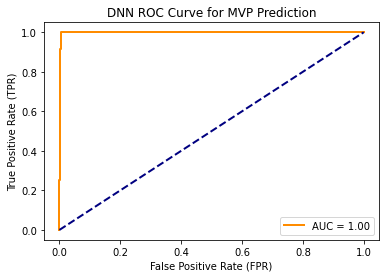

Area under curve (AUC):0.9988179669030732



In [53]:
## Plot AUC Curve ##

# Assign False positive rates, True positive rates and threholds from the ROC Curves
DNN_fprs, DNN_tprs, thresholds = roc_curve(y_test_class, DNN_proba_class)

# Determine AUC Score
DNN_roc_auc = roc_auc_score(y_test_class, DNN_proba_class)

# Plot Curve
plt.figure()
plt.plot(DNN_fprs, DNN_tprs, color='darkorange',
         lw=2, label='AUC = %0.2f' % DNN_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('DNN ROC Curve for MVP Prediction')
plt.legend(loc="best")
plt.show()

print(f'Area under curve (AUC):{DNN_roc_auc}')
print()

The Keras Classifier has a relatively high AUC score meaning at very low thresholds, the model perfoms well at ranking positive instances over negative instances. In comparison to the upsampled model, the recall score is the same and we will proceed to reduce the threshold to capture more positive predictions to increase recall.

To capture at least 1 MVP prediction since 2011 and improve recall score, we will need to set the model threshold to 0.075785 to generate predictions (0.075785 is the lowest probability from the last 12 years to predict the NBA MVP - Lebron James in 2012)

In [54]:
# Set Threshold
threshold = 0.075785 - 0.000001

# If the probability that a data point belongs to the positive class is greater than 0.101492, 
# it gets classified as 1; otherwise, it gets classified as 0
y_pred_DNN = np.where(DNN_proba_class > threshold, 1, 0)

DNN_threshold_class_report = classification_report(y_test_class, y_pred_DNN)
print(f"Classification report for a threshold of {threshold} \n")
print(DNN_threshold_class_report)

# Build a df
prob_DNN_class = pd.DataFrame(y_pred_DNN, columns=["MVP Prediction"], index=df_test.index)

# Add player and year columns
results_DNN_class = pd.concat([df_test[['Year','Player']], prob_DNN_class], axis=1)

# Filter out MVPs
results_DNN_class = results_DNN_class[results_DNN_class["MVP Prediction"] == 1]

# Add probabiltiies from model
results_DNN_class['Probability of MVP'] = DNN_proba_class_df.loc[results_DNN_class.index]

# Sort the dataframe based on Year and Probability
results_DNN_class.sort_values(["Year", "Probability of MVP"], axis = 0, ascending = True,
               inplace = True, na_position = "first")

# Preview df
results_DNN_class

Classification report for a threshold of 0.075784 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6063
           1       0.41      0.92      0.56        12

    accuracy                           1.00      6075
   macro avg       0.70      0.96      0.78      6075
weighted avg       1.00      1.00      1.00      6075



Year                 Player  MVP Prediction  Probability of MVP
12378  2011            Kobe Bryant               1            0.104809
12373  2011              Pau Gasol               1            0.277092
12442  2011           Derrick Rose               1            0.467397
13171  2013             Chris Paul               1            0.232340
13192  2013           Kevin Durant               1            0.490256
13552  2013           LeBron James               1            0.911933
13758  2014          Blake Griffin               1            0.112778
13751  2014             Chris Paul               1            0.213988
13599  2014          Stephen Curry               1            0.428876
13640  2014           Kevin Durant               1            0.454789
14313  2015           James Harden               1            0.112588
14360  2015             Chris Paul               1            0.809070
14474  2015          Stephen Curry               1            0.964628
14544  2016           LeBron James               1            0.100992
14954  2016         Draymond Green               1            0.268840
14562  2016             Chris Paul               1            0.295224
14958  2016          Stephen Curry               1            0.991572
15107  2017      Russell Westbrook               1            0.220761
15179  2017          Stephen Curry               1            0.257071
15183  2017           Kevin Durant               1            0.611581
15707  2018           James Harden               1            0.371557
16314  2019           James Harden               1            0.090963
16225  2019  Giannis Antetokounmpo               1            0.108471
17091  2020  Giannis Antetokounmpo               1            0.112030
16590  2020           LeBron James               1            0.417873
17327  2021           Nikola Jokić               1            0.277709
17965  2022           Nikola Jokić               1            0.194102

We have decreased precision to 0.32, but increased our recall to 0.83 with the lower threshold - this is a higher recall vs previous classification models with low thresholds!). We will be assessing and comparing all 3 models perfomance using the same threshold in the next section.

## Scikit Learn / Neural Network Model Results & Summary  <a id="3"></a>

For this project, ML pipelines were develop and the following models were developed for NBA MVP predictions:
- **Random Forest Regressor** --> Max_depth = 9, N_estimators = 50
- **XGB Classifier** --> Max_depth = 2, Learning_Rate = 0.1, N_estimators = 50
- **XGB Classifier (Upsampled)** --> Max_depth = 7, Learning_Rate = 0.7, N_estimators = 50
- **Keras Regressor** --> Units = 100, Dropout = 0.1, Epochs = 100, Learning Rate = 0.0001
- **Keras Classifier** --> Units = 100, Dropout = 0.1, Epochs = 100, Learning Rate = 0.001


As we can see, there are various hyperparameter values across the different models. To explore the model performance, let us compare the model predictions and key metrisc i.e precision, recall, f1-score acrosst he models.

In [55]:
# Collect true results
true_results = df_test[df_test['Rank'] == 1][['Year','Player']]

#define list of DataFrames
dfs = [true_results, reg_results_df[['Year','Player']], 
       results_df_class[['Year','Player']], results_df_up_class[['Year','Player']],
       DNN_results_df[['Year','Player']], DNN_results_df_class[['Year','Player']]]

#merge all DataFrames into one
final_df = reduce(lambda  left,right: pd.merge(left,right,on=['Year'], how='outer'), dfs)
final_df.columns = ['Year','True MVPs', 'XGB Regressor', 
                    'XGB Classifier', 'XGB Classifier (upsampled)',
                   'Keras Regressor', 'Keras Classifier']

#set index
final_df = final_df.set_index('Year')
display(final_df)

True MVPs          XGB Regressor         XGB Classifier  \
Year                                                                        
2011           Derrick Rose           LeBron James           LeBron James   
2012           LeBron James           LeBron James           LeBron James   
2013           LeBron James           LeBron James           LeBron James   
2014           Kevin Durant           Kevin Durant           Kevin Durant   
2015          Stephen Curry          Stephen Curry          Stephen Curry   
2016          Stephen Curry          Stephen Curry          Stephen Curry   
2017      Russell Westbrook           James Harden          Kawhi Leonard   
2018           James Harden           James Harden           James Harden   
2019  Giannis Antetokounmpo  Giannis Antetokounmpo  Giannis Antetokounmpo   
2020  Giannis Antetokounmpo           James Harden           LeBron James   
2021           Nikola Jokić           Nikola Jokić           Nikola Jokić   
2022           Nikola Jokić  Giannis Antetokounmpo           Nikola Jokić   

     XGB Classifier (upsampled)        Keras Regressor       Keras Classifier  
Year                                                                           
2011               LeBron James           LeBron James           Derrick Rose  
2012               LeBron James           LeBron James             Chris Paul  
2013               LeBron James           LeBron James           LeBron James  
2014               Kevin Durant           Kevin Durant           Kevin Durant  
2015                 Chris Paul          Stephen Curry          Stephen Curry  
2016          Russell Westbrook          Stephen Curry          Stephen Curry  
2017               Kevin Durant      Russell Westbrook           Kevin Durant  
2018               James Harden        Naz Mitrou-Long           James Harden  
2019      Giannis Antetokounmpo           James Harden  Giannis Antetokounmpo  
2020      Giannis Antetokounmpo  Giannis Antetokounmpo           LeBron James  
2021             Damian Lillard           Nikola Jokić           Nikola Jokić  
2022                 Chris Paul           Nikola Jokić           Nikola Jokić

Please see below accuracy on the 5 models generated in predicting the NBA MVP from the past 12 seasons based on the highest probability from each NBA Season:
- **Random Forest Regressor**: 67% accuracy
- **XGB Classifier**: 75% accuracy
- **XGB Classifier (upsampled)**: 50%
- **Keras Regressor**: 75%
- **Keras Classifier**: 67%

In the section below, we will compare the above models to determine the optimum regression and classification models.

### Regression Models Predictions  <a id="3.1"></a>

Although, XGB Regressor generated a high accuracy, 67%, the model significantly overfit (67% test accuracy, 94% train accuracy); on the other hand, the Keras Regressor perfomed better with a 95.6% train accuracy and 97.4% test accuracy. Therefore, for the regression models, the **Keras Regressor** generated the best model performance. <br>

Let us review the top 5 MVP predictions from the Keras Regressor and also explain the contributions of each feature to a predicted output from the model. 

In [56]:
# Concat Player information and predicted MVP Share (Target Variable)
Reg_predictor = pd.concat([df_test[['Year','Player']], DNN_predictions], axis=1)

# Group by Year and apply function to collect top 5 MVP Share votes / year
Reg_predictor = Reg_predictor.groupby(['Year']).\
                apply(lambda x : x.sort_values(by = 'Predicted MVP Votes', 
                                               ascending = False).head(5))

# Drop Additional 'Year' column
Reg_predictor.drop(columns='Year', inplace=True)

# Preview df
Reg_predictor

Player  Predicted MVP Votes
Year                                                  
2011 12502           LeBron James             0.499200
     12442           Derrick Rose             0.483093
     12365          Dwight Howard             0.305356
     12378            Kobe Bryant             0.296166
     12504            Dwyane Wade             0.280039
2012 12863           LeBron James             0.510033
     12728             Chris Paul             0.135438
     12958           Kevin Durant             0.102373
     12862            Dwyane Wade             0.098598
     13078           Derrick Rose             0.089800
2013 13552           LeBron James             0.947664
     13192           Kevin Durant             0.524499
     13171             Chris Paul             0.244456
     13194      Russell Westbrook             0.130745
     13244            Kobe Bryant             0.126666
2014 13640           Kevin Durant             0.583951
     14014           LeBron James             0.547473
     13671             Kevin Love             0.370767
     13599          Stephen Curry             0.222596
     13751             Chris Paul             0.194594
2015 14474          Stephen Curry             0.492934
     14360             Chris Paul             0.397868
     14313           James Harden             0.395343
     14072          Anthony Davis             0.280276
     14049      Russell Westbrook             0.174444
2016 14958          Stephen Curry             0.729827
     14901      Russell Westbrook             0.354646
     14889           Kevin Durant             0.340770
     14544           LeBron James             0.334926
     14582          Kawhi Leonard             0.245978
2017 15107      Russell Westbrook             0.530604
     15072           James Harden             0.504294
     15183           Kevin Durant             0.357362
     15179          Stephen Curry             0.259796
     15017          Kawhi Leonard             0.226943
2018 15789        Naz Mitrou-Long             0.848451
     15707           James Harden             0.603592
     15524           LeBron James             0.230575
     16038          Anthony Davis             0.195957
     15895      Russell Westbrook             0.160828
2019 16314           James Harden             0.617898
     16225  Giannis Antetokounmpo             0.535276
     16237            Joel Embiid             0.184447
     16544           Nikola Jokić             0.182455
     16146         Nikola Vučević             0.151196
2020 17091  Giannis Antetokounmpo             0.591354
     16590           LeBron James             0.414217
     16673           James Harden             0.329981
     16857          Kawhi Leonard             0.136899
     16623            Luka Dončić             0.096600
2021 17327           Nikola Jokić             0.512755
     17212            Joel Embiid             0.220563
     17412  Giannis Antetokounmpo             0.156361
     17555           LeBron James             0.138095
     17578             Chris Paul             0.118074
2022 17965           Nikola Jokić             0.569545
     18233            Joel Embiid             0.415440
     17740  Giannis Antetokounmpo             0.390689
     18007             Chris Paul             0.135110
     17980            Luka Dončić             0.129602

Intrestingly, our last 3 MVP winners have been correctly predicted by our model and the players are either Power-Forwards or Centres which would fall into the "Big" category for player position. Given the transition from "Big" to "Small" ball, our model and actual MVP votes still value the importance of a traditional "Big" man on the court. <br>
<br> 
Let us evaluate the key features/metrics that influence the prediction of MVP votes adn increase the probabiltiy of winning the MVP.

### Feature Importance on Keras Regressor Model.

One of the objectives of this project is to define the key metrics that increase the probability of winning the NBA MVP. We have over 63 independent variables in this dataset that has been modelled to predict the MVP ranking. <br>

We will be utlizing the SHAP parameter on the Keras Regressor model to explain the the contributions from each feature on the model. But first, let us re-run the model with the final hyperparameters and then proceed with running the SHAP function.

In [57]:
# Create a new sequential model
model_reg = keras.Sequential()

# Declare the hidden layers
model_reg.add(layers.Dense(100, activation="relu"))
model_reg.add(layers.Dropout(0.1))
model_reg.add(layers.BatchNormalization()) 

model_reg.add(layers.Dense(100, activation="relu"))
model_reg.add(layers.Dropout(0.1))
model_reg.add(layers.BatchNormalization()) 

model_reg.add(layers.Dense(100, activation="relu"))
model_reg.add(layers.Dropout(0.1))
model_reg.add(layers.BatchNormalization()) 


# Declare the output layer
model_reg.add(layers.Dense(1)) # For regression, we don't specify any activation function.

# Compile the model
model_reg.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.0001),
              loss='MeanSquaredError',
              metrics = ['accuracy'])

# Fit model
history = model_reg.fit(X_train, y_train_num, epochs=100, verbose=0)

In [58]:
# Load JS Visualization to notebook
shap.initjs()

X_train_sample = shap.kmeans(X_train, 10)

In [59]:
# use Kernel SHAP to explain test set predictions
explainer_reg = shap.KernelExplainer(model_reg.predict, X_train_sample, link = "identity")
shap_values_reg = explainer_reg.shap_values(X_test, nsamples=100)

1/1 [==============================] - 0s 269ms/step


  0%|          | 0/6075 [00:00<?, ?it/s]

32/32 [==============================] - 0s 3ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 3ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 3ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 3ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 3ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 3ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 3ms/step


32/32 [==============================] - 0s 3ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 3ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 3ms/step


32/32 [==============================] - 0s 3ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 4ms/step


32/32 [==============================] - 0s 4ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 3ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 3ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 3ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 5ms/step


32/32 [==============================] - 0s 3ms/step


32/32 [==============================] - 0s 3ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 4ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 4ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 3ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 3ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 2ms/step


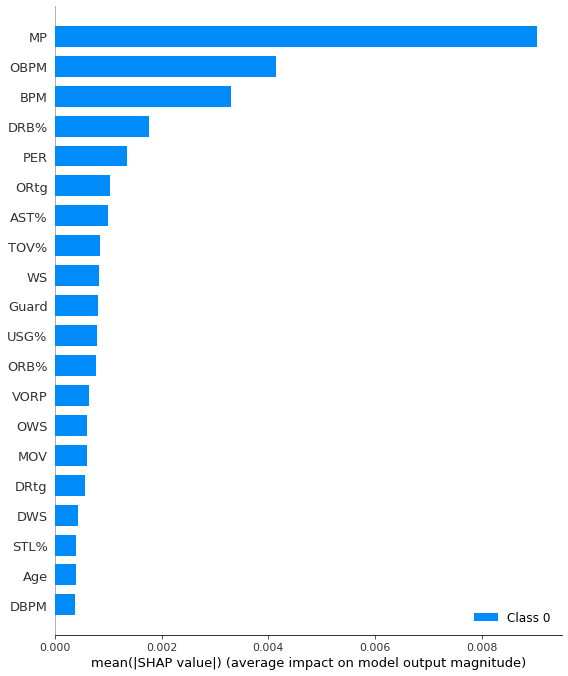

In [60]:
shap.summary_plot(shap_values_reg, X_test)

### Classification Models Predictions <a id="3.2"></a>

For the 3 classification models, accuracy is not a suitable metric to evaluate model performance given the class imbalance. To evaluate model performance, the model thresholds were lowered to evaluate Precision, Recall and also AUC Score for the respectice models. 

First, let us evalaute the AUC curve for all 3 models.

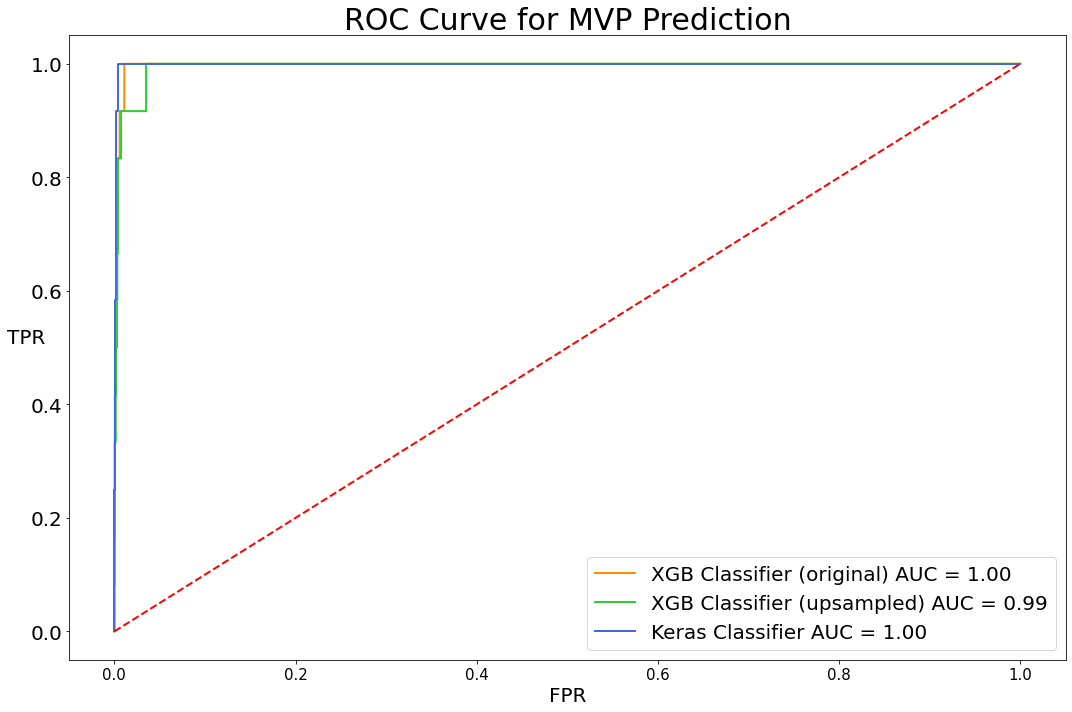

In [61]:
# Plot Curve
plt.figure(figsize=(15,10))
plt.plot(fprs, tprs, color='darkorange',
         lw=2, label='XGB Classifier (original) AUC = %0.2f' % roc_auc)
plt.plot(up_fprs, up_tprs, color='limegreen',
         lw=2, label='XGB Classifier (upsampled) AUC = %0.2f' % up_roc_auc)
plt.plot(DNN_fprs, DNN_tprs, color='royalblue',
         lw=2, label='Keras Classifier AUC = %0.2f' % DNN_roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlabel('FPR', fontsize=20)
plt.ylabel('TPR', fontsize=20, rotation=0)
plt.xticks(fontsize=15)
plt.yticks(fontsize=20)
plt.title('ROC Curve for MVP Prediction', fontsize=30)
plt.legend(loc="best", fontsize=20)
plt.savefig('data/ROC Curve for MVP Prediction(Advanced_Stats).png', facecolor = 'white', bbox_inches = 'tight')
plt.tight_layout()
plt.show()

print()

As you can seee from above, **XGB Classifer (original)** and **Keras Classifier** both had the highest AUC score. We will need to explore running all 3 models at lower threshold to compare the precision, recall and f1-score to determine the optimum classification model. 

In [62]:
threshold = 0.5

print(f"Classification report for a threshold of {threshold} on XGB Classifier.\n")
print(class_report)

print(f"Classification report for a threshold of {threshold} on Keras Classifier\n")
print(DNN_class_report)

print(f"Classification report for a threshold of {threshold} on XGB Classifier (upsampled)\n")
print(up_class_report)

Classification report for a threshold of 0.5 on XGB Classifier.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6063
           1       0.57      0.33      0.42        12

    accuracy                           1.00      6075
   macro avg       0.79      0.67      0.71      6075
weighted avg       1.00      1.00      1.00      6075

Classification report for a threshold of 0.5 on Keras Classifier

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6063
           1       0.60      0.25      0.35        12

    accuracy                           1.00      6075
   macro avg       0.80      0.62      0.68      6075
weighted avg       1.00      1.00      1.00      6075

Classification report for a threshold of 0.5 on XGB Classifier (upsampled)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6063
           1       0.43      0

Based on the above charts, we can conclude the following:
- Keras Classifier generated the highest recall (**0.5**), precision score (**0.6**) and F1-score (**0.55**) among the classification models at the default 0.5 threshold. 
    - The model performs well in classifying the positive classes as true positives and has less false positives in comparison to other models.
- Keras Classifer has the highest AUC score meaning that at very low thresholds, it is the best model at at distinguishing between the positive and negative classes.

In summary, the **Keras Classifier** is the optimum classification model in predicting the NBA MVP as it had the best combination of recall, precision and AUC Score among the classification models and also correctly predicted 67% of the NBA MVPs - since 2011 - based on Model Probabilities.

Let us revisit model predictions from the XGB Classifier and actual NBA MVPs.

In [63]:
# Merge True MVP with Predicted MVPs from XGB Classifier model
new_df = pd.merge(final_df[['True MVPs']], results_DNN_class, on='Year')

# Rename 'Player' column
new_df.rename(columns = {'Player' : 'Predicted MVP Winners from Keras Classification Model @ 0.052208 threshold'}, 
              inplace=True)

#
new_df = new_df.groupby(['Year',
                         'True MVPs',
                         'Predicted MVP Winners from Keras Classification Model @ 0.052208 threshold'])\
                            .sum()[['Probability of MVP']].sort_values(["Year", "Probability of MVP"], 
                                          axis = 0, ascending = True,
                                          na_position = "first")

new_df

Probability of MVP
Year True MVPs             Predicted MVP Winners from Keras Classification...                    
2011 Derrick Rose          Kobe Bryant                                                   0.104809
                           Pau Gasol                                                     0.277092
                           Derrick Rose                                                  0.467397
2013 LeBron James          Chris Paul                                                    0.232340
                           Kevin Durant                                                  0.490256
                           LeBron James                                                  0.911933
2014 Kevin Durant          Blake Griffin                                                 0.112778
                           Chris Paul                                                    0.213988
                           Stephen Curry                                                 0.428876
                           Kevin Durant                                                  0.454789
2015 Stephen Curry         James Harden                                                  0.112588
                           Chris Paul                                                    0.809070
                           Stephen Curry                                                 0.964628
2016 Stephen Curry         LeBron James                                                  0.100992
                           Draymond Green                                                0.268840
                           Chris Paul                                                    0.295224
                           Stephen Curry                                                 0.991572
2017 Russell Westbrook     Russell Westbrook                                             0.220761
                           Stephen Curry                                                 0.257071
                           Kevin Durant                                                  0.611581
2018 James Harden          James Harden                                                  0.371557
2019 Giannis Antetokounmpo James Harden                                                  0.090963
                           Giannis Antetokounmpo                                         0.108471
2020 Giannis Antetokounmpo Giannis Antetokounmpo                                         0.112030
                           LeBron James                                                  0.417873
2021 Nikola Jokić          Nikola Jokić                                                  0.277709
2022 Nikola Jokić          Nikola Jokić                                                  0.194102

### Feature Importance on Keras Classifier Model.

One of the objectives of this project is to define the key metrics that increase the probability of winning the NBA MVP. We have over 63 independent variables in this dataset that has been modelled to predict the MVP ranking. <br>

We will be utlizing the SHAP parameter on the Keras Regressor model to explain the the contributions from each feature on the model. But first, let us re-run the model with the final hyperparameters and then proceed with running the SHAP function.

In [64]:
# Create a new sequential model
model_class = keras.Sequential()

# Declare the hidden layers
model_class.add(layers.Dense(100, activation="relu"))
model_class.add(layers.Dropout(0.1))
model_class.add(layers.BatchNormalization()) 

model_class.add(layers.Dense(100, activation="relu"))
model_class.add(layers.Dropout(0.1))
model_class.add(layers.BatchNormalization()) 

model_class.add(layers.Dense(100, activation="relu"))
model_class.add(layers.Dropout(0.1))
model_class.add(layers.BatchNormalization()) 


# Declare the output layer
model_class.add(layers.Dense(1, activation = "sigmoid"))

# Compile the model
model_class.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.01),
              loss = 'BinaryCrossentropy',
              metrics = ['accuracy'])

# Fit model
history_class = model_class.fit(X_train, y_train_class, epochs=100, verbose=0)

In [81]:
shap_values_class1 = explainer_class.shap_values(X_test.iloc[0,:])

658/658 [==============================] - 3s 4ms/step


In [66]:
# use Kernel SHAP to explain test set predictions
explainer_class = shap.KernelExplainer(model_class.predict, X_train_sample)
shap_values_class = explainer_class.shap_values(X_test, nsamples=100)

1/1 [==============================] - 0s 399ms/step


  0%|          | 0/6075 [00:00<?, ?it/s]

32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 3ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 3ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 3ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 3ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 3ms/step


32/32 [==============================] - 0s 4ms/step


32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 38ms/step


32/32 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 106ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 52ms/step


32/32 [==============================] - 0s 5ms/step


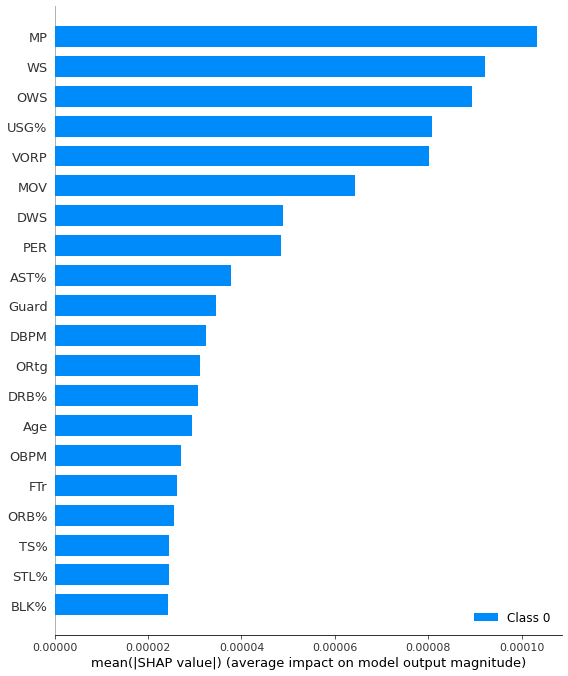

In [80]:
# Plot key features
shap.summary_plot(shap_values_class, X_test)

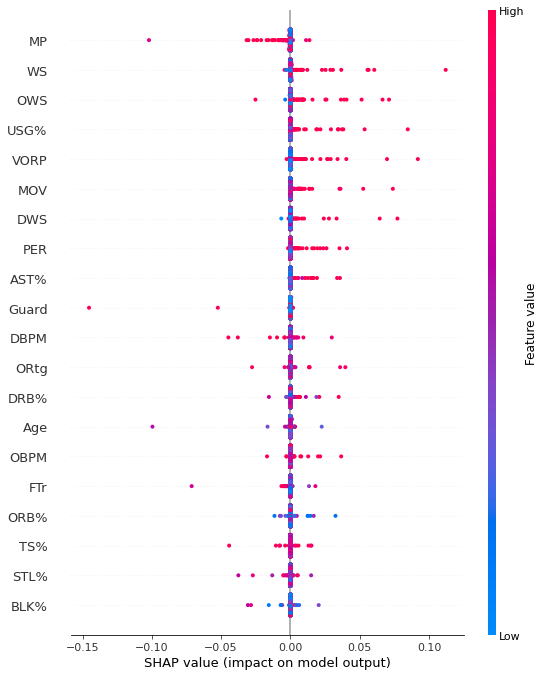

In [77]:
# Plot key features
shap.summary_plot(shap_values_class[0], X_test)

On the top classification model, the top 3 features in predicting the NBA MVP are **MP, WS and OWS**. PER appears as a top predictor on both models so this feature definitely has a significant influence on model predictions. 

## Conclusion <a id="5"></a>

In summary, the models performed really well in predicting the NBA MVP. The top regression and classification models were the Keras Regressor and Keras Classifier respectively. Valuable insights were generated from the model predictions and the top model features from the Keras Regressor were the **ORB%, PER and Age** and **MP, OWS and PER** on the Keras Classifier.

As a next step, I would look to explore the top features from the Keras Classifier and compare/contrast the differences between the 2 models. Additionally, I would look to explore dimensionality reduction i.e PCA for model improvement

In [68]:
# Save Keras Reg model
joblib.dump(model_reg, "Models/keras_reg_model.pkl")

# Save Keras Classifier model
joblib.dump(model_class, "Models/keras_class_model.pkl")

INFO:tensorflow:Assets written to: ram://a092e566-75e2-4caa-aed0-0d2d03f271a0/assets
INFO:tensorflow:Assets written to: ram://d813677c-5567-4757-b8c2-d6650a463742/assets


['Models/keras_class_model.pkl']